In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import itertools
import re

import numpy as np
import bottleneck as bn
import pandas as pd
from sklearn import decomposition
import networkx as nx
# import networkx.algorithms.approximation as nxa
import igraph as ig
# # http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
# from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import missingno as msno
import palettable
%matplotlib inline

np.set_printoptions(linewidth=145)

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
warnings.simplefilter("ignore", category=UserWarning)


from collections import defaultdict, Counter
from IPython.display import display as disp
from IPython.display import display_markdown
mdisp = lambda s: display_markdown(s, raw=True)

from speclib.loaders import *
from speclib.plotting import *
from speclib.graph import *
from speclib.misc import *
from speclib.userActivityFunctions import *

for k, v in {'font.size': 13.0,
             'legend.fontsize': 13.0,
             'axes.labelsize': 12.0,
             'axes.titlesize': 15.0,
             'figure.figsize': [16.0, 7.0],
             'figure.dpi': 200,
             'figure.titlesize': 'large',
             'xtick.labelsize': 13.0,
             'ytick.labelsize': 13.0}.items():
    mpl.rcParams[k] = v

%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno
%watermark  -p networkx,igraph,seaborn,palettable

Allan Leander Rostock Hansen 
last updated: 2017-05-30 

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
bottleneck 1.2.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1
missingno 0.3.5
networkx 2.0.dev_20170522104220
igraph 0.7.1
seaborn 0.7.1
palettable 3.0.0


In [2]:
%load_ext autoreload

In [3]:
%autoreload -2 

# Load and clean data

In [4]:
if os.path.isfile('phone_df.h5'):
    df = pd.io.pytables.read_hdf('phone_df.h5', 'df')
    import pickle
    with open('useralias.pk', 'br') as fid:
        ua = pickle.load(fid)
else:
    ua = Useralias()
    userSpec = [(user, ua[user], ('sms', 'call')) for user in getUserList()]
    userData = loadUserParallel(userSpec) 
    df = users2DataFrame(userData, ua)
    del userData
phonebook = loadUserPhonenumberDict(ua) 
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

Remove call to users not in phonebook.

In [5]:
df = df[df.number.isin(phonebook)] 

Add _contactedUser_ column and remove the _number_ column.

In [6]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df = df.drop('number', axis=1)

In [7]:
df.head() 

body  duration  hour     timeint           timestamp  weekday  \
user  comtype                                                                 
u0001 call     NaN       0.0     1  1390698006 2014-01-26 01:00:06        6   
      call     NaN       0.0    14  1391176805 2014-01-31 14:00:05        4   
      call     NaN      29.0    14  1391782631 2014-02-07 14:17:11        4   
      call     NaN      22.0    14  1391782712 2014-02-07 14:18:32        4   
      call     NaN       3.0    14  1394805935 2014-03-14 14:05:35        4   

              contactedUser  
user  comtype                
u0001 call            u0493  
      call            u0493  
      call            u0117  
      call            u0493  
      call            u0117

## Check for obvious outliers

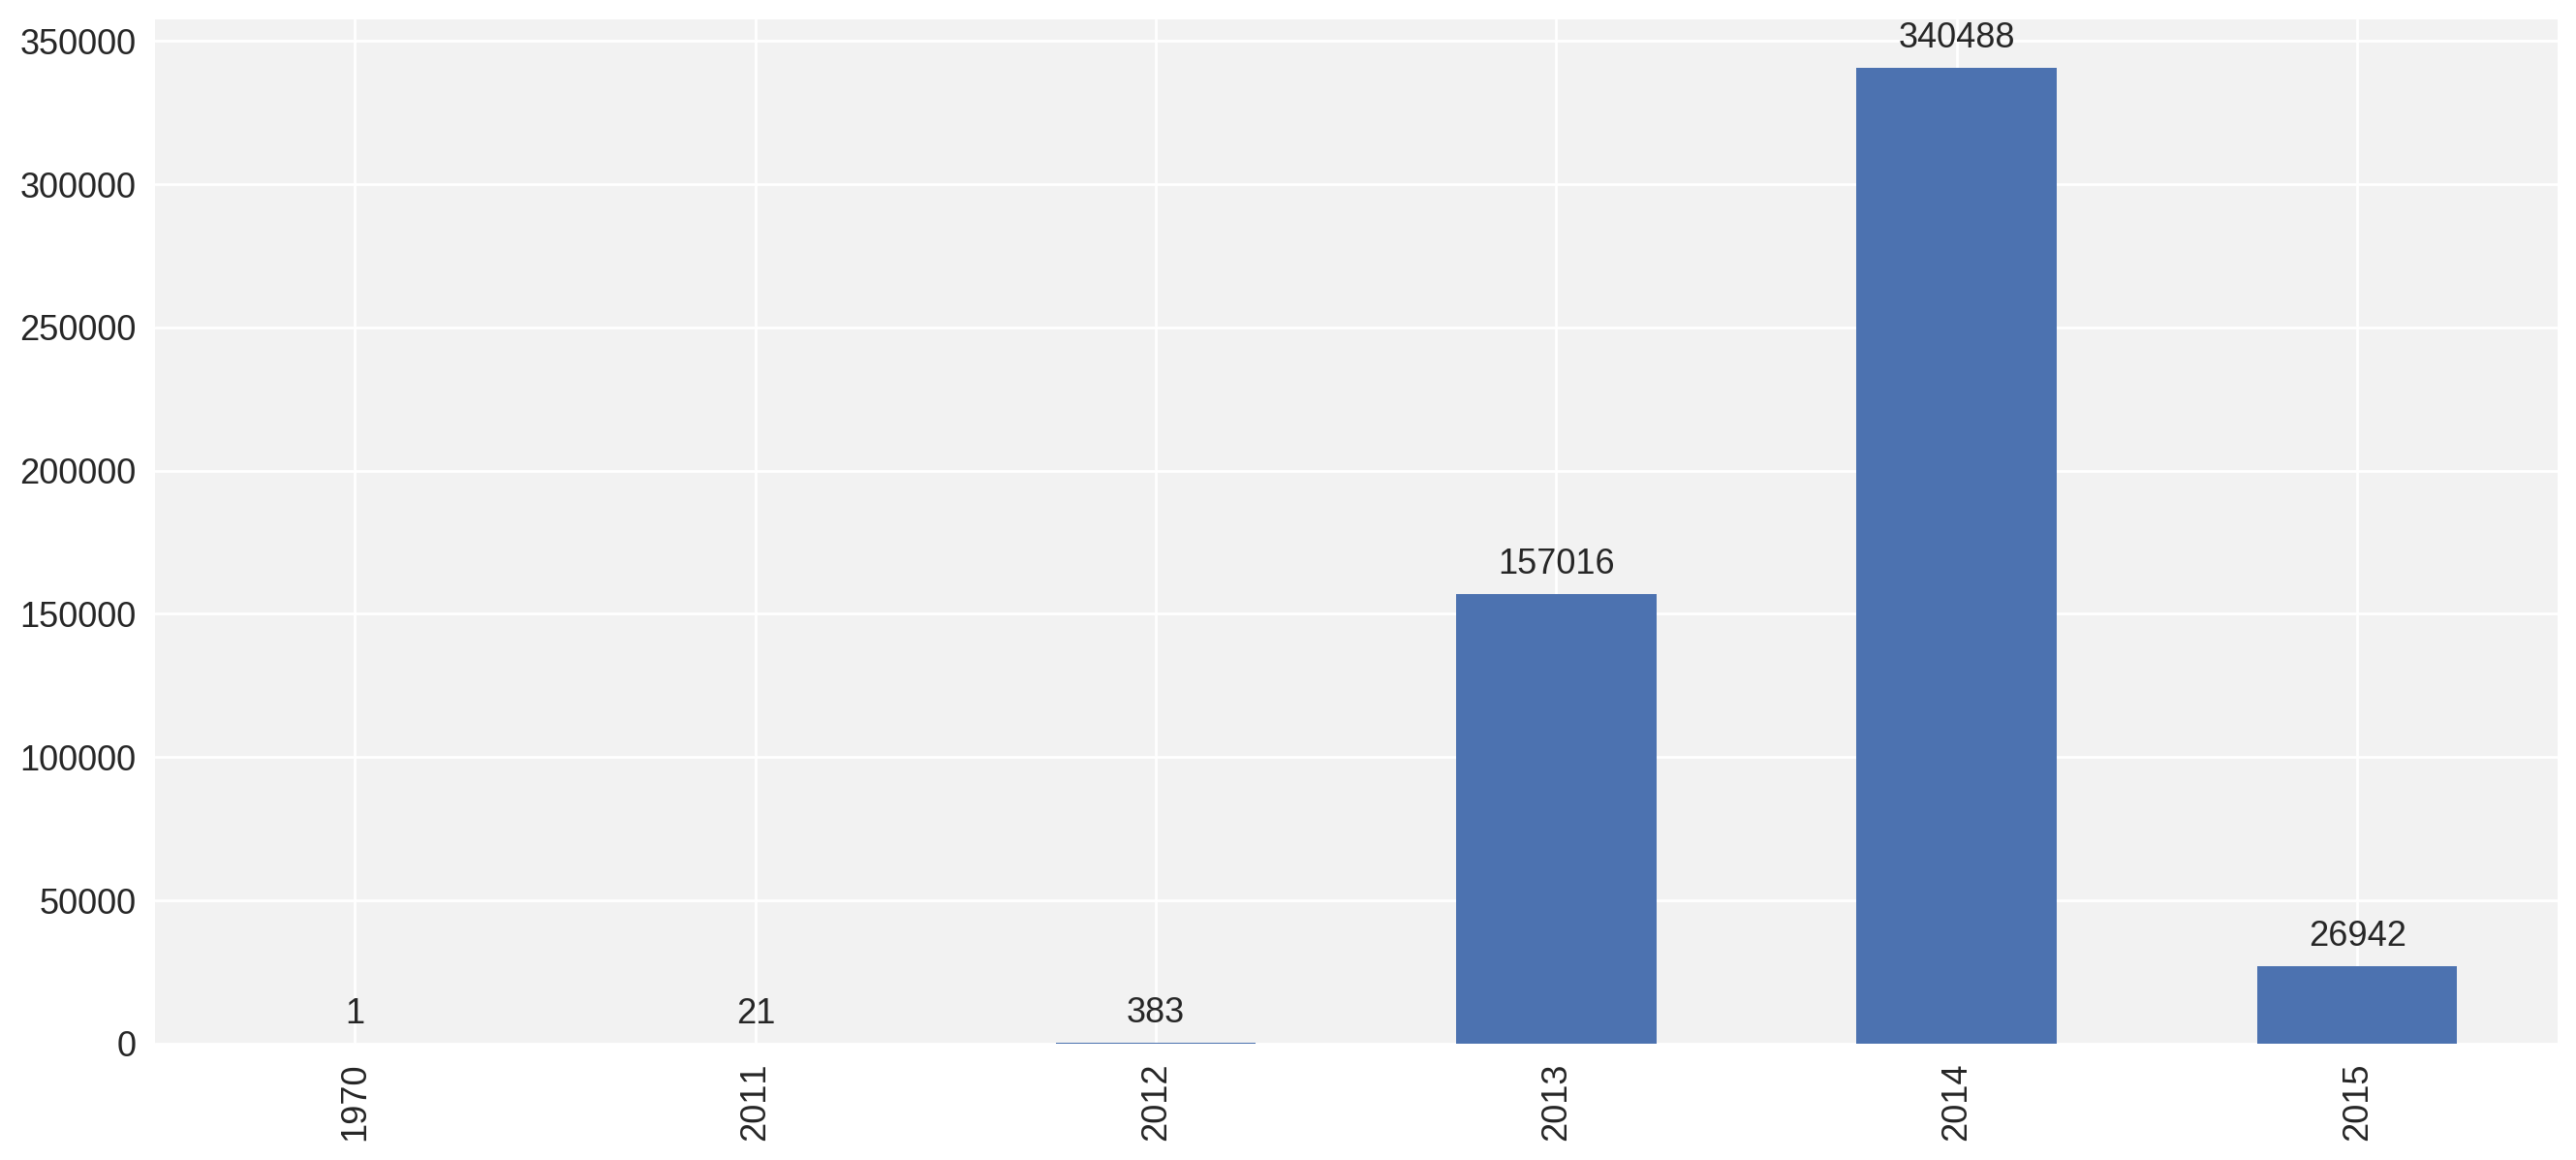

In [8]:
ax = df.timestamp.dt.year.value_counts().sort_index(ascending=True).plot.bar() 
countsOnBarPlot(ax) 

Remove data preceding 2013.

In [9]:
df = df[df.timestamp.dt.year >= 2013] 

In [10]:
monthNameLookup = {1: 'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May', 6: 'June',
                   7: 'July', 8: 'Aug.', 9: 'Sept.', 10: 'Oct.', 11: 'Nov.', 12: 'Dec.'}

grp = df.groupby([df.timestamp.dt.year, df.timestamp.dt.month])

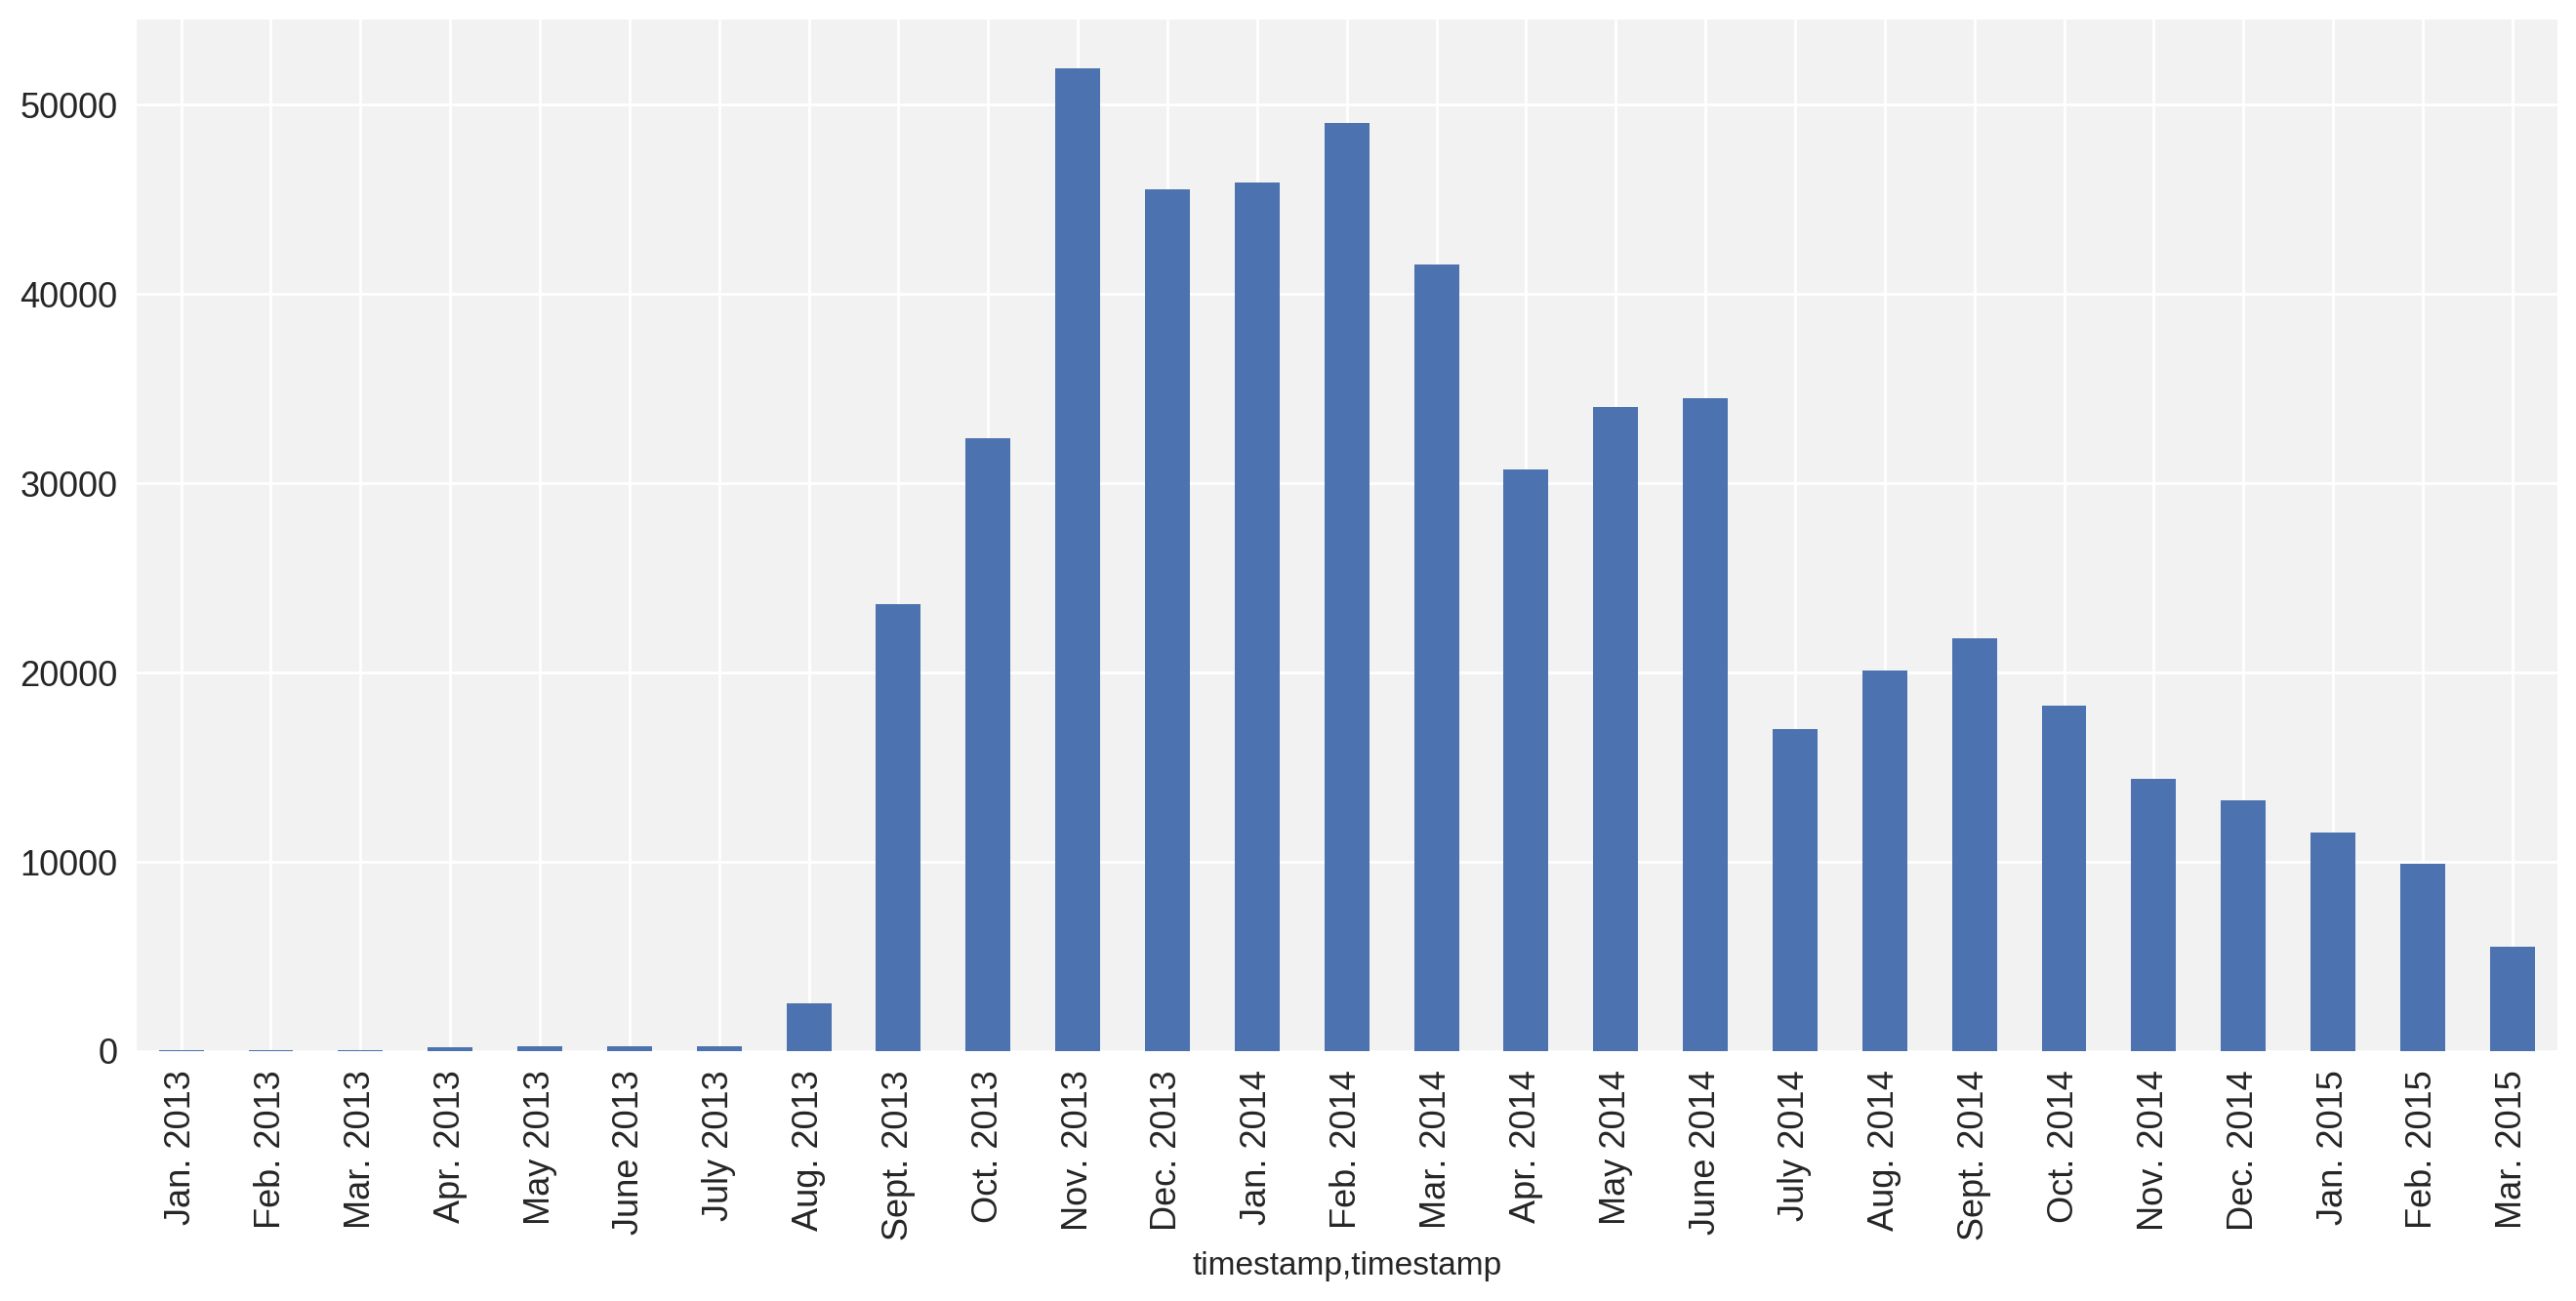

In [11]:
ax = grp.timeint.count().plot.bar() 
newLabelList = list()
for lbl in ax.get_xticklabels():
    lblTxt = lbl.get_text()
    year, month = re.findall(r'(\d+)', lblTxt)
    month = monthNameLookup[int(month)]
    newTxt = f'{month} {year}'
    newLabelList.append(newTxt)
ax.set_xticklabels(newLabelList);

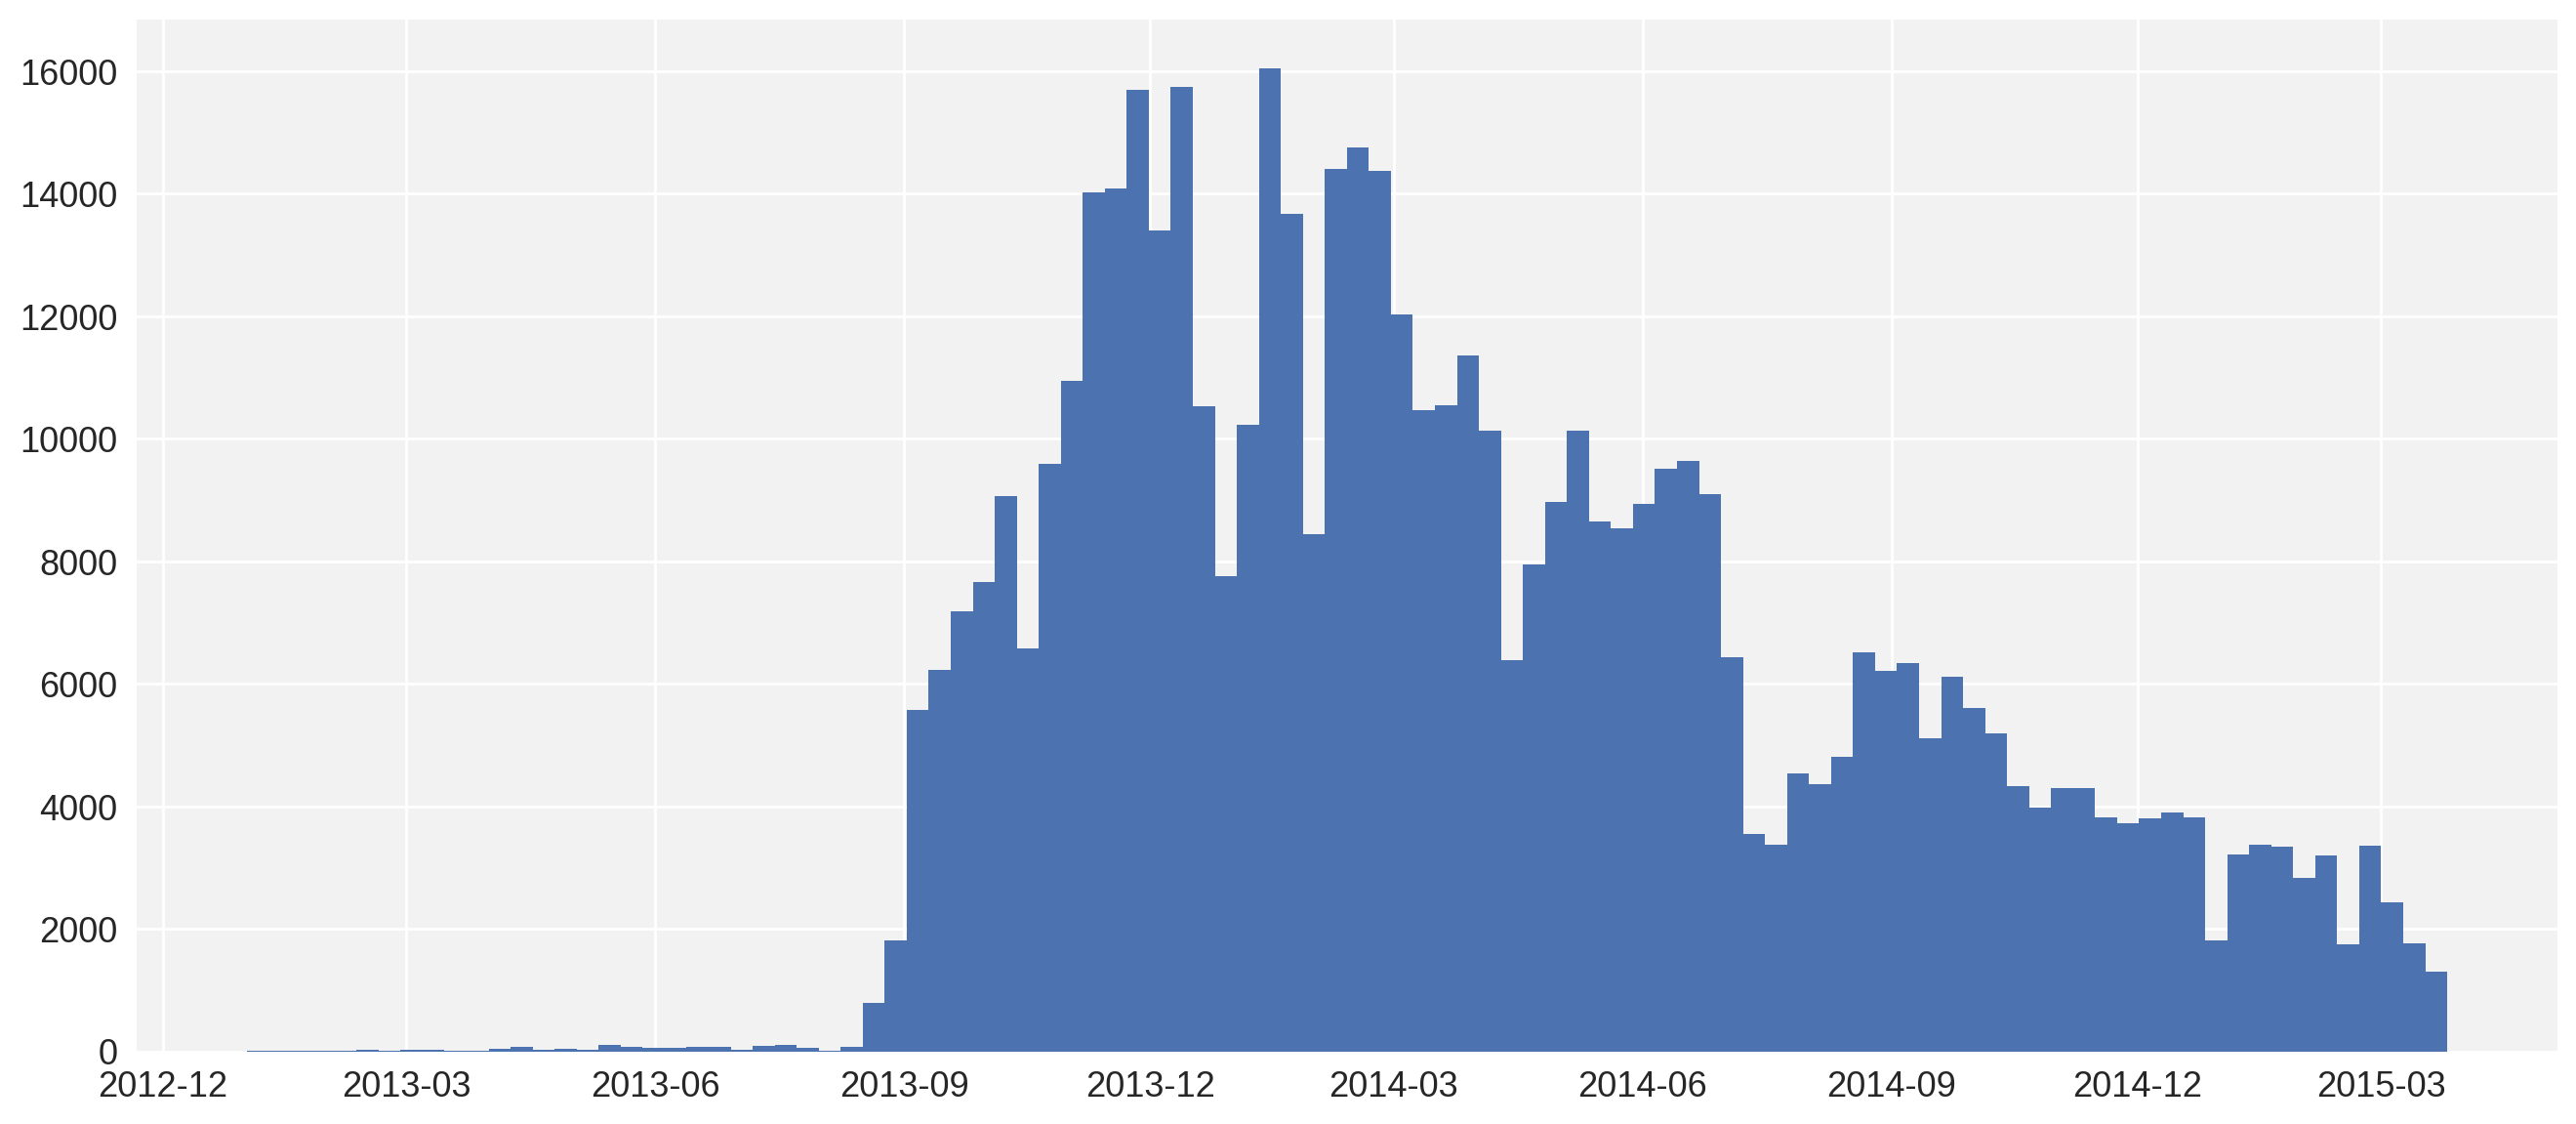

In [12]:
fig, ax = plt.subplots()
ax.hist(df.timestamp.values, bins=100, histtype='stepfilled'); 

## Remove entries with users contacting themself

In [13]:
tmp = df.reset_index()
tmp = tmp[(tmp.user != tmp.contactedUser)]
df = tmp.set_index(['user', 'comtype'], drop=False)
del tmp

# Play with a sliding window algorithm to determine connectivity

In [14]:
df.loc[['u0001', 'u0002', 'u0003']]

user comtype                                      body  \
user  comtype                                                            
u0001 call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      call     u0001    call                                       NaN   
      sms      u0001     sms  4c916acc6ce08fb0cecd01d6ffa9db8393b3bb83   
      sms      u0001     sms  b0bf4e3daadbb14e0c55c306d28fe0b1286c5f65   
      sms      u0001     sms  afb6c04a756f9d66498413195a0b551437a38334   
      sms      u0001     sms  b5e496a6eaa67df5ed1d7302c5384ba779c584f5   
      sms      u0001     sms  d4e359e0872642a5c33dbc842af46c70c008d757   
      sms      u0001     sms  c8860dd1304194daae8027aed488c3d85441f518   
      sms      u0001     sms  8757b40de41a8c152dbde35664ef926fa9c3b56c   
      sms      u0001     sms  f8085d2661fedd8a7df4168011a6df27de7d8280   
      sms      u0001     sms  d7573e71d2eb31cb2450a8c65d7a859988002e6b   
      sms      u0001     sms  d7573e71d2eb31cb2450a8c65d7a859988002e6b   
...              ...     ...                                       ...   
u0002 sms      u0002     sms  b52d401827f784d1da233689db693e79f184a36b   
      sms      u0002     sms  f6da5483de167b2a9e994902e1a6b1ed94a1d16e   
      sms      u0002     sms  c53c562dab4b33b3e42f3bc4d8e5719439a9c155   
      sms      u0002     sms   2e5f02af9cbace54070ab0264b65d48e5b05da7   
u0003 call     u0003    call                                       NaN   
      call     u0003    call                                       NaN   
      call     u0003    call                                       NaN   
      sms      u0003     sms   44efdcae4a5104447b55641b9af6f3dfb7d20e6   
      sms      u0003     sms  12b5175af369ab0fd509fff30cd2e7835d46b55f   
      sms      u0003     sms  726d2c3c55b711435773f3c50b0ba84487c8509a   
      sms      u0003     sms  143a1b932f70ccc9b966dbb38db48bcb00514cd9   
      sms      u0003     sms  683a2d55ecf3fa4b5459f23494398313a7051e73   
      sms      u0003     sms  6b9a6f8e6d10743b264a01c5046303cfd83bf97c   
      sms      u0003     sms  dfc3a23b6e19f6017d5b297b268dd3971f9151e6   
      sms      u0003     sms  c95e78578c551b9092d554b6c74e970c957895da   
      sms      u0003     sms  fd70f113672e3098627a6c459ea10374fe803340   
      sms      u0003     sms  ec08769d0269b988fca07a20ea221aa1a87332ca   
      sms      u0003     sms  c3ebd1fa199cead7bb3c10d1e849936c861df806   
      sms      u0003     sms  dd7128ec2729bf9cf8ce64b15ccf1d0af806cfd4   
      sms      u0003     sms  23afd03dac6bfe136bf6cbc52512d444c105d001   
      sms      u0003     sms  1038e8347f4685fd90f0f1f899502e2c42b27149   
      sms      u0003

# Turn data into a Networkx graph

1. Split the data into call and SMS data.
2. Create directional weighted graphs from both.
3. Convert call graph to undirected graph, not requiering a mutual relationship for a link to exist.
4. Convert sms graph to directed graph, requiering a mutual relationship for a link to exist.
5. Combine in a single weighted, undirected graph.

In [15]:
# g = userDf2nxGraph(df, graphtype=nx.DiGraph)
cdf = df.xs('call', level=1)
cdf = cdf.reset_index(drop=True).set_index(['user', 'comtype'], drop=False)
gc = userDf2nxGraph(cdf, graphtype=nx.DiGraph)
sdf = df.xs('sms', level=1)
sdf = sdf.reset_index(drop=True).set_index(['user', 'comtype'], drop=False)
gs = userDf2nxGraph(sdf, graphtype=nx.DiGraph)

In [16]:
g = gc.to_undirected(reciprocal=True) 
g.add_nodes_from(gs.nodes()) 
g.add_weighted_edges_from(gs.to_undirected(reciprocal=True).edges(data='weight'))

Ensure that the graph contains the correct number of nodes

In [17]:
assert len(list(g.nodes())) == len(set(df.index.get_level_values('user').tolist() + df.contactedUser.tolist())) 

## Analyse the graph

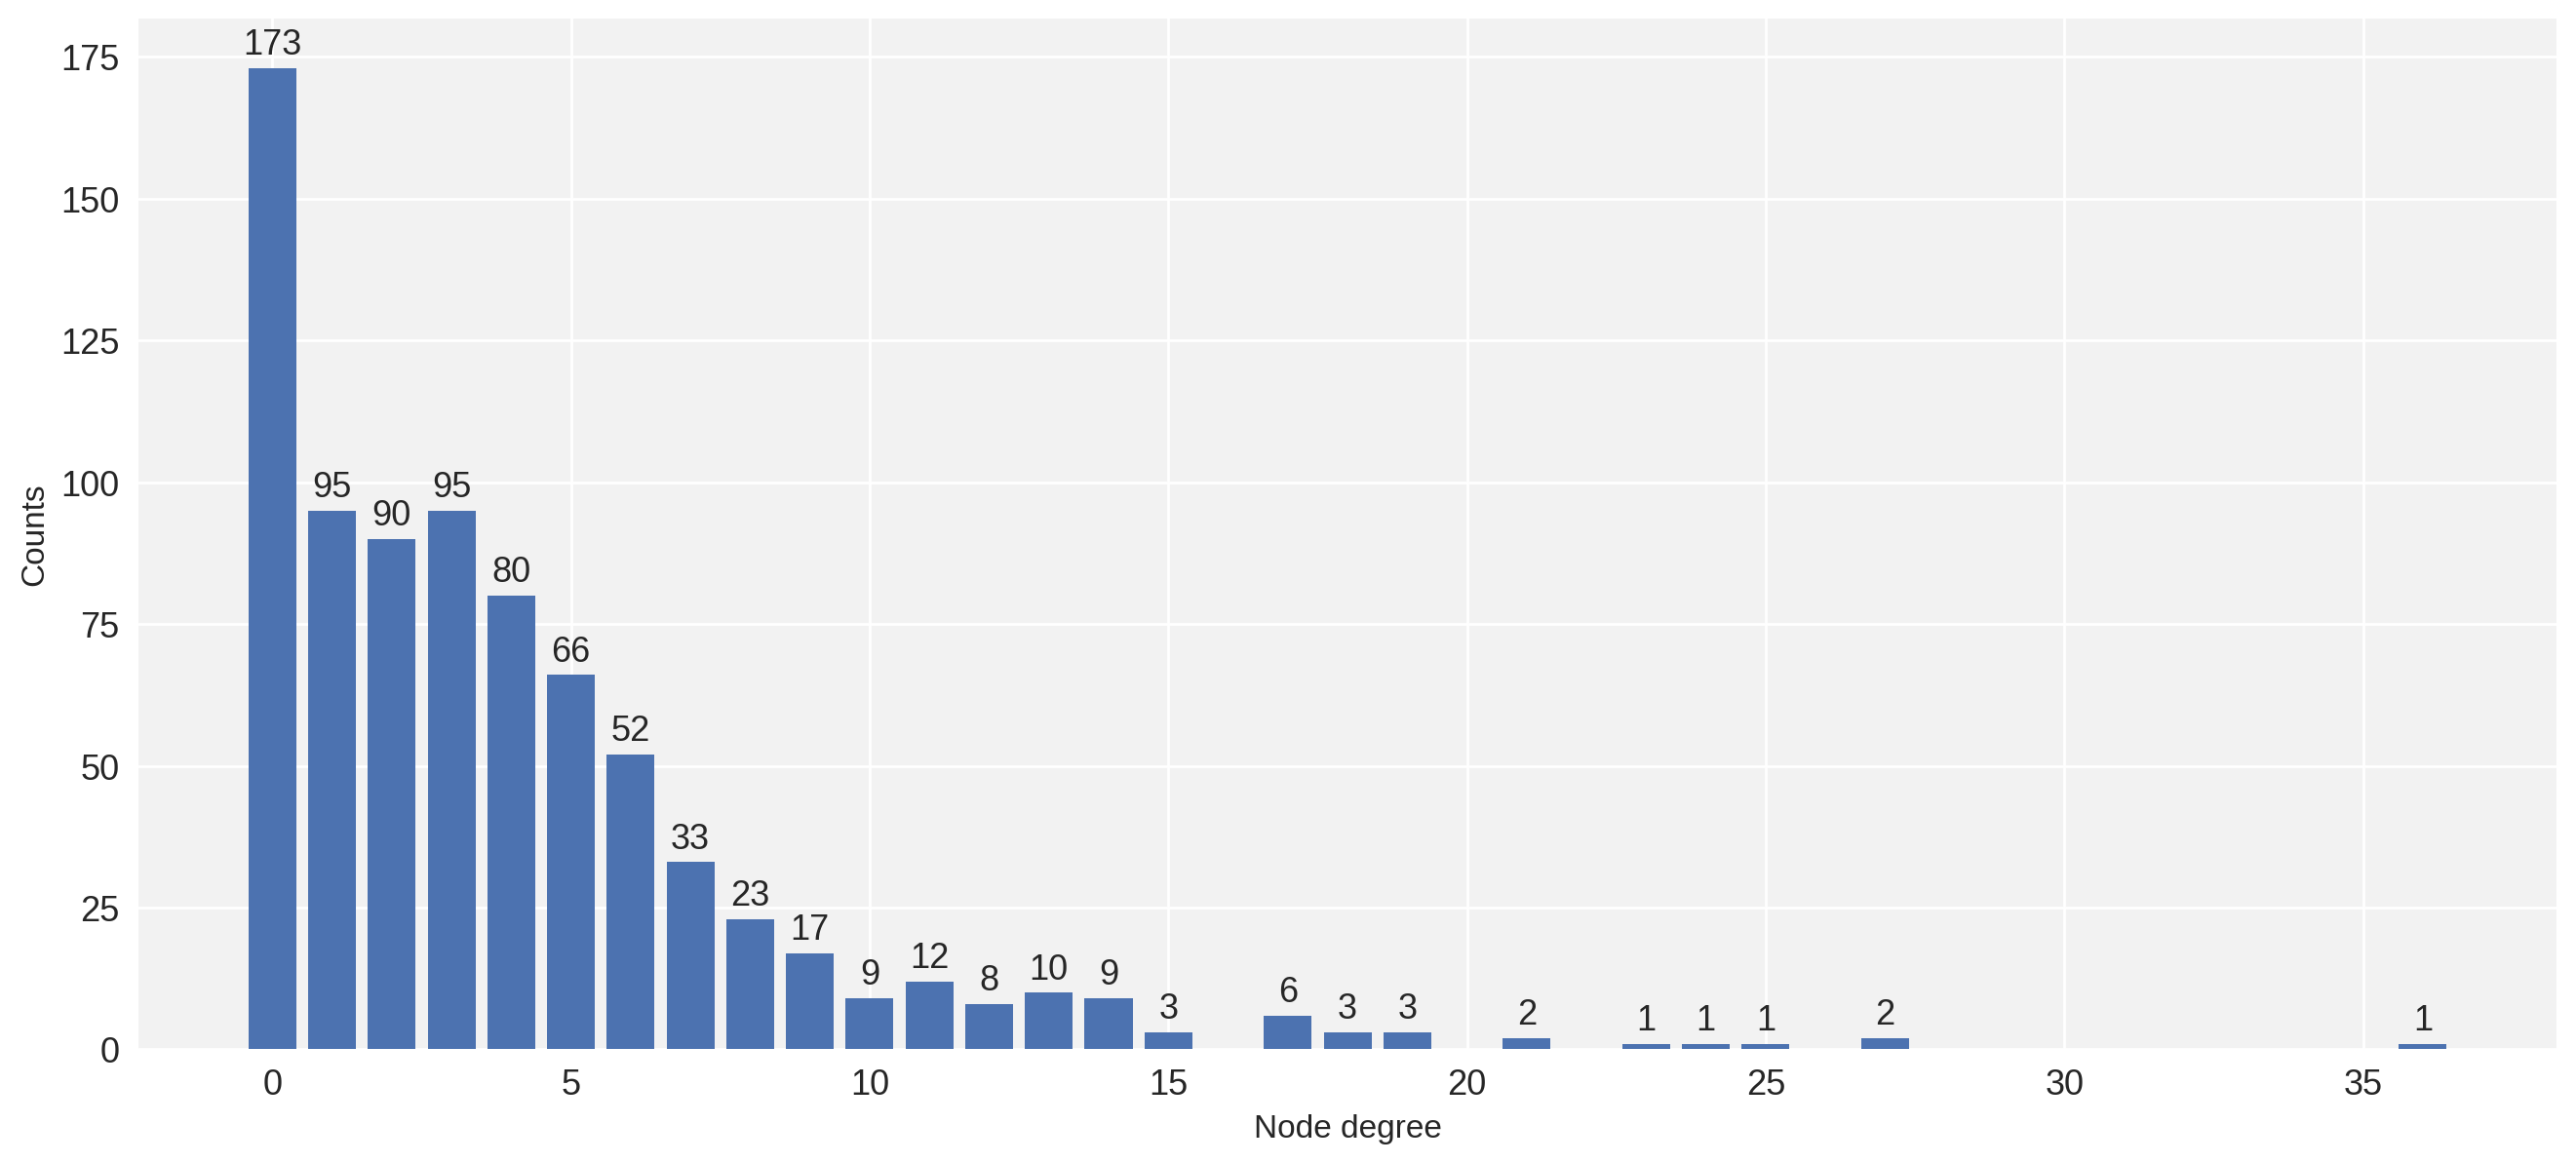

In [18]:
fig, ax = plt.subplots()
cnt = Counter(el[1] for el in g.degree())
x, y = list(zip(*((i, cnt[i]) for i in range(max(cnt)+1))))
ax.bar(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('Counts')
countsOnBarPlot(ax) 

There's a single person with _a lot_ of connections... look into him.

In [19]:
tmp = g[[n for (n, d) in g.degree() if d == max(cnt)][0]] 
tmp

{'u0073': {'weight': 193},
 'u0120': {'weight': 3},
 'u0128': {'weight': 27},
 'u0146': {'weight': 11},
 'u0150': {'weight': 48},
 'u0211': {'weight': 69},
 'u0214': {'weight': 17},
 'u0287': {'weight': 151},
 'u0311': {'weight': 4},
 'u0314': {'weight': 6},
 'u0318': {'weight': 5},
 'u0348': {'weight': 2},
 'u0392': {'weight': 24},
 'u0441': {'weight': 2},
 'u0444': {'weight': 8},
 'u0463': {'weight': 10},
 'u0477': {'weight': 20},
 'u0491': {'weight': 29},
 'u0538': {'weight': 5},
 'u0568': {'weight': 1},
 'u0607': {'weight': 13},
 'u0719': {'weight': 3},
 'u0721': {'weight': 1},
 'u0758': {'weight': 21},
 'u0796': {'weight': 20},
 'u0798': {'weight': 6},
 'u0808': {'weight': 4},
 'u0813': {'weight': 1},
 'u0844': {'weight': 2},
 'u0930': {'weight': 5},
 'u0951': {'weight': 16},
 'u0973': {'weight': 9},
 'u0981': {'weight': 6},
 'u1008': {'weight': 6},
 'u1023': {'weight': 1},
 'u1054': {'weight': 12}}

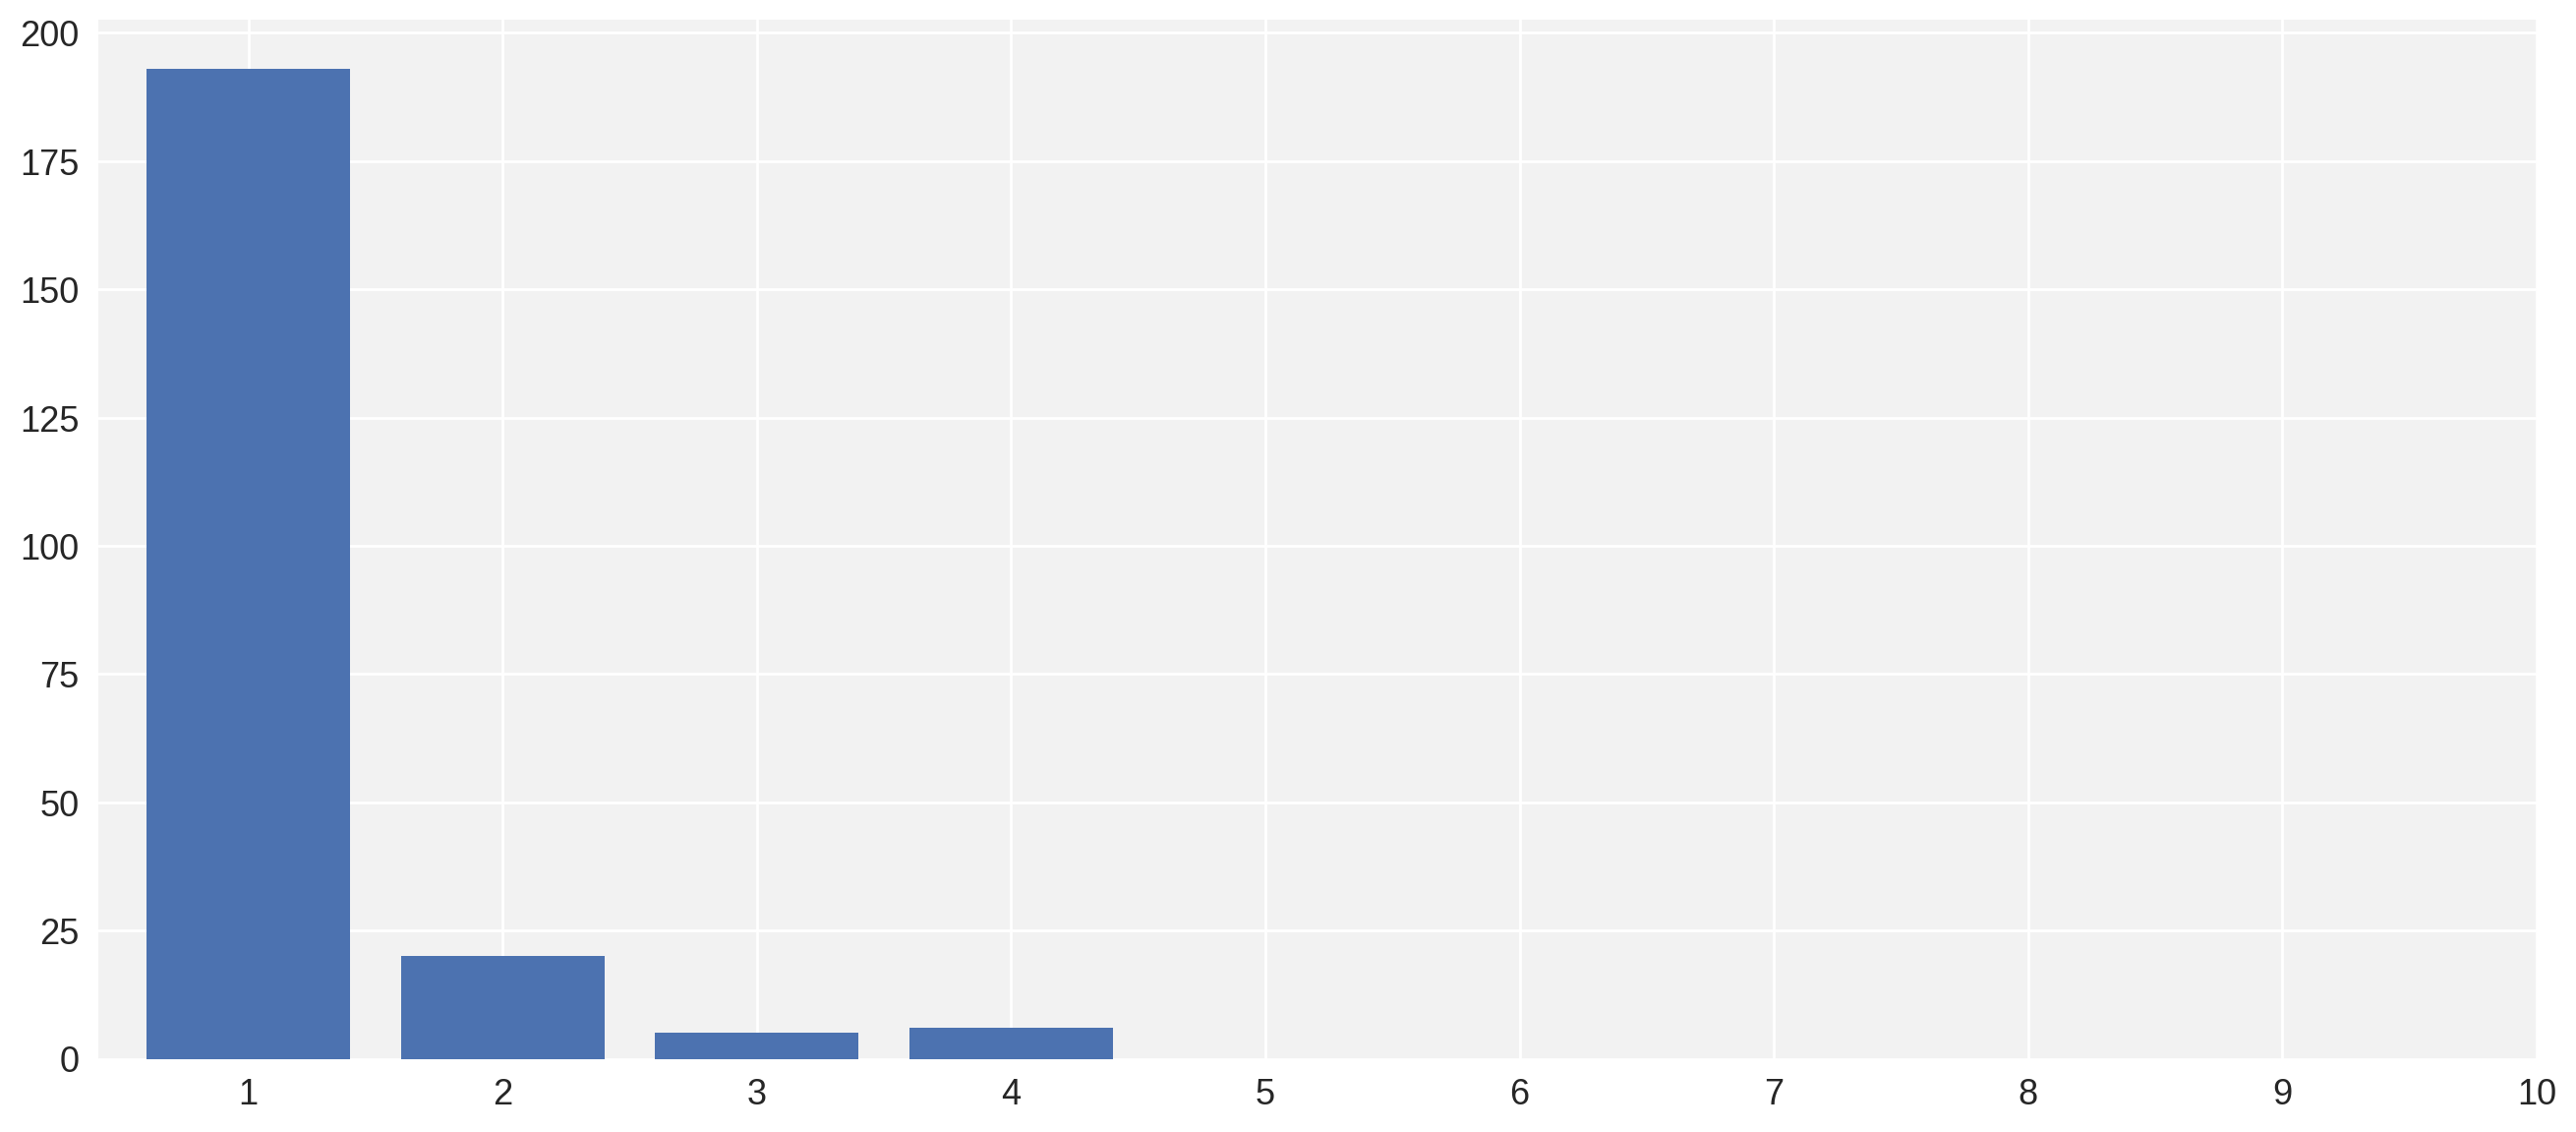

In [20]:
fig, ax = plt.subplots()
y, x = list(zip(*(Counter([tmp[node]['weight'] for node in tmp])).items()))
ax.bar(x, y)
ax.set_xticks(range(1, 11));


In [21]:
toRemove = list()
for node in g.nodes():
    connDct = g[node]
    for conn in connDct:
        if connDct[conn]['weight'] < 2:
            toRemove.append({node, conn})

In [22]:
gt = g.remove_edges_from((tuple(edge) for edge in toRemove))

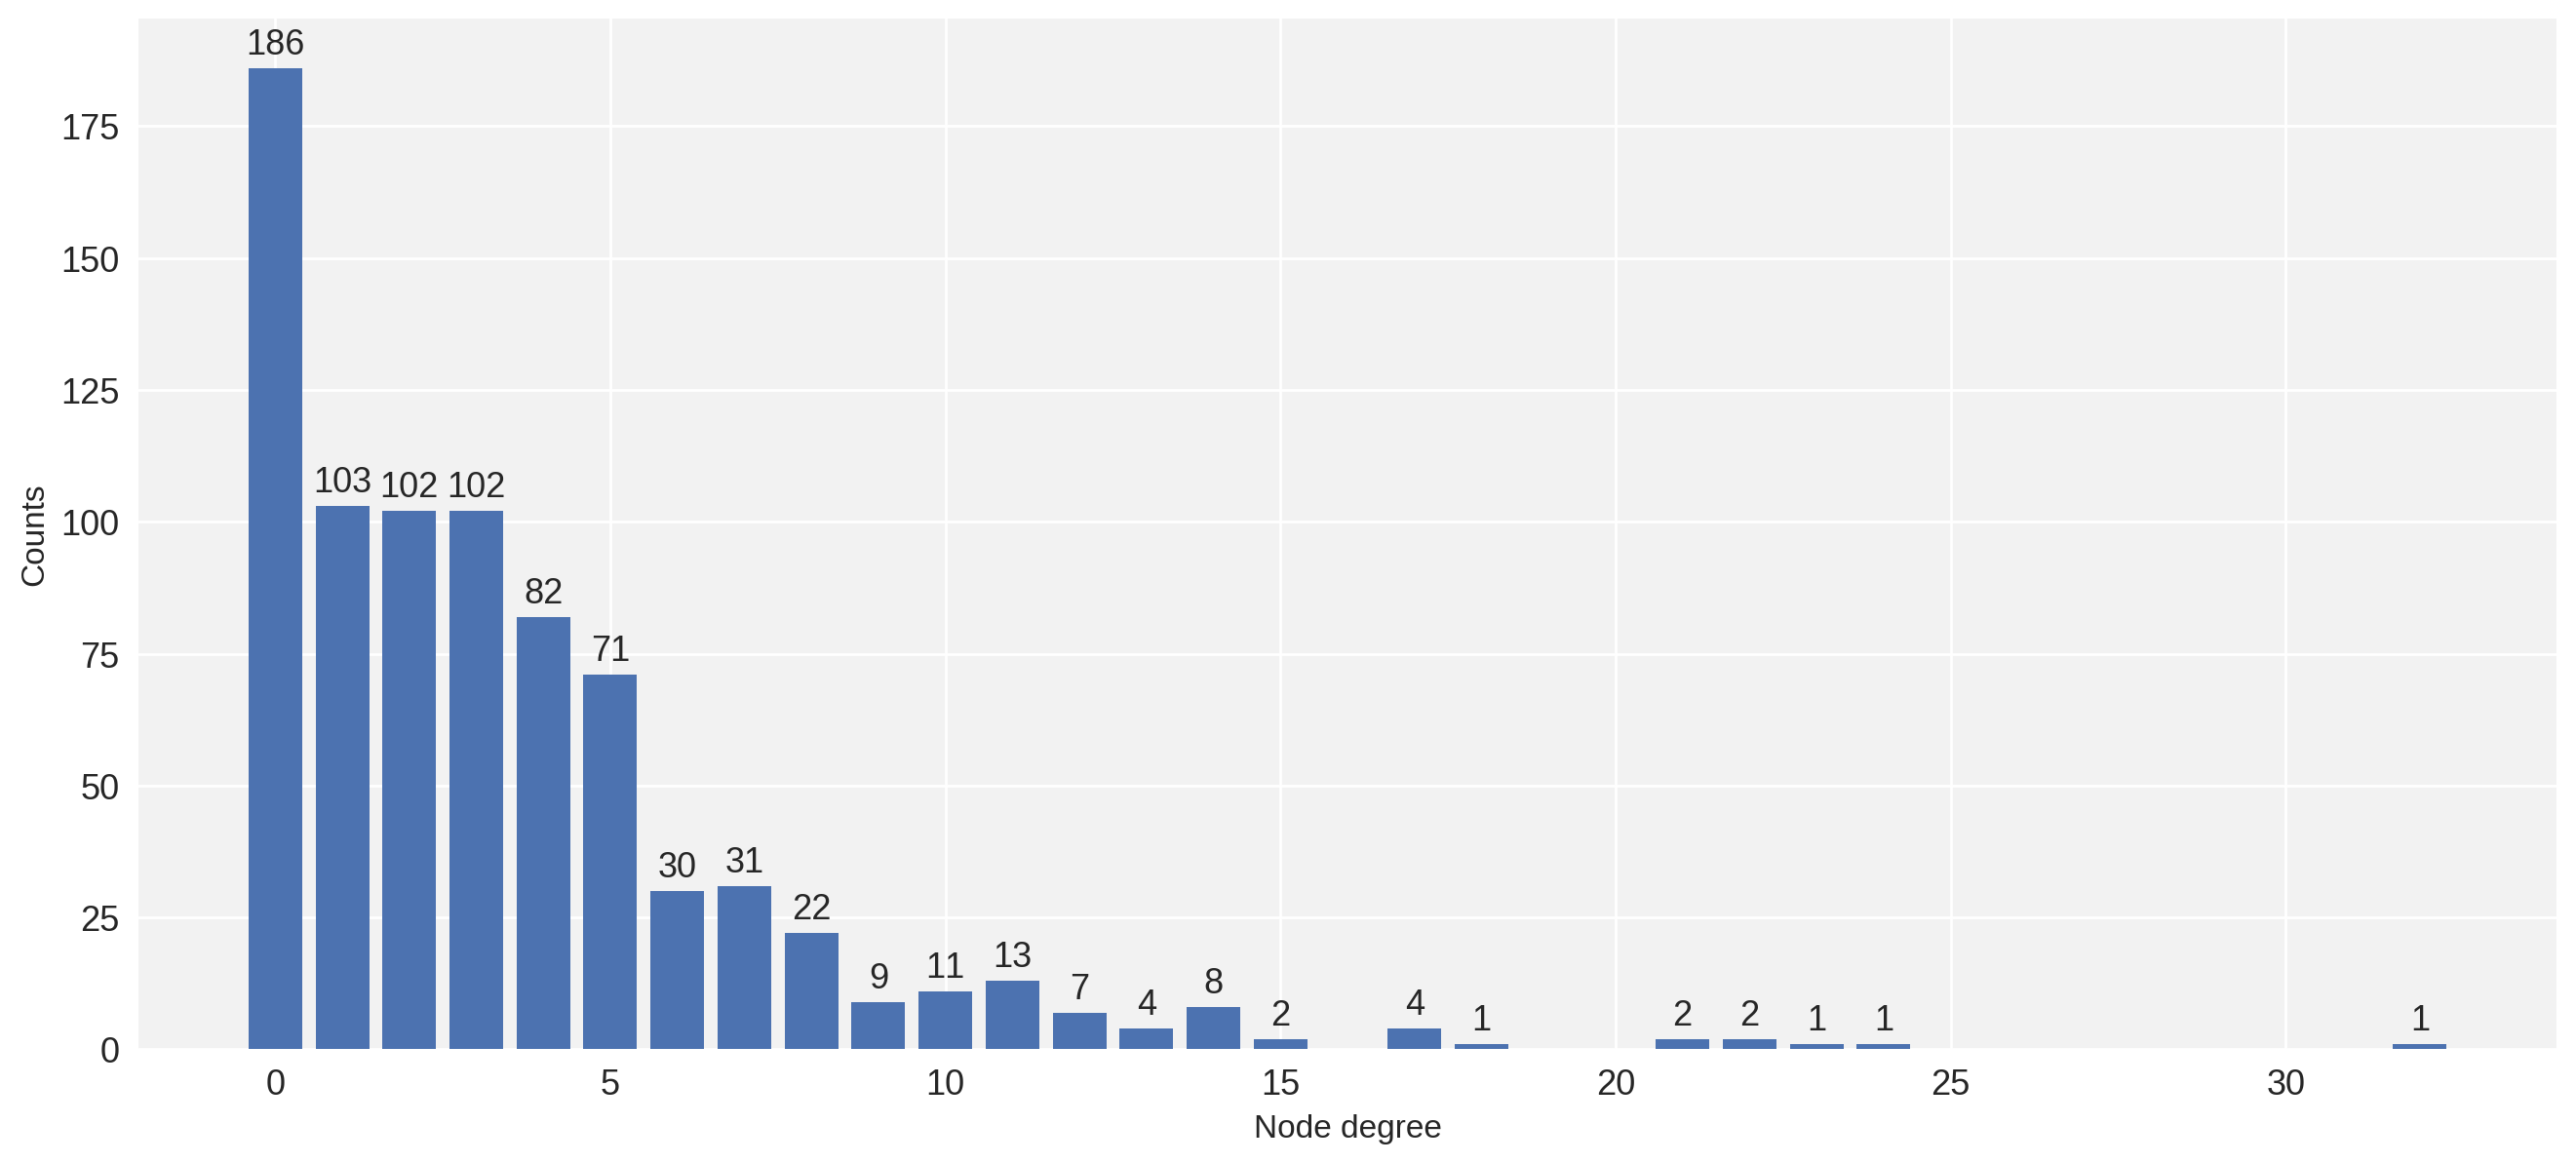

In [23]:
fig, ax = plt.subplots()
cnt = Counter(el[1] for el in g.degree())
x, y = list(zip(*((i, cnt[i]) for i in range(max(cnt)+1))))
ax.bar(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('Counts')
countsOnBarPlot(ax) 

# Clique detection

Could be used for analysis of a larger network.

Notice that requering mutual relations between nodes removes the 7-cliques.

In [24]:
gUnd = g.to_undirected(reciprocal=True)
cliqueDf = pd.DataFrame(nx.clique.find_cliques_recursive(gUnd))

cliqueDf['cliqueSize'] = cliqueDf.count(axis=1)
cliqueDf = cliqueDf.sort_values('cliqueSize', ascending=False)
cliqueDf = cliqueDf.reset_index(drop=True) 

ax = cliqueDf.cliqueSize.value_counts().sort_index().plot.bar(rot=0) 
ax.set_xlabel('Clique size') 
ax.set_ylabel('Counts') 
countsOnBarPlot(ax)

cliqueDf = cliqueDf[cliqueDf.cliqueSize > 2]

TypeError: to_undirected() got an unexpected keyword argument 'reciprocal'

# Community detection

Find communities consisting of 5-cliques with a 4 degree connection between the cliques.

[From Documentation](http://networkx.readthedocs.io/en/latest/reference/generated/networkx.algorithms.community.kclique.k_clique_communities.html#networkx.algorithms.community.kclique.k_clique_communities):

> Find $k$-clique communities in graph using the percolation method.
> 
> A $k$-clique community is the union of all cliques of size $k$ that can be reached through adjacent (sharing $k-1$ nodes) $k$-cliques.

In [ ]:
cliqueLst = [lst.dropna().tolist() for (_, lst) in cliqueDf.drop('cliqueSize', axis=1).iterrows()]
kcDf = pd.DataFrame(sorted(nx.algorithms.community.k_clique_communities(gUnd, 5, cliques=cliqueLst), key=lambda x: len(x), reverse=True))
kcDf.columns.name = 'users'
kcDf.index.name = 'communityNumber'

gsc = g.subgraph(kcDf.iloc[0])
disp(igdraw(networkx2igraph(gsc)))

kcDf['communitySize'] = kcDf.count(axis=1)
disp(kcDf.head()) 

## Choose a clique with 5 users and make a subgraph 

In [19]:
df.head() 

user comtype body  duration  hour     timeint  \
user  comtype                                                   
u0001 call     u0001    call  NaN       0.0     1  1390698006   
      call     u0001    call  NaN       0.0    14  1391176805   
      call     u0001    call  NaN      29.0    14  1391782631   
      call     u0001    call  NaN      22.0    14  1391782712   
      call     u0001    call  NaN       3.0    14  1394805935   

                        timestamp  weekday contactedUser  
user  comtype                                             
u0001 call    2014-01-26 01:00:06        6         u0493  
      call    2014-01-31 14:00:05        4         u0493  
      call    2014-02-07 14:17:11        4         u0117  
      call    2014-02-07 14:18:32        4         u0493  
      call    2014-03-14 14:05:35        4         u0117

Chosen users:
u0324
u0073
u0607
u0214
u0930


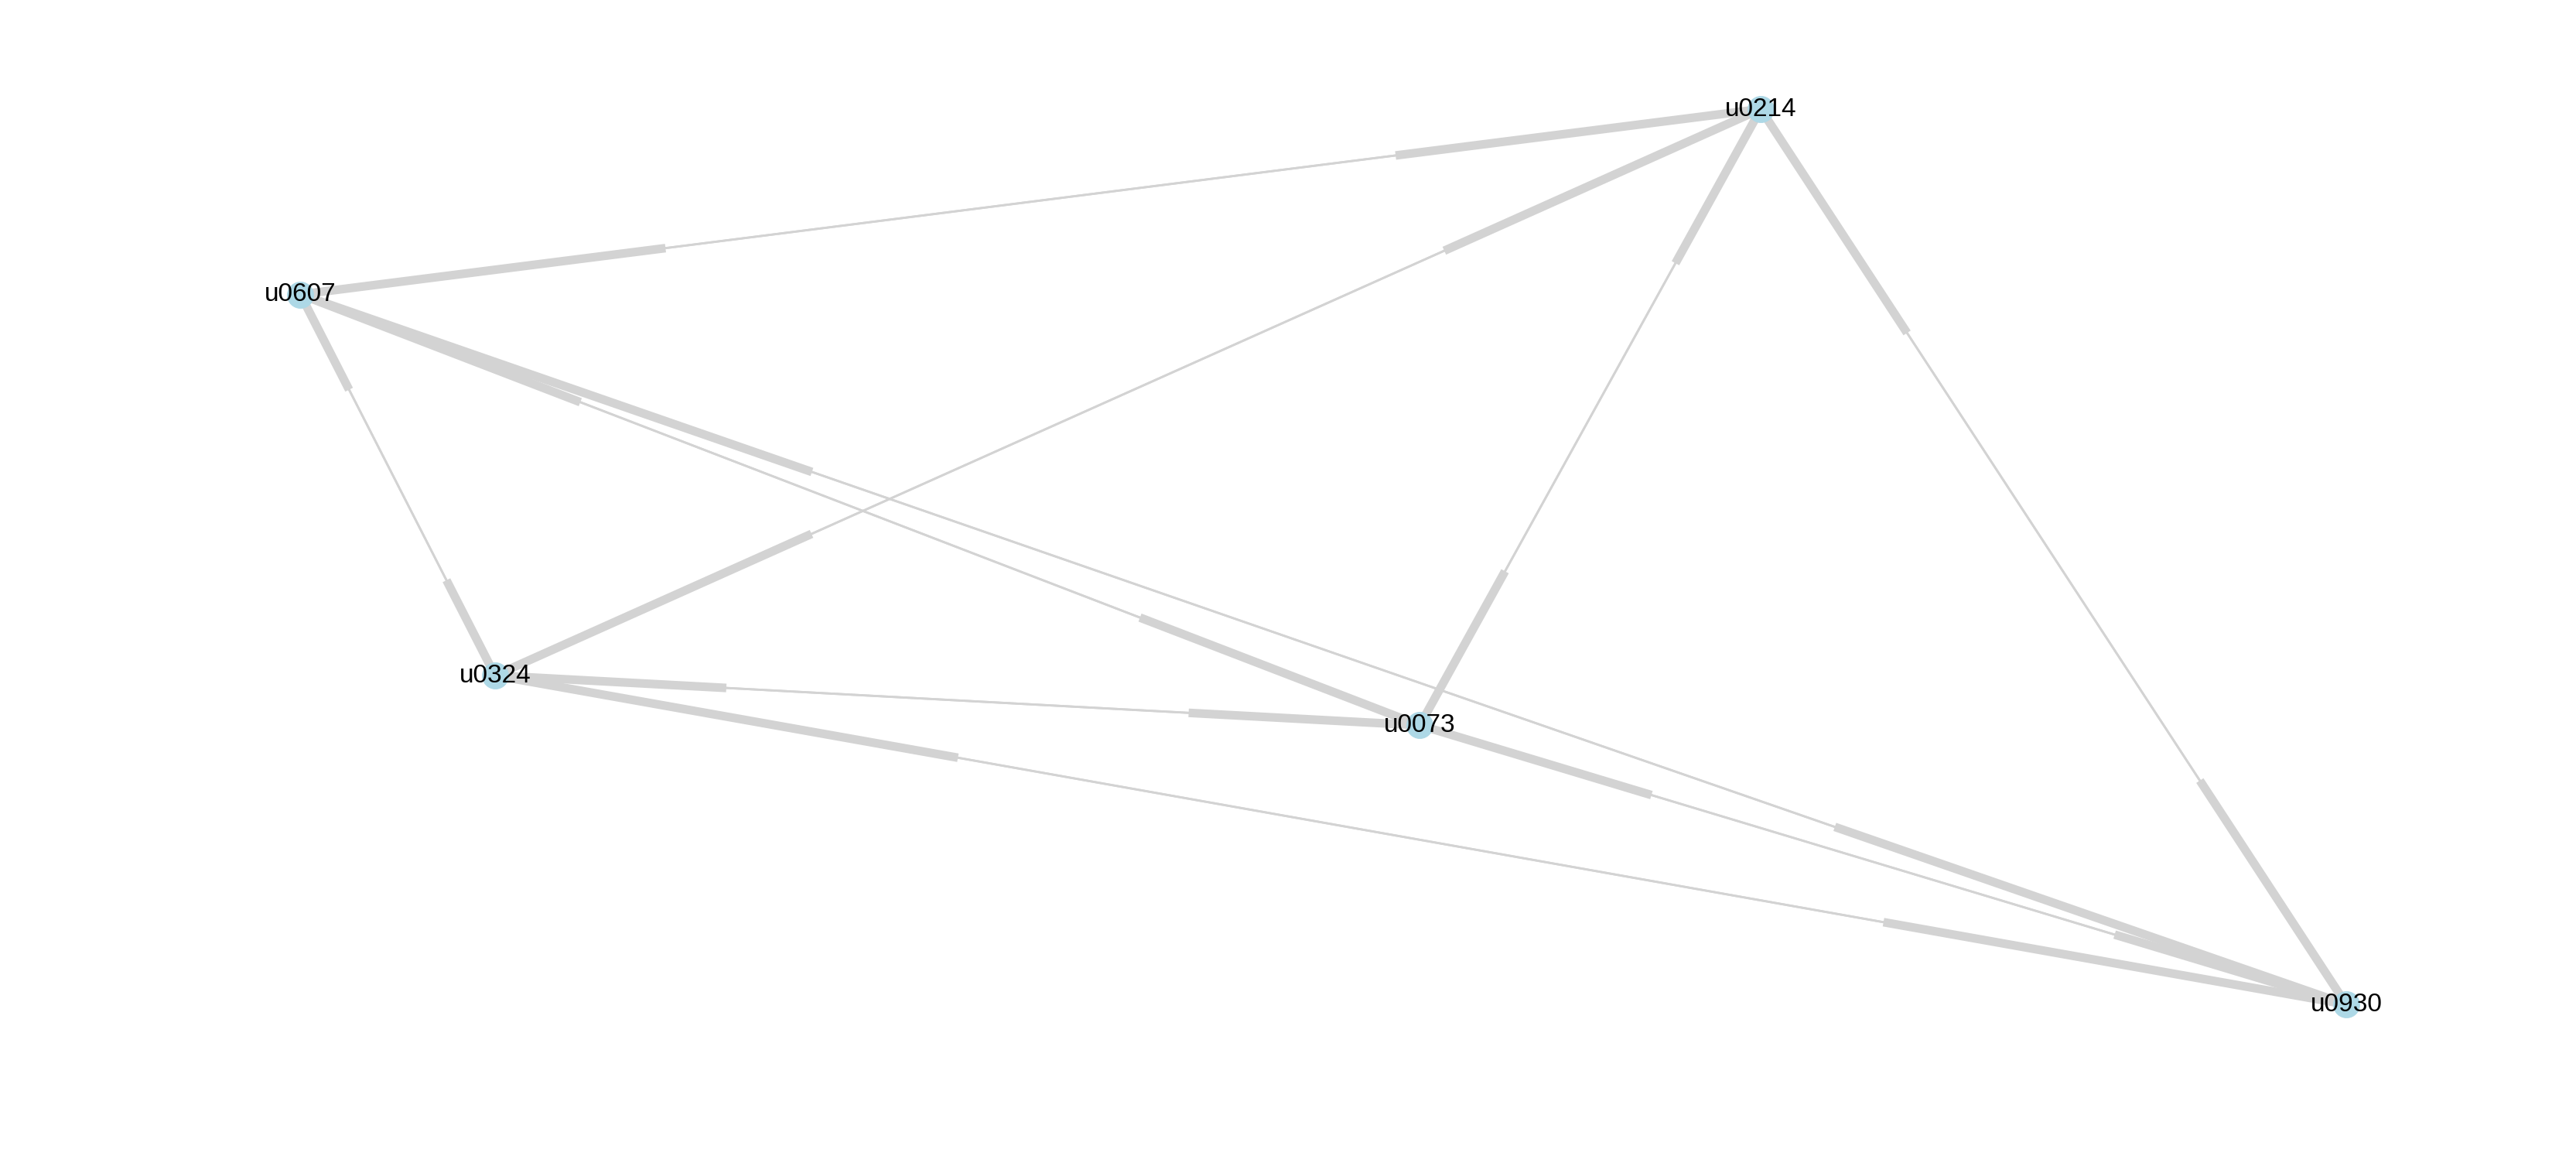

In [20]:
chosenUserLst = cliqueDf[cliqueDf.cliqueSize == 5].drop('cliqueSize', axis=1).iloc[1].dropna().tolist()
print("Chosen users:", *chosenUserLst, sep='\n') 
gs = g.subgraph(chosenUserLst)
nxQuickDraw(gs, plotSettings={'with_labels': True})

In [21]:
df.head() 

user comtype body  duration  hour     timeint  \
user  comtype                                                   
u0001 call     u0001    call  NaN       0.0     1  1390698006   
      call     u0001    call  NaN       0.0    14  1391176805   
      call     u0001    call  NaN      29.0    14  1391782631   
      call     u0001    call  NaN      22.0    14  1391782712   
      call     u0001    call  NaN       3.0    14  1394805935   

                        timestamp  weekday contactedUser  
user  comtype                                             
u0001 call    2014-01-26 01:00:06        6         u0493  
      call    2014-01-31 14:00:05        4         u0493  
      call    2014-02-07 14:17:11        4         u0117  
      call    2014-02-07 14:18:32        4         u0493  
      call    2014-03-14 14:05:35        4         u0117

Cut data to exclude time with low activity

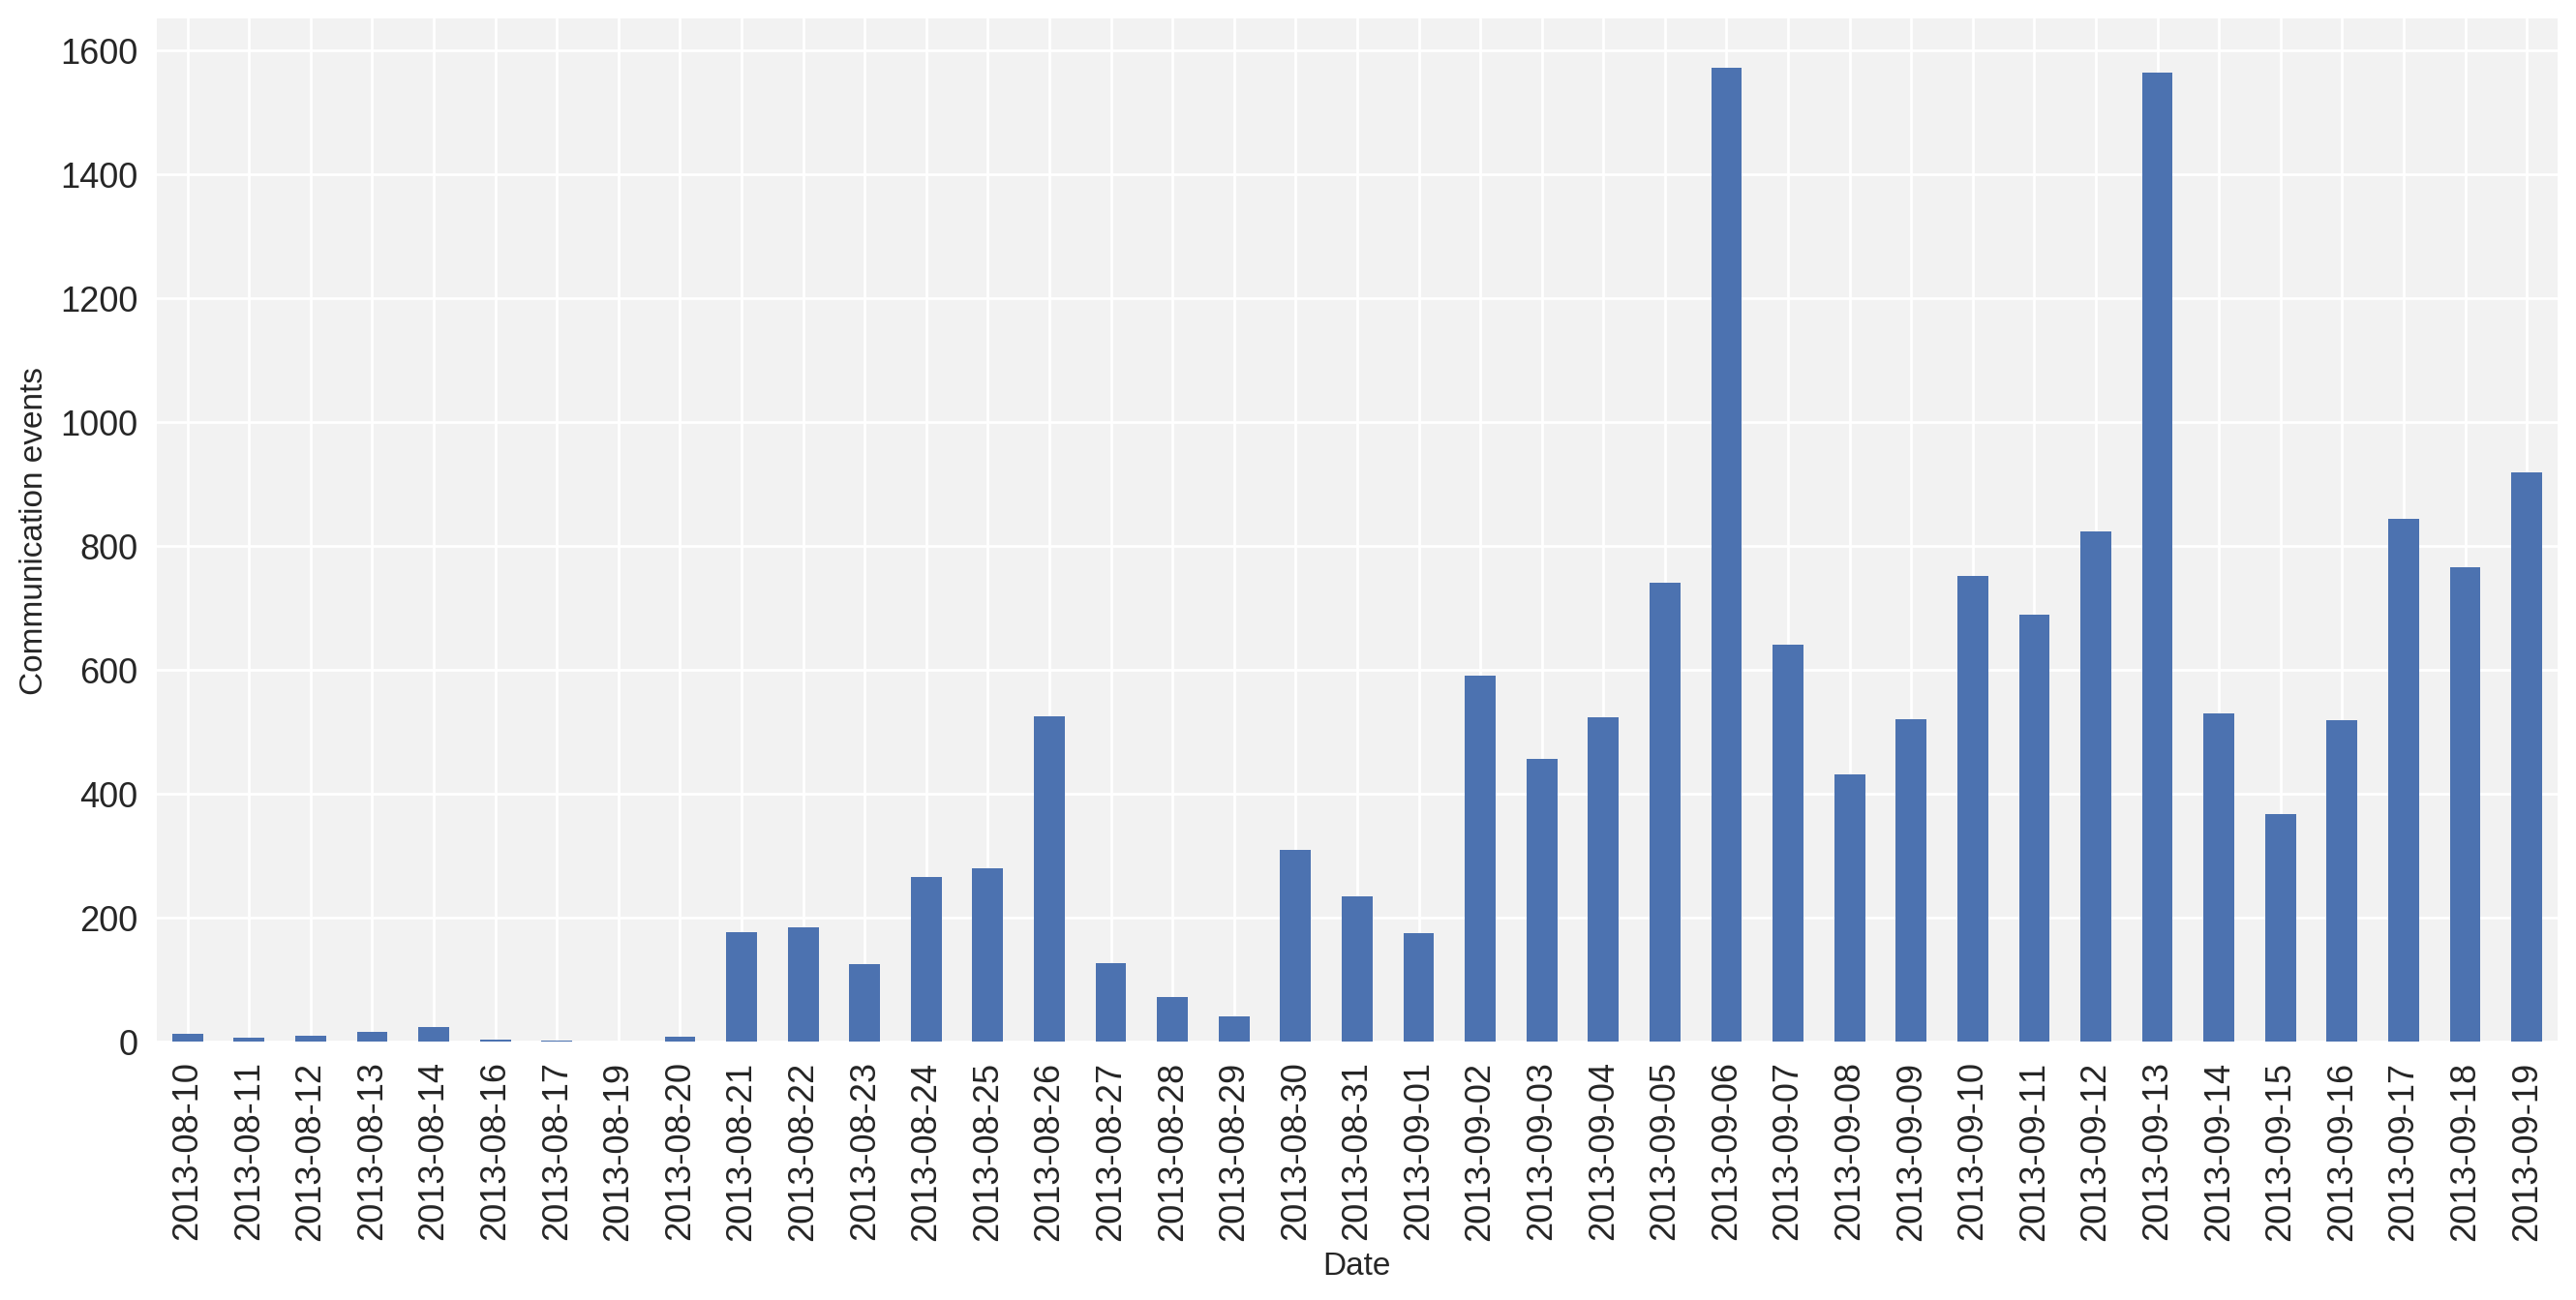

In [22]:
# tmp = df[(df.timestamp > '20130810' ) & (df.timestamp < '20130920')]
# tmp = tmp.groupby([tmp.timestamp.dt.month, tmp.timestamp.dt.day]).timeint.count()
# ax = tmp.plot.bar() 

#       Cut DataFrame to chosen time interval                           Count on the date                Sort by date and plot it
ax = df[(df.timestamp > '2013-08-10' ) & (df.timestamp < '2013-09-20')].timestamp.dt.date.value_counts().sort_index().plot.bar()
ax.set_xlabel('Date')
ax.set_ylabel('Communication events') 

Seems like the useage spiked around 21/08/2013. 

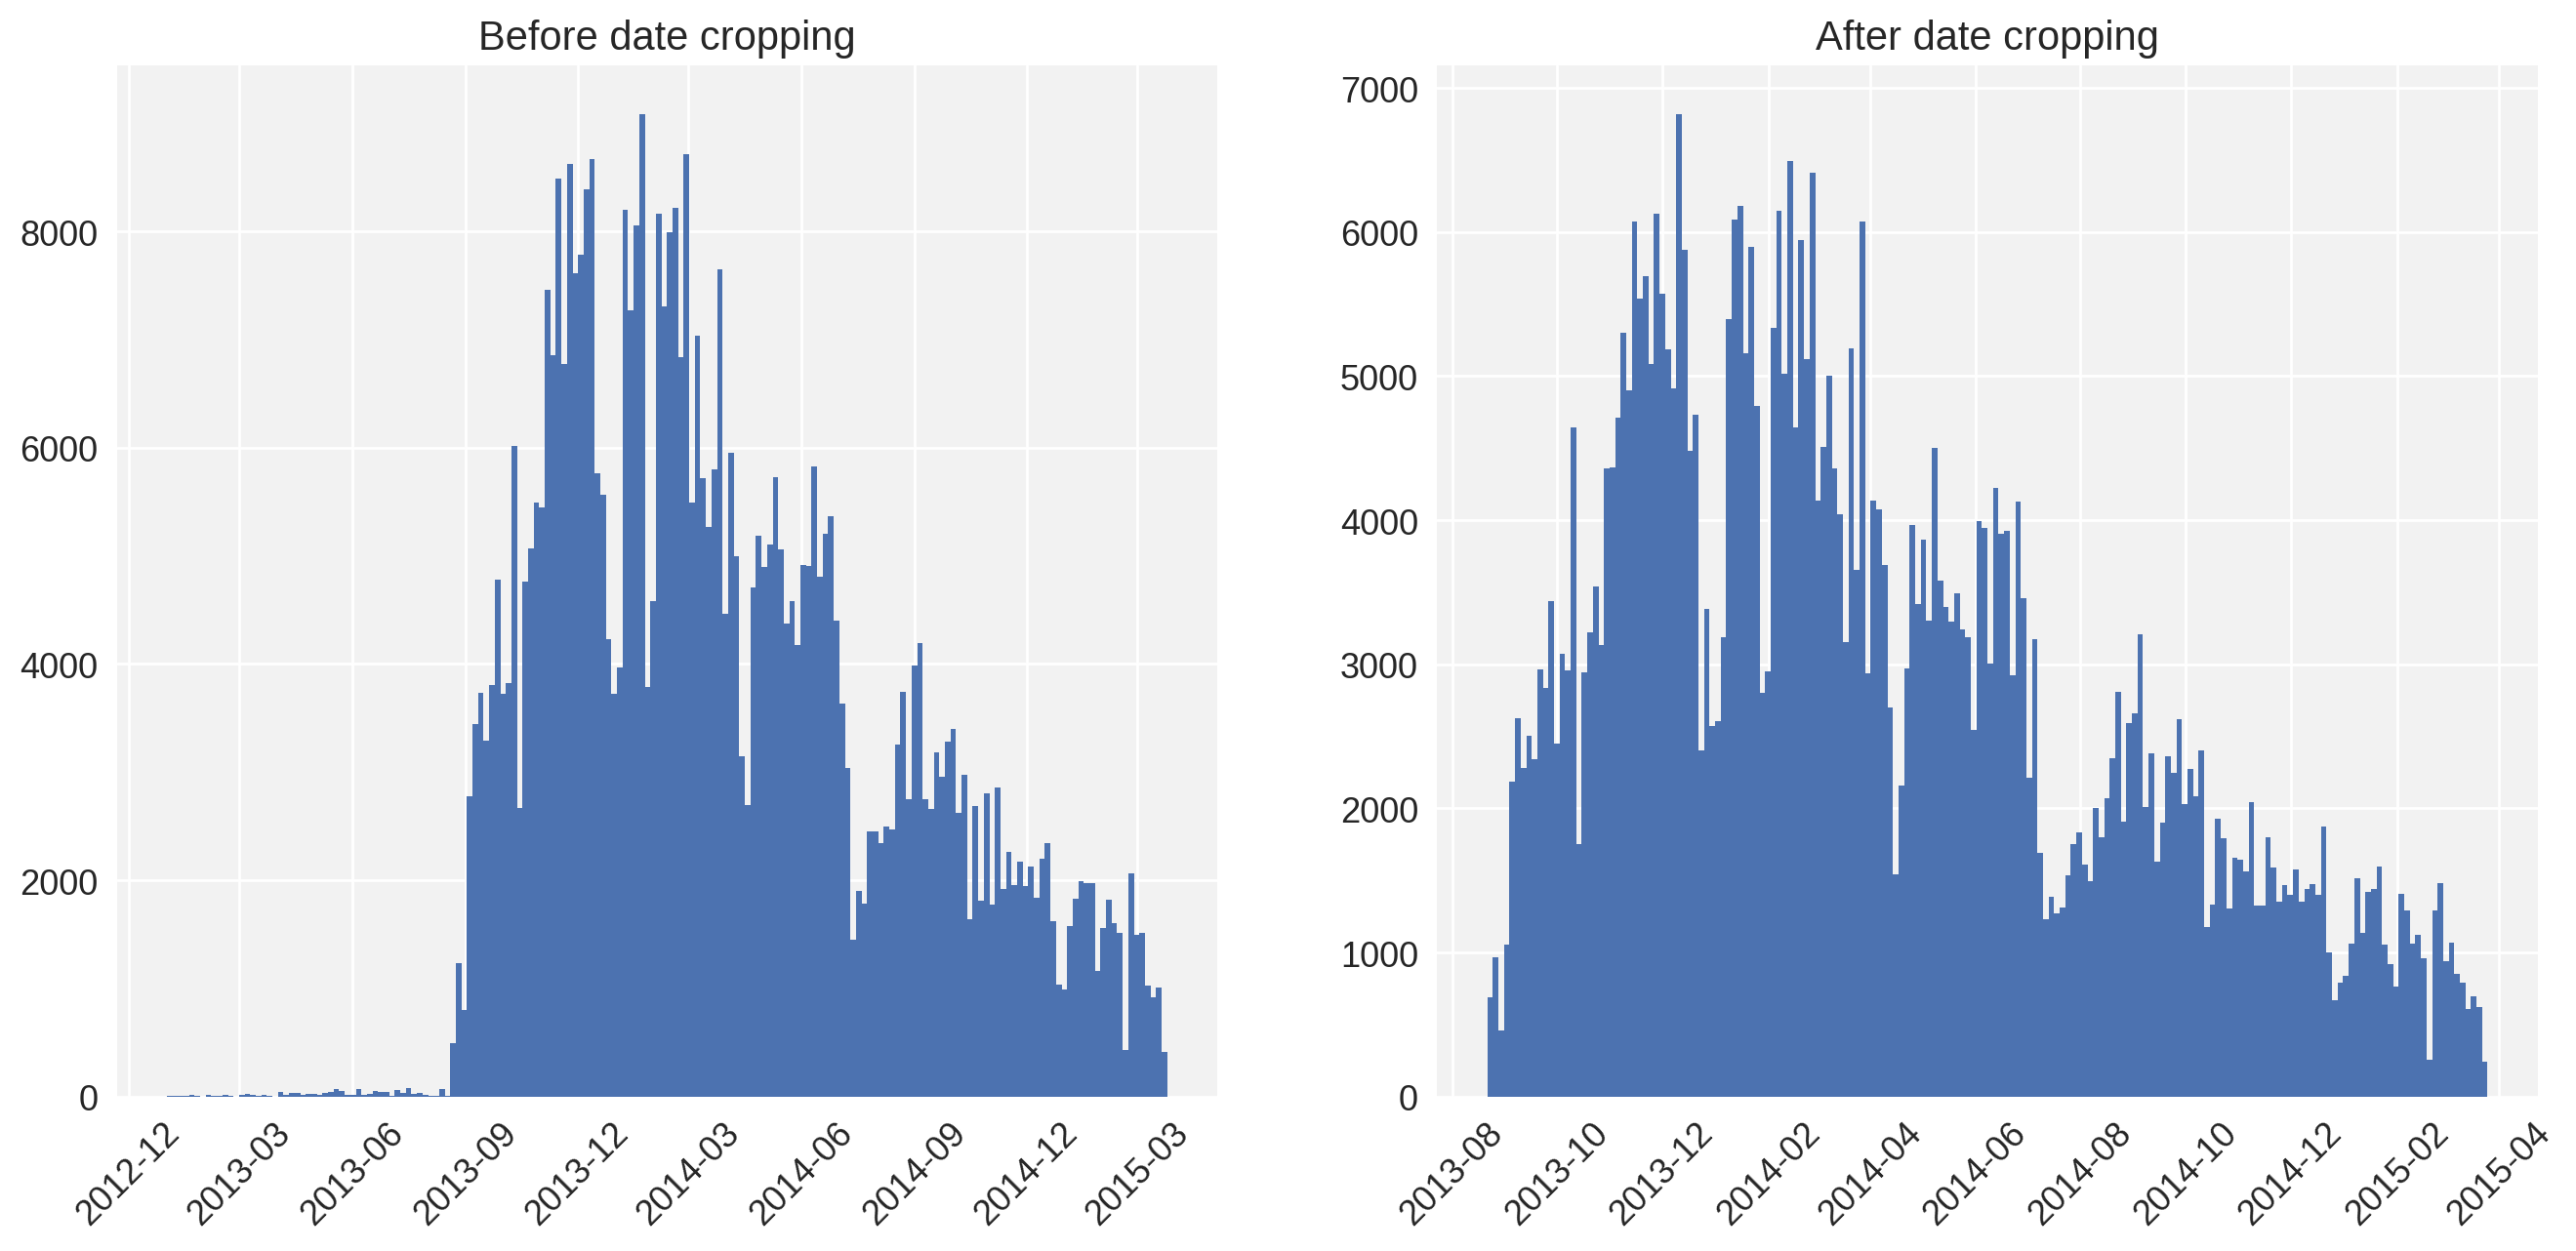

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2)
df.timestamp.hist(bins=180, ax=ax0, xrot=45)  
ax0.set_title('Before date cropping')
df = df[df.timestamp > '2013-08-21']
df.timestamp.hist(bins=180, ax=ax1, xrot=45) 
ax1.set_title('After date cropping')

### Determine start time offset for the binning 

Find the first occuring communication...

In [24]:
t0 = df.timestamp.min()
t0

Timestamp('2013-08-21 10:40:29')

…and choose the corresponding day...

In [25]:
t0d = pd.Timestamp(t0.date())
t0d

Timestamp('2013-08-21 00:00:00')

Since the timeint is in seconds, but Pandas keeps it's records in nanoseconds, the integer representation of the date needs to be divided by 1e9.

To check that this is indeed true, compare the values of the integer casted `t0` to the timeint for the corresponding row:

In [26]:
np.int64(t0.value // 1e9) == df.loc[df.timestamp.idxmin()].timeint.values[0]

True

Since it was true, use the following for the bin time start

In [27]:
t0d = np.int64(t0d.value // 1e9)
t0 = np.int64(t0.value // 1e9) 
t0d

1377043200

Binning is simply performed by integer division with a suiting bin width.
I choose 8 hours:

In [28]:
bw8h = 60**2*8
df['tbin'] = (df.timeint - t0d) // bw8h
df.head()

user comtype body  duration  hour     timeint  \
user  comtype                                                   
u0001 call     u0001    call  NaN       0.0     1  1390698006   
      call     u0001    call  NaN       0.0    14  1391176805   
      call     u0001    call  NaN      29.0    14  1391782631   
      call     u0001    call  NaN      22.0    14  1391782712   
      call     u0001    call  NaN       3.0    14  1394805935   

                        timestamp  weekday contactedUser  tbin  
user  comtype                                                   
u0001 call    2014-01-26 01:00:06        6         u0493   474  
      call    2014-01-31 14:00:05        4         u0493   490  
      call    2014-02-07 14:17:11        4         u0117   511  
      call    2014-02-07 14:18:32        4         u0493   511  
      call    2014-03-14 14:05:35        4         u0117   616

In [29]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
cliqueDf   DataFrame             0      1      2 <...>n\n[953 rows x 8 columns]
df         DataFrame                    user comt<...>508466 rows x 10 columns]
kcDf       DataFrame    users                0   <...>n\n[32 rows x 23 columns]


Sample one clique of each size

In [30]:
ccdfs = pd.DataFrame([cliqueDf[cliqueDf.cliqueSize == i].iloc[0] for i in cliqueDf.cliqueSize.unique()])
ccdfs

,0,1,2,3,4,5,6,cliqueSize
0,u0324,u0392,u0073,u0211,u0930,u0146,u0503,7
2,u0324,u0287,u0758,u0128,u0813,u0444,None,6
23,u0324,u0392,u0073,u0211,u0122,None,None,5
92,u1016,u0555,u0942,u0663,None,None,None,4
372,u0965,u0499,u0208,None,None,None,None,3


In [31]:
ccdf = cliqueDf[cliqueDf.cliqueSize == 5].iloc[:8] 
ccdf

,0,1,2,3,4,5,6,cliqueSize
23,u0324,u0392,u0073,u0211,u0122,None,None,5
24,u0493,u0392,u0117,u0122,u0739,None,None,5
25,u0324,u0287,u0477,u0128,u0444,None,None,5
26,u0324,u0287,u0477,u0128,u0951,None,None,5
27,u0324,u0287,u0758,u0441,u0444,None,None,5
28,u0324,u0287,u0758,u0441,u1023,None,None,5
29,u0241,u0392,u0122,u0612,u0211,None,None,5
30,u0241,u0392,u0122,u0493,u0739,None,None,5


In [32]:
dct = communityDf2Pca(df, ccdfs, 'tbin', graphtype=nx.DiGraph) 

In [33]:
dct

{('u0324',
  'u0287',
  'u0758',
  'u0128',
  'u0813',
  'u0444'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u0324',
  'u0392',
  'u0073',
  'u0211',
  'u0122'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u0324',
  'u0392',
  'u0073',
  'u0211',
  'u0930',
  'u0146',
  'u0503'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u0965',
  'u0499',
  'u0208'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u1016',
  'u0555',
  'u0942',
  'u0663'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)}

In [34]:
key = list(dct.keys())[0]
pca = dct[key]
disp(key, pca, pca.components_.shape, pca.components_[:, :3])  # three most dominant components

('u0324', 'u0392', 'u0073', 'u0211', 'u0930', 'u0146', 'u0503')

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(49, 1741)

array([[  8.90554281e-17,   4.84203506e-02,   1.10620041e-01],
       [ -2.97322638e-17,   1.74499290e-01,  -5.82049145e-03],
       [  4.01449141e-17,   2.24071600e-02,  -1.73822298e-03],
       [  9.92394679e-17,  -4.65010516e-02,  -1.19019916e-03],
       [ -1.60973018e-16,  -1.00260346e-02,   9.12044978e-03],
       [ -3.81876463e-16,  -3.84785159e-02,   2.06004902e-03],
       [ -1.61014765e-16,  -3.04098822e-02,  -6.82886287e-04],
       [  1.35356704e-16,   1.72407344e-01,  -5.03929544e-04],
       [ -9.38970934e-18,   2.37404886e-02,  -4.86975011e-03],
       [ -1.26057163e-16,   9.59224246e-04,  -2.43860026e-03],
       [  6.17170805e-17,   2.71022450e-03,  -9.27363846e-05],
       [ -5.65422192e-17,   3.18802032e-02,  -4.21166251e-04],
       [  6.87252221e-17,  -2.65132038e-02,   1.29147793e-03],
       [ -1.34346788e-16,  -1.70324814e-04,   3.38491898e-04],
       [ -1.06859309e-16,  -3.87392431e-03,   4.95643069e-04],
       [ -2.81294013e-16,   6.26869358e-04,  -1.1778756

In [35]:
def usernames2nameMatrix(usernameLst):
    usernameLst = list(usernameLst) 
    n = len(usernameLst)
    uArr = np.NaN*np.ones(shape=(n, n), dtype=object)
    for i, ui in enumerate(usernameLst):
        for j, uj in enumerate(usernameLst):
            if i != j:
                uArr[i, j] = (ui, uj)
    return uArr

for _, row in ccdfs.iterrows():
    key = row[:-1].dropna().tolist()
    print(key)
    print('\n\n')
    print(usernames2nameMatrix(key))
    print('\n\n\n---------------------------------------------------\n\n\n')

['u0324', 'u0392', 'u0073', 'u0211', 'u0930', 'u0146', 'u0503']



[[nan ('u0324', 'u0392') ('u0324', 'u0073') ('u0324', 'u0211') ('u0324', 'u0930') ('u0324', 'u0146') ('u0324', 'u0503')]
 [('u0392', 'u0324') nan ('u0392', 'u0073') ('u0392', 'u0211') ('u0392', 'u0930') ('u0392', 'u0146') ('u0392', 'u0503')]
 [('u0073', 'u0324') ('u0073', 'u0392') nan ('u0073', 'u0211') ('u0073', 'u0930') ('u0073', 'u0146') ('u0073', 'u0503')]
 [('u0211', 'u0324') ('u0211', 'u0392') ('u0211', 'u0073') nan ('u0211', 'u0930') ('u0211', 'u0146') ('u0211', 'u0503')]
 [('u0930', 'u0324') ('u0930', 'u0392') ('u0930', 'u0073') ('u0930', 'u0211') nan ('u0930', 'u0146') ('u0930', 'u0503')]
 [('u0146', 'u0324') ('u0146', 'u0392') ('u0146', 'u0073') ('u0146', 'u0211') ('u0146', 'u0930') nan ('u0146', 'u0503')]
 [('u0503', 'u0324') ('u0503', 'u0392') ('u0503', 'u0073') ('u0503', 'u0211') ('u0503', 'u0930') ('u0503', 'u0146') nan]]



---------------------------------------------------



['u0324', 'u0287', 'u0758',

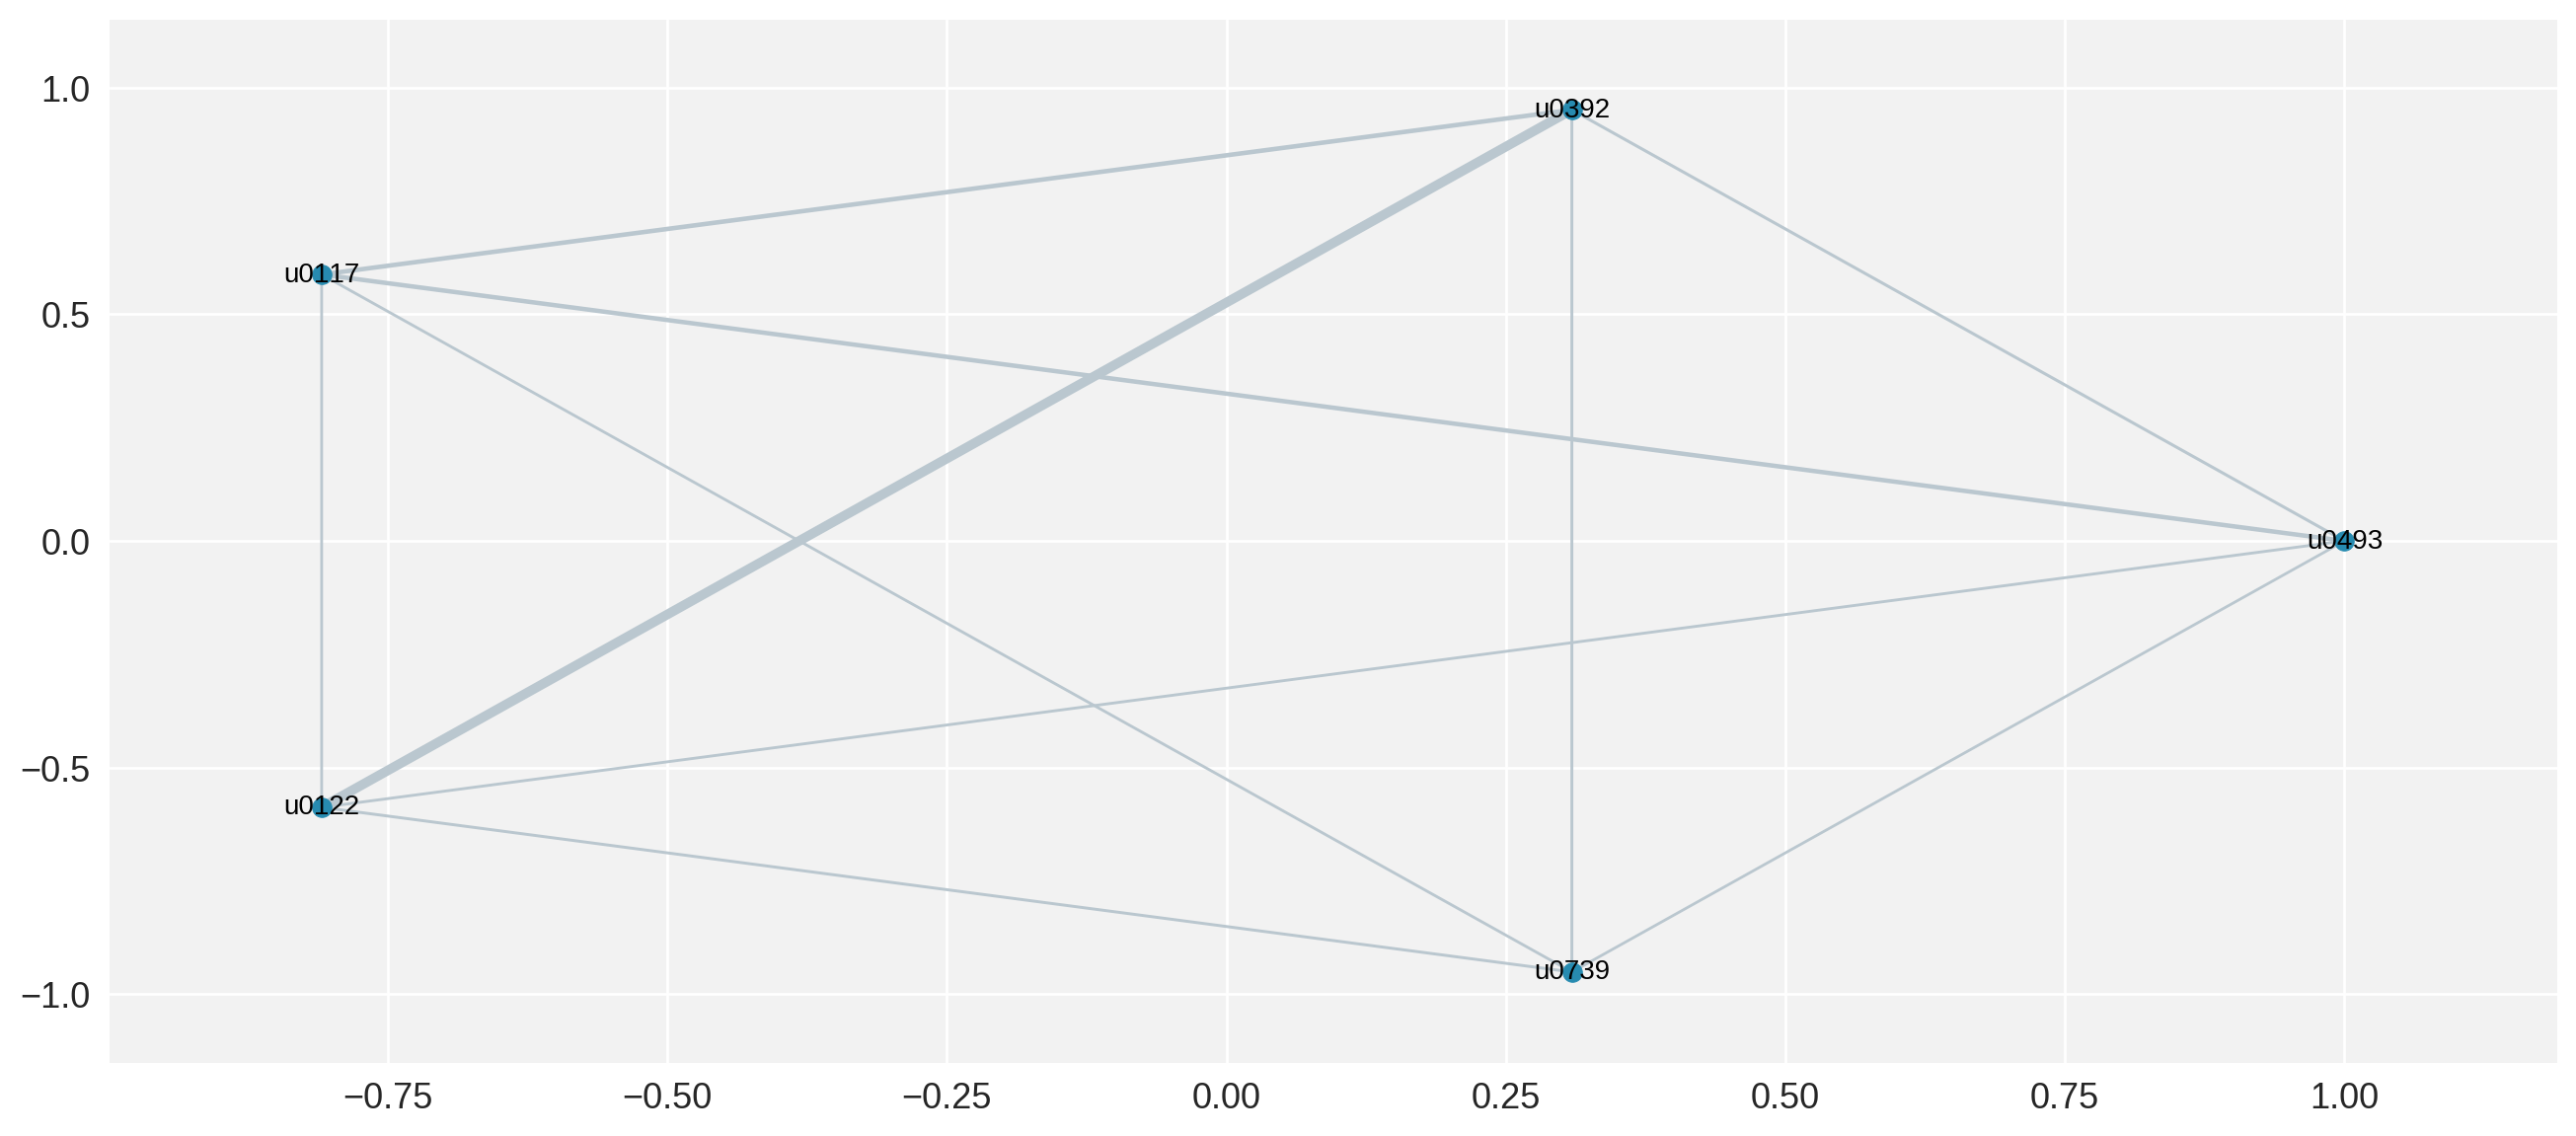

In [36]:
drawWeightedGraph(gs, layout=nx.drawing.layout.circular_layout)

In [37]:
list(gs.nodes())

['u0493', 'u0392', 'u0117', 'u0122', 'u0739']

In [38]:
nx.get_edge_attributes(gs, 'weight')

{('u0117', 'u0122'): 4,
 ('u0117', 'u0739'): 8,
 ('u0122', 'u0739'): 20,
 ('u0392', 'u0117'): 205,
 ('u0392', 'u0122'): 788,
 ('u0392', 'u0739'): 15,
 ('u0493', 'u0117'): 197,
 ('u0493', 'u0122'): 10,
 ('u0493', 'u0392'): 31,
 ('u0493', 'u0739'): 1}

In [39]:
adjmat = nx.adjacency_matrix(gs).todense() 
adjmat

matrix([[  0,  31, 197,  10,   1],
        [ 31,   0, 205, 788,  15],
        [197, 205,   0,   4,   8],
        [ 10, 788,   4,   0,  20],
        [  1,  15,   8,  20,   0]], dtype=int64)

In [40]:
dfg = pd.DataFrame(nx.adjacency_matrix(gs).todense(), columns=gs.nodes(), index=gs.nodes())
dfg

,u0493,u0392,u0117,u0122,u0739
u0493,0,31,197,10,1
u0392,31,0,205,788,15
u0117,197,205,0,4,8
u0122,10,788,4,0,20
u0739,1,15,8,20,0


In [41]:
dfg2 = pd.DataFrame(np.zeros((5, 5), dtype=int), columns=gs.nodes(), index=gs.nodes())
for ed, wt in nx.get_edge_attributes(gs, 'weight').items():
    dfg2.loc[ed[0], ed[1]] = wt
    dfg2.loc[ed[1], ed[0]] = wt
dfg2

,u0493,u0392,u0117,u0122,u0739
u0493,0,31,197,10,1
u0392,31,0,205,788,15
u0117,197,205,0,4,8
u0122,10,788,4,0,20
u0739,1,15,8,20,0


In [42]:
(dfg2 == dfg).values.all() 

True

In [43]:
upperTril2adjMat(np.squeeze(np.array(adjMatUpper2array(adjmat))))

array([[  0,  31, 197,  10,   1],
       [ 31,   0, 205, 788,  15],
       [197, 205,   0,   4,   8],
       [ 10, 788,   4,   0,  20],
       [  1,  15,   8,  20,   0]], dtype=int64)

In [44]:
upperTril2adjMat(adjMatUpper2array(usernames2nameMatrix(gs.nodes())))

array([[None, ('u0493', 'u0392'), ('u0493', 'u0117'), ('u0493', 'u0122'), ('u0493', 'u0739')],
       [('u0493', 'u0392'), None, ('u0392', 'u0117'), ('u0392', 'u0122'), ('u0392', 'u0739')],
       [('u0493', 'u0117'), ('u0392', 'u0117'), None, ('u0117', 'u0122'), ('u0117', 'u0739')],
       [('u0493', 'u0122'), ('u0392', 'u0122'), ('u0117', 'u0122'), None, ('u0122', 'u0739')],
       [('u0493', 'u0739'), ('u0392', 'u0739'), ('u0117', 'u0739'), ('u0122', 'u0739'), None]], dtype=object)

In [45]:
list(gs.edges())

[('u0493', 'u0392'),
 ('u0493', 'u0117'),
 ('u0493', 'u0122'),
 ('u0493', 'u0739'),
 ('u0392', 'u0117'),
 ('u0392', 'u0122'),
 ('u0392', 'u0739'),
 ('u0117', 'u0122'),
 ('u0117', 'u0739'),
 ('u0122', 'u0739')]

In [46]:
# evr = pca.explained_variance_ratio_
# n = (np.cumsum(evr) <= evr.sum()*0.98).sum()  # number of vectors need for 98 % explanation of variance (?)
# firstN = np.abs(pca.components_[:, :n])
# 
# fig, ax = plt.subplots()
# pc = ax.pcolorfast(pca.components_[:, :n], cmap='RdBu_r', vmin=-np.abs(firstN).max(), vmax=np.abs(firstN).max())
# fig.colorbar(pc) 
# 
# firstN += firstN.min()
# firstN[firstN < 1e-6] = 0.0
# firstN /= firstN.sum()
# firstN *= n
# graphLst = [nx.from_numpy_matrix(upperTril2adjMat(firstN[:, i])) for i in range(n)] 
# 
# layout = nx.drawing.layout.circular_layout(graphLst[0])
# 
# # weighFunc = lambda w: (2*w)**(1.5) + 1
# weighFunc = lambda w: 5*w + 0.5
# for i in range(n):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     edgeLabels = {edge: '{:.0f}'.format(np.round(1000*weight)) for (edge, weight) in
#                   nx.get_edge_attributes(graphLst[i], 'weight').items()}
#     drawWeightedGraph(graphLst[i], ax=ax, layout=layout, normailzeWeights=False, weightFunc=weighFunc,
#                       nodeLabels=True, edgeLabels=edgeLabels)
#     fig.suptitle(f'Vector {i+1}/{n}') 
# 
# fig, axi = plt.subplots(2, 1)
# for ax, n, lbl in zip(axi, [1, 6], ['', ' (smoothed)']):
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_mean, 'same'), label='norm_mean' + lbl, color='#20a365')
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_std, 'same'), label='norm_std' + lbl, color='#ea8a3f')
#     ax.legend(loc='best')
# 
# fig, axi = plt.subplots(2, 1)
# for ax, n, lbl in zip(axi, [1, 6], ['', ' (smoothed)']):
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_mean, 'same'), label='norm_mean' + lbl, color='#20a365')
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_std, 'same'), label='norm_std' + lbl, color='#ea8a3f')
#     ax.legend(loc='best')


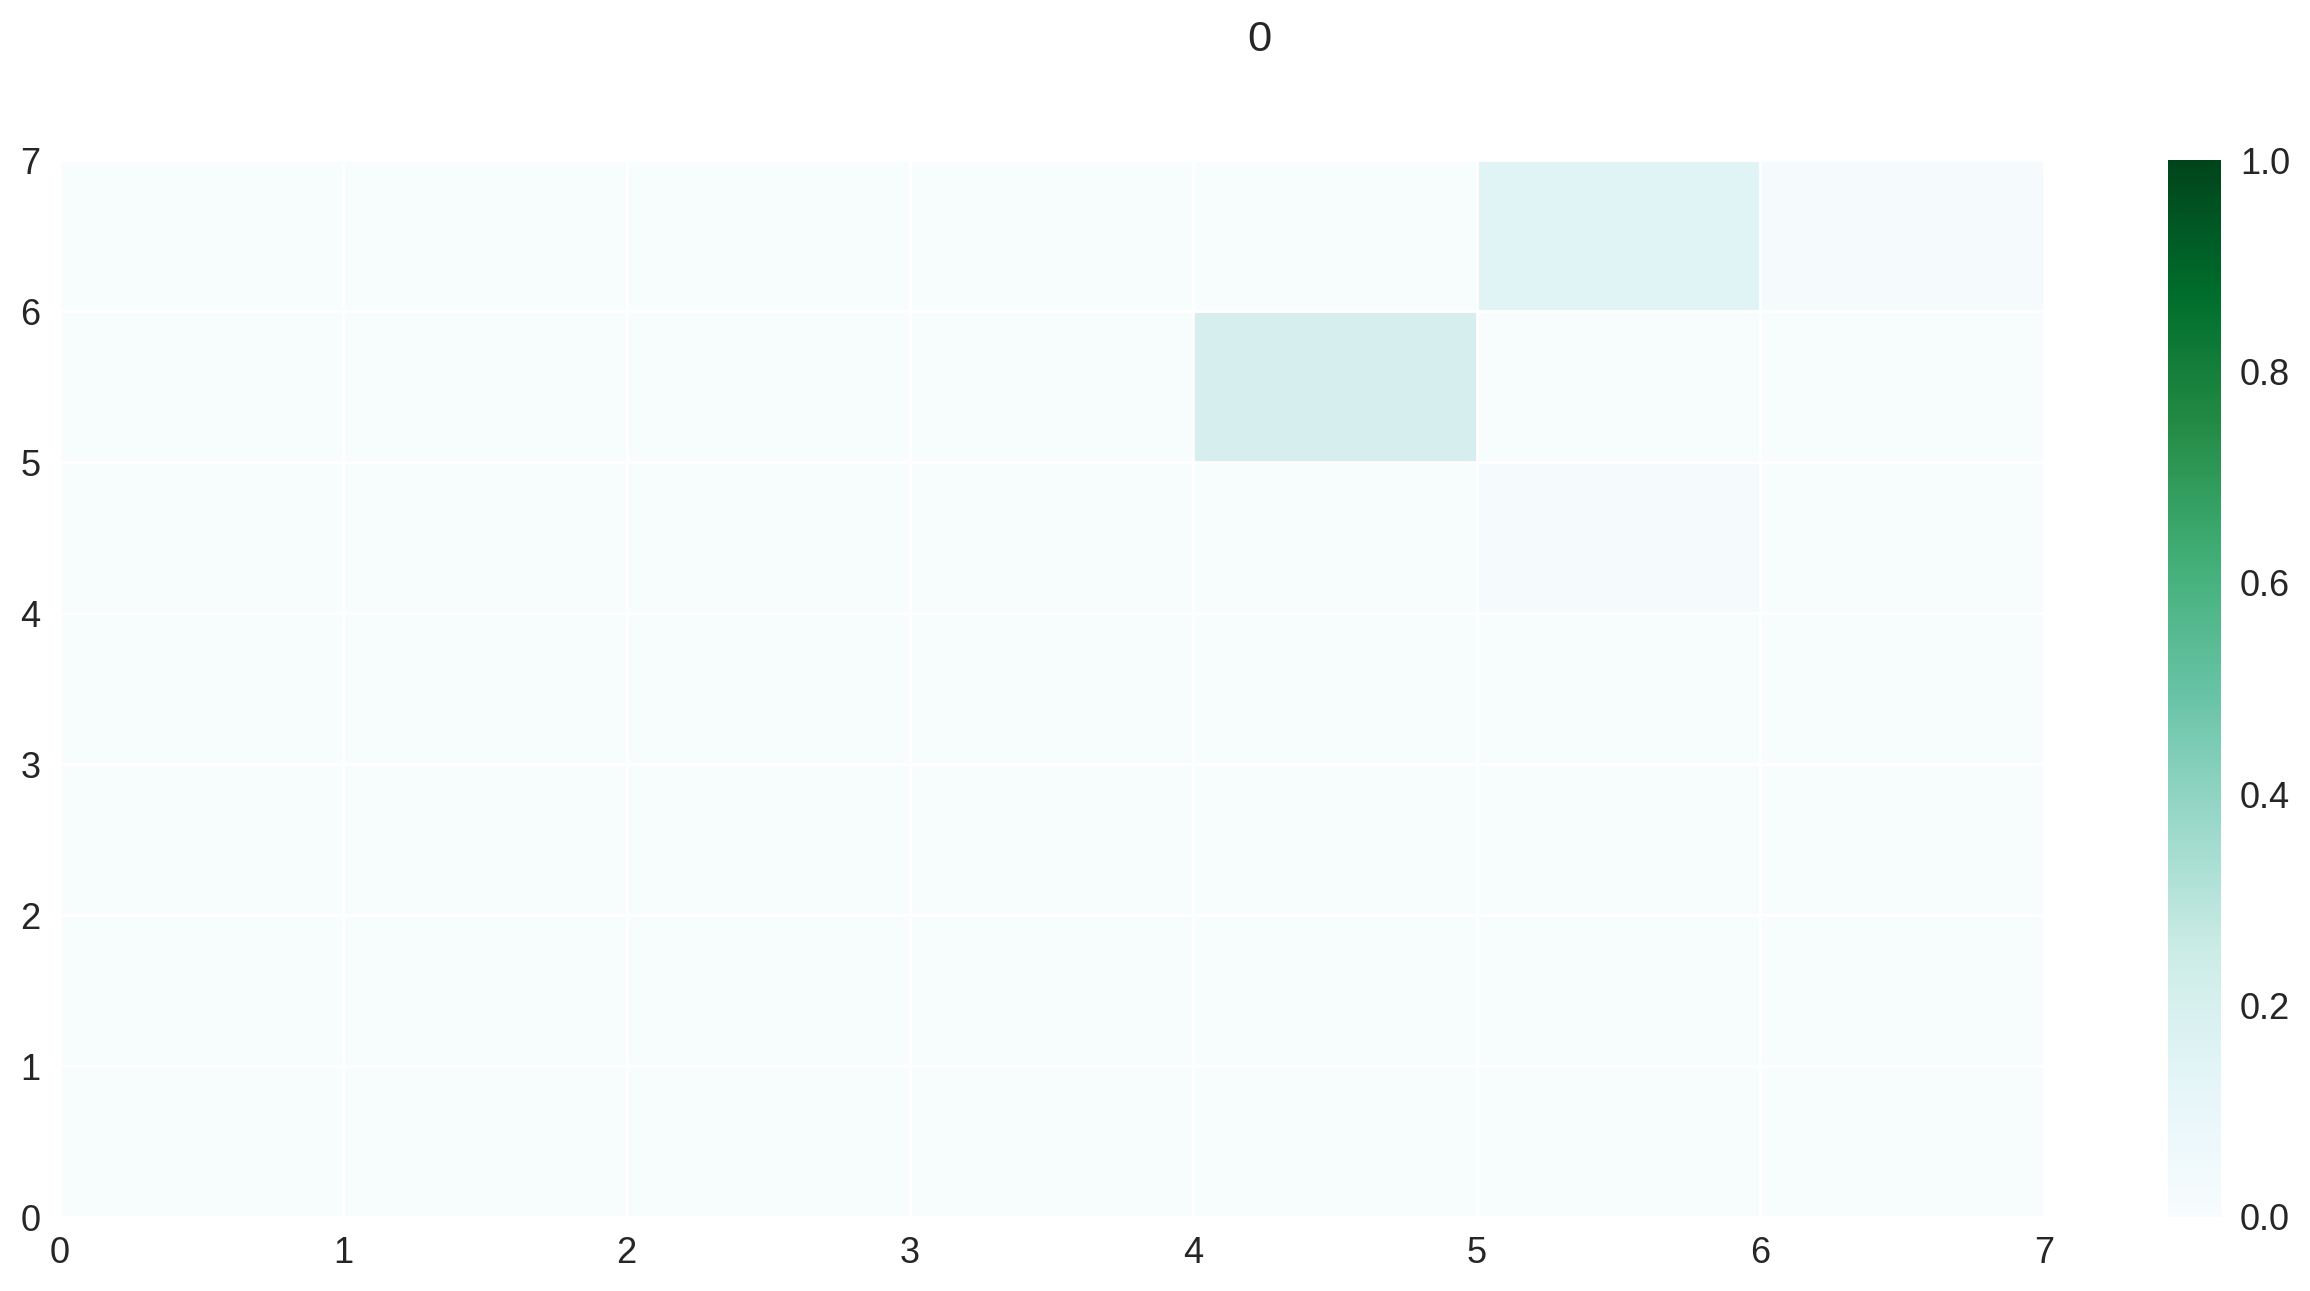

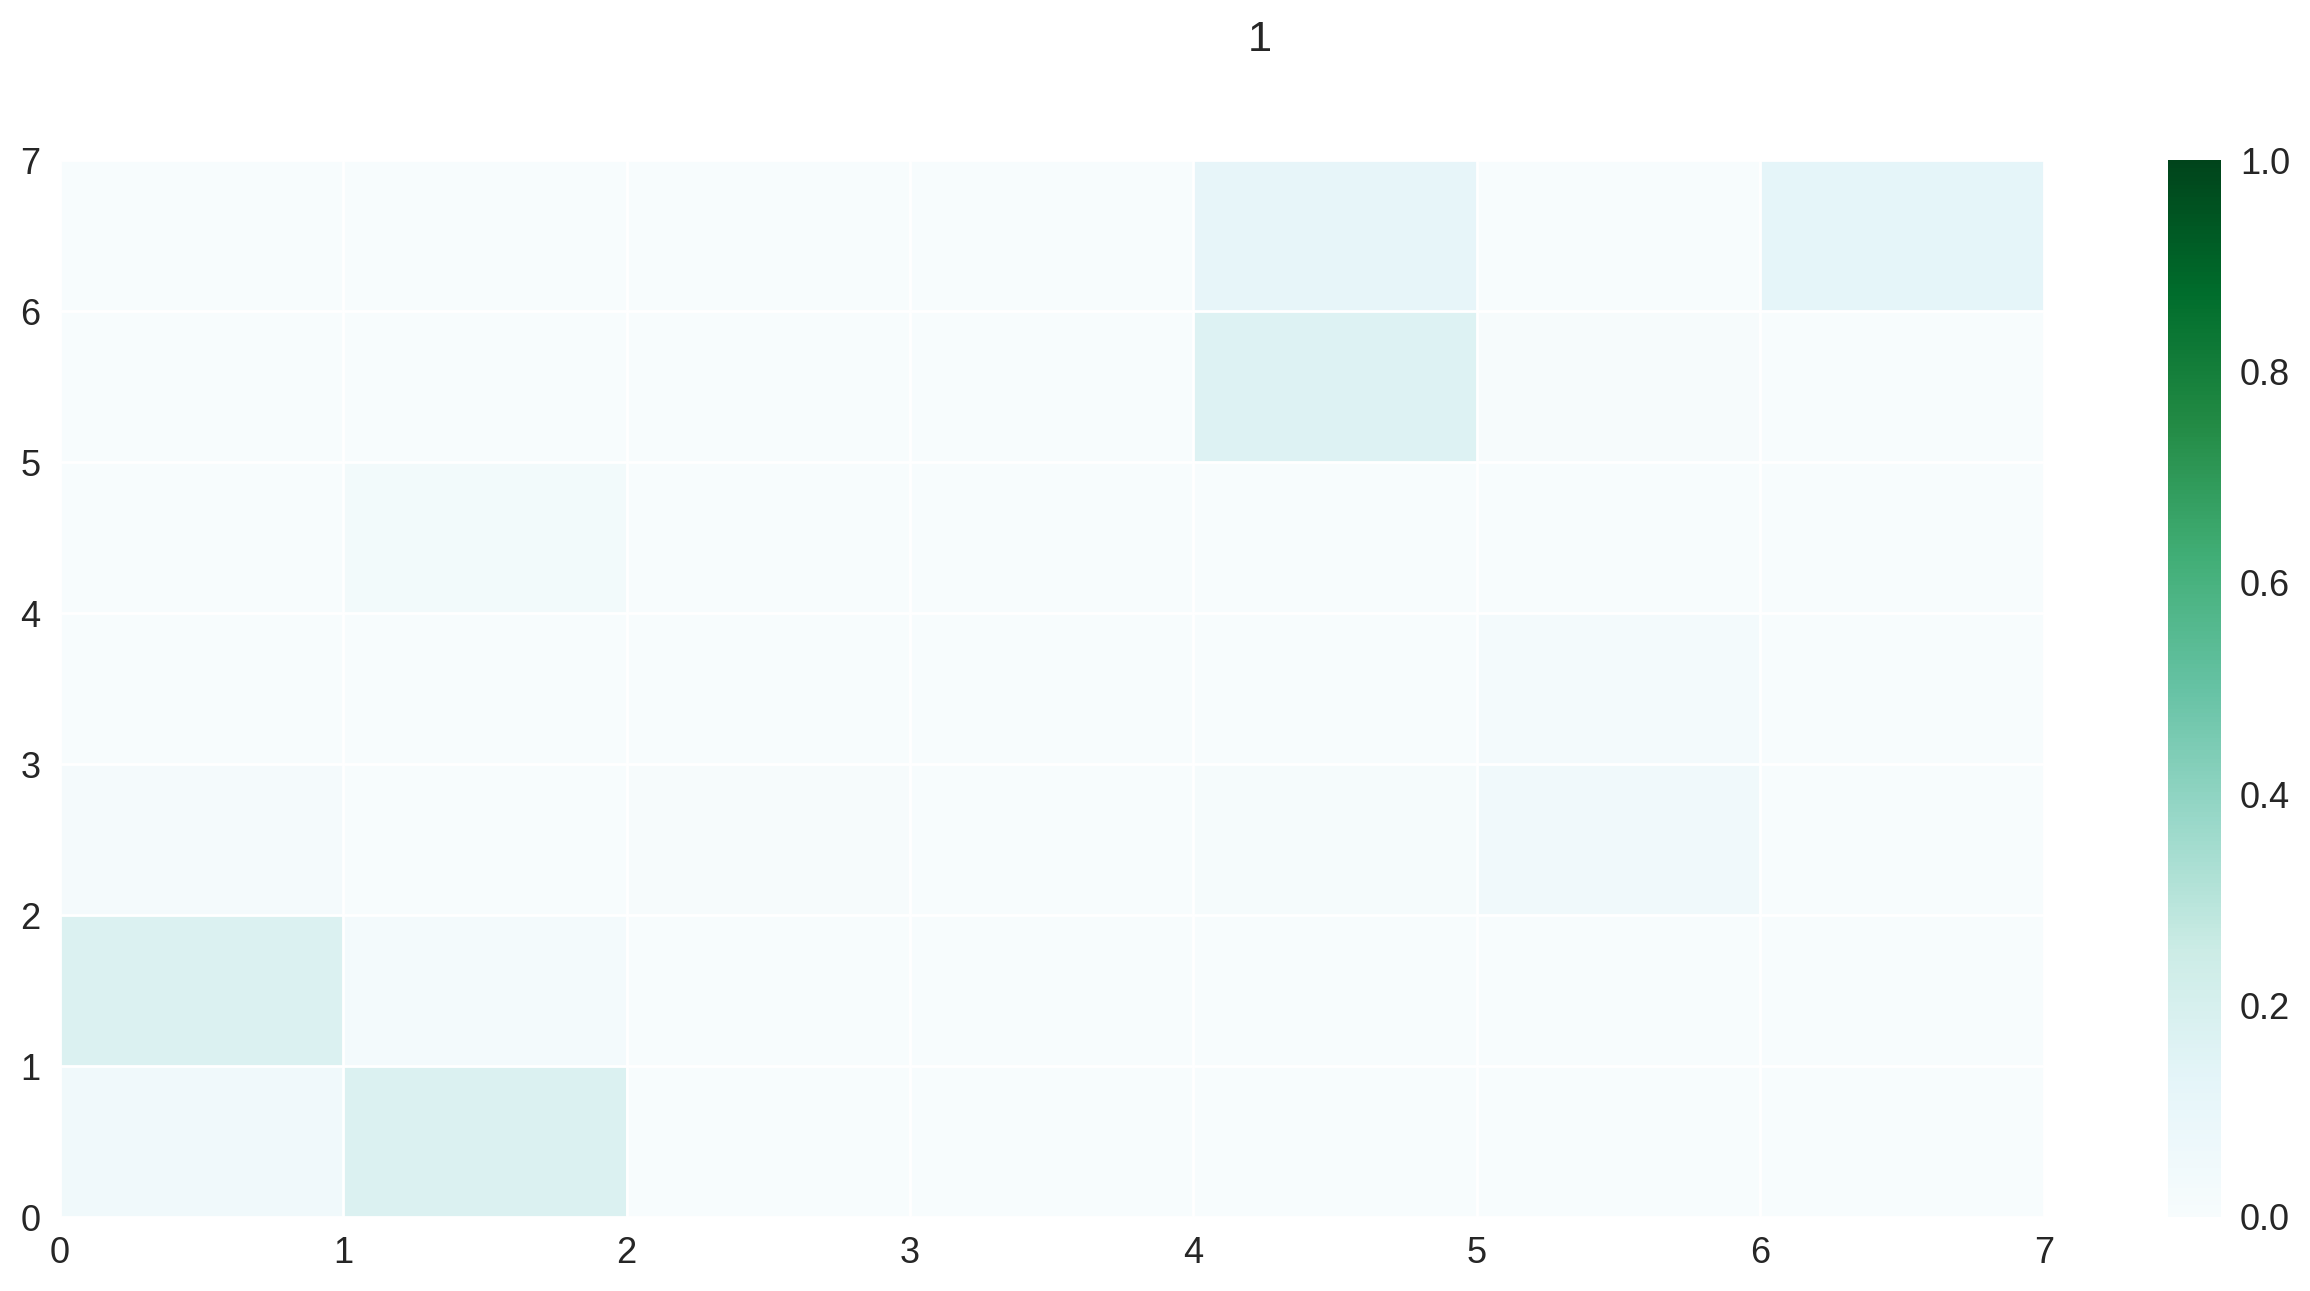

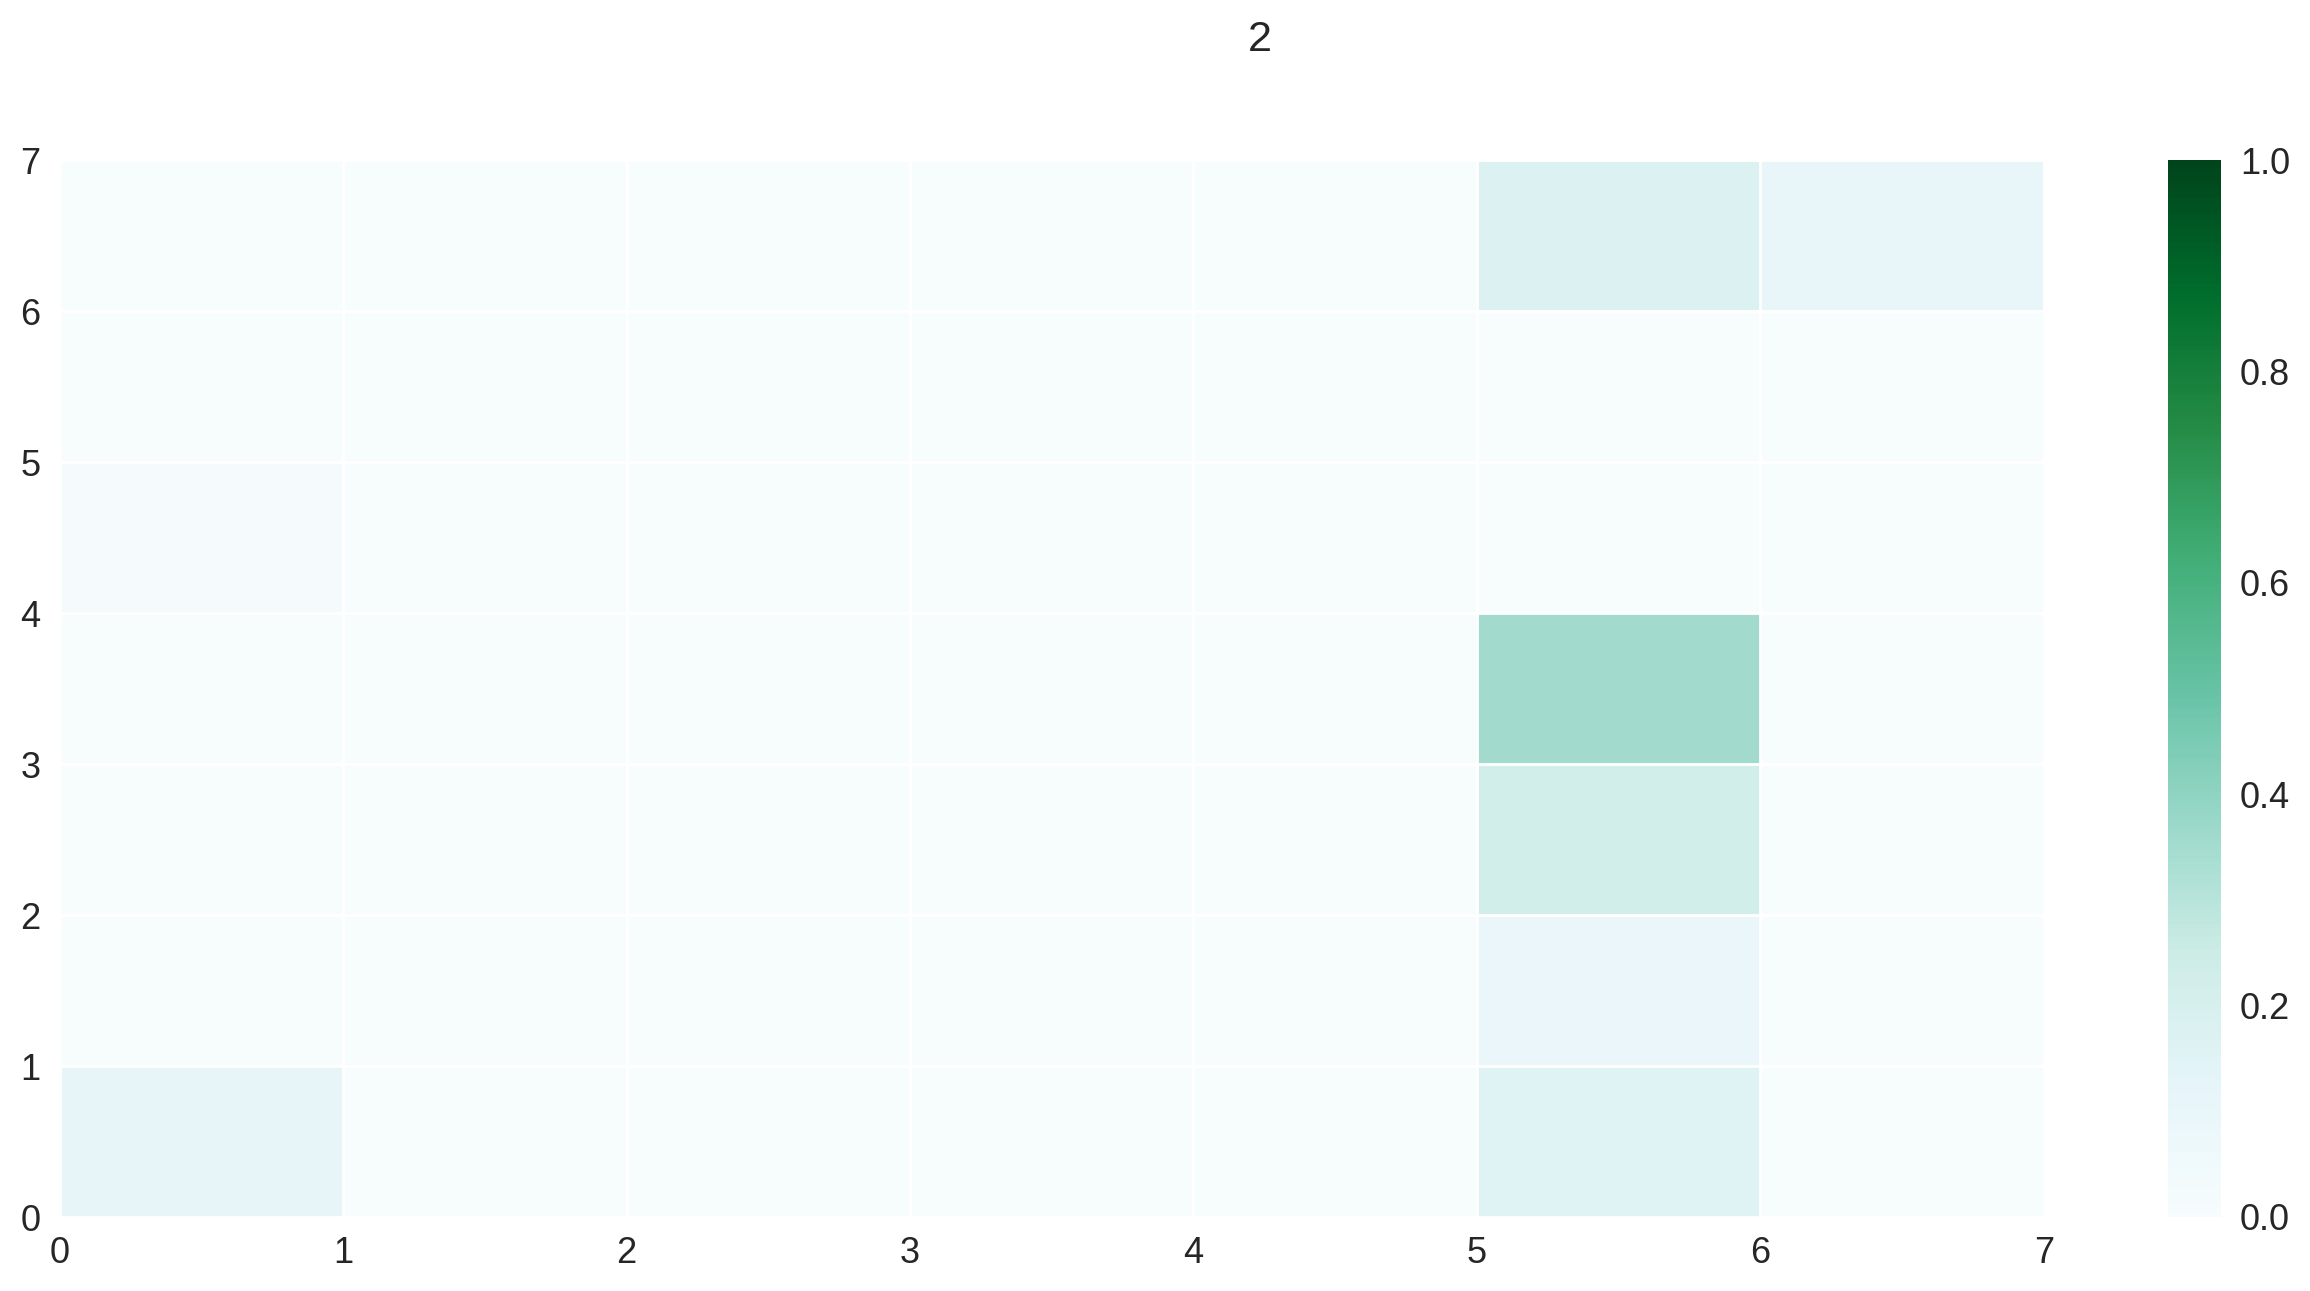

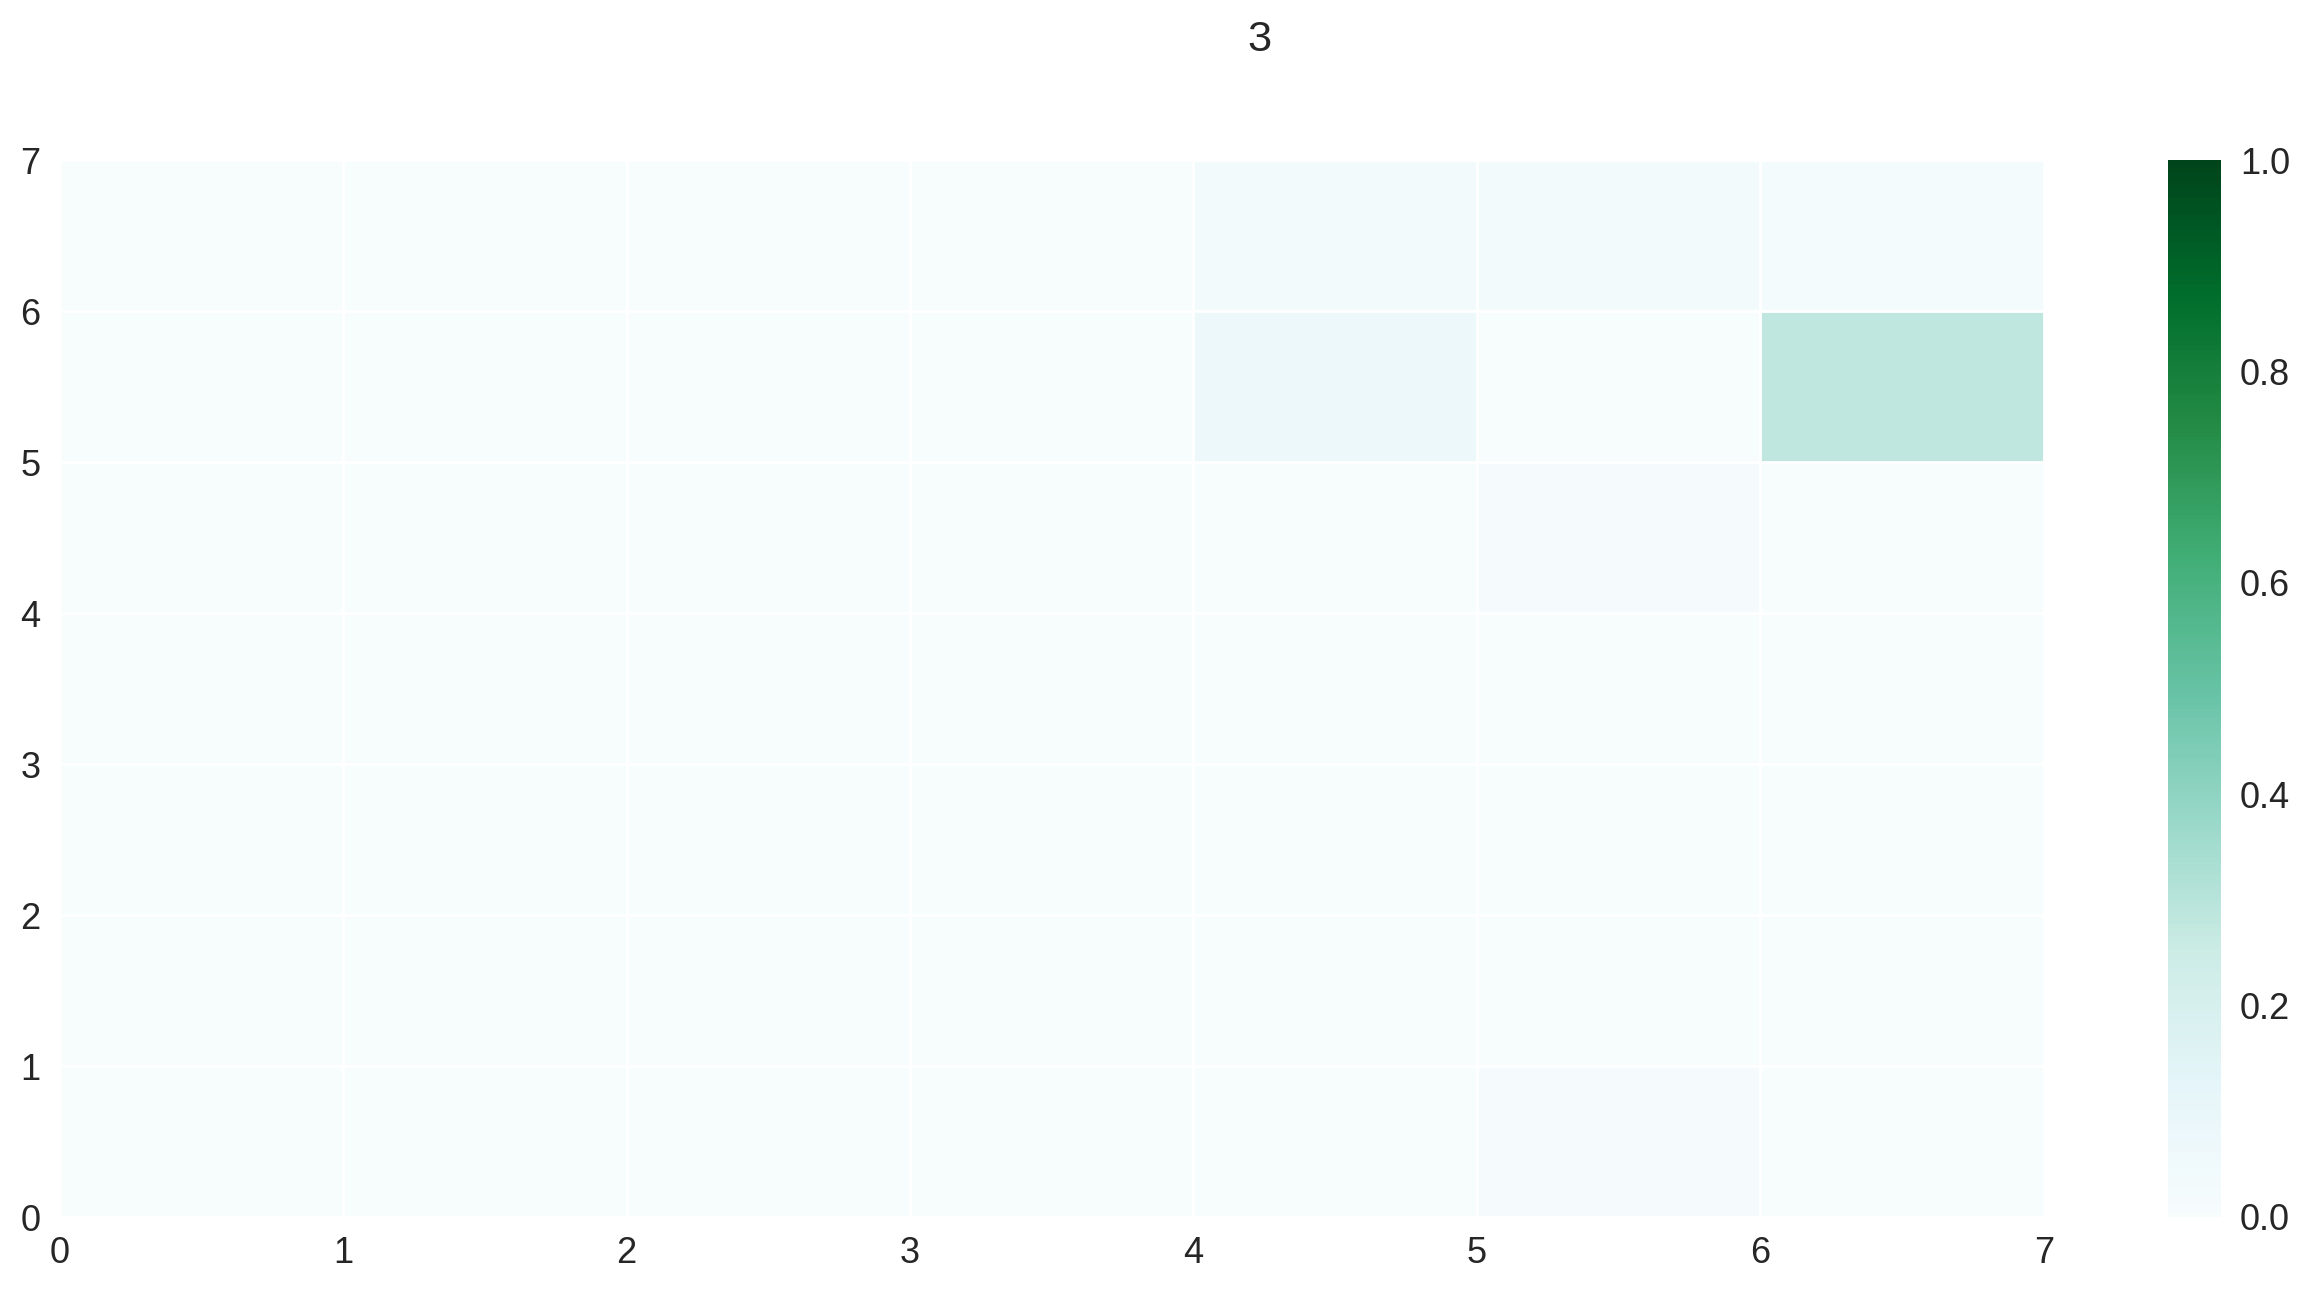

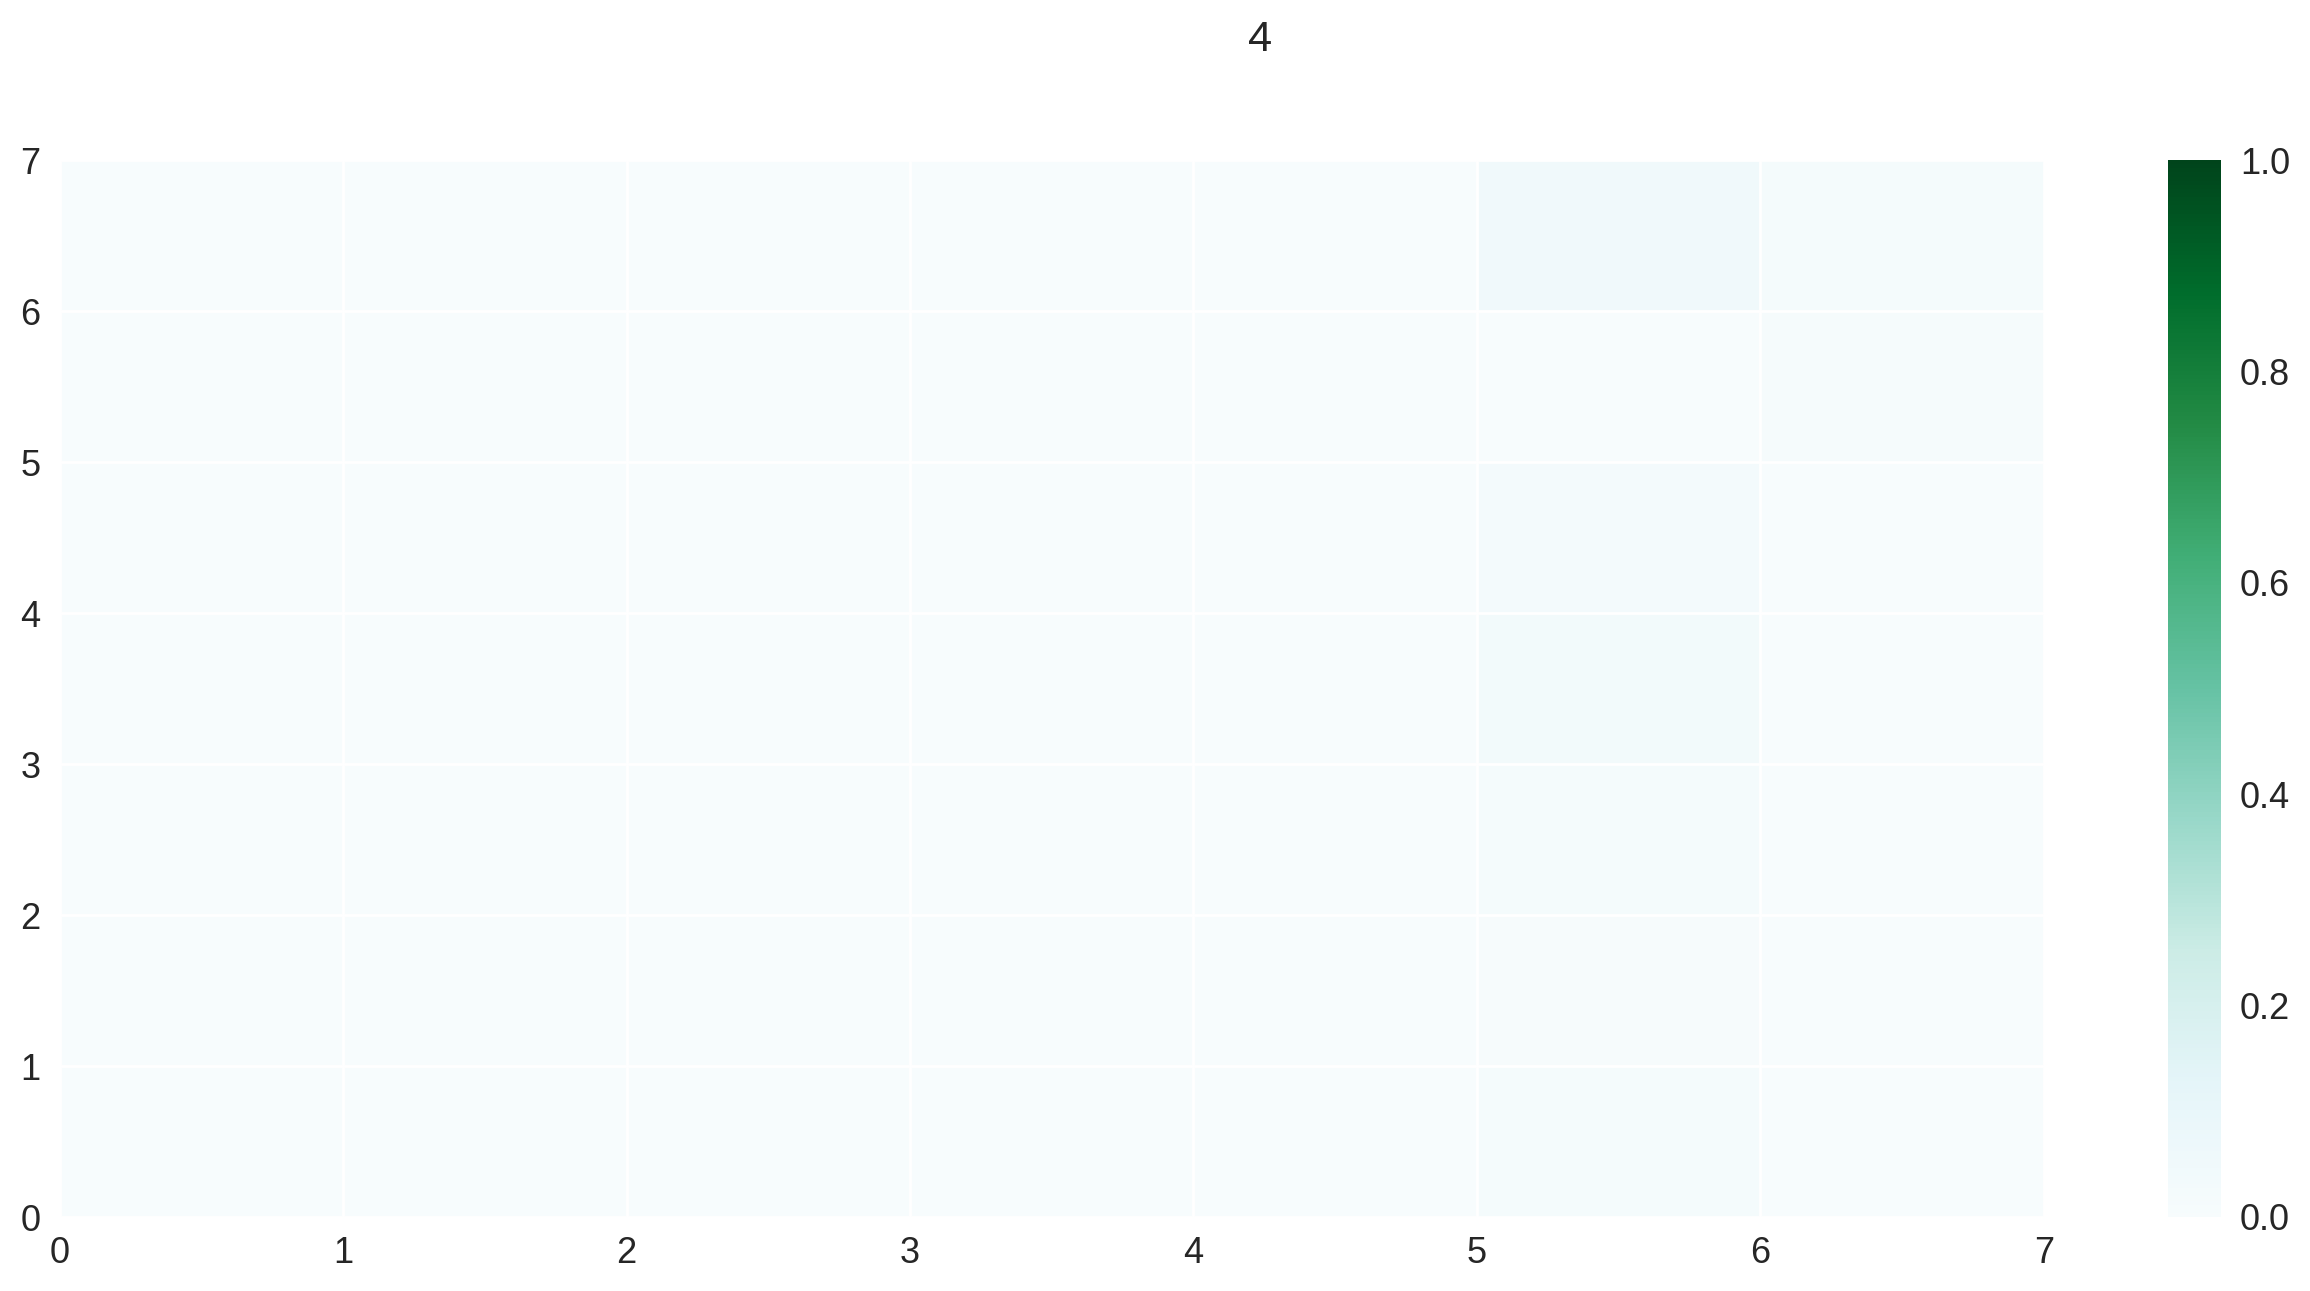

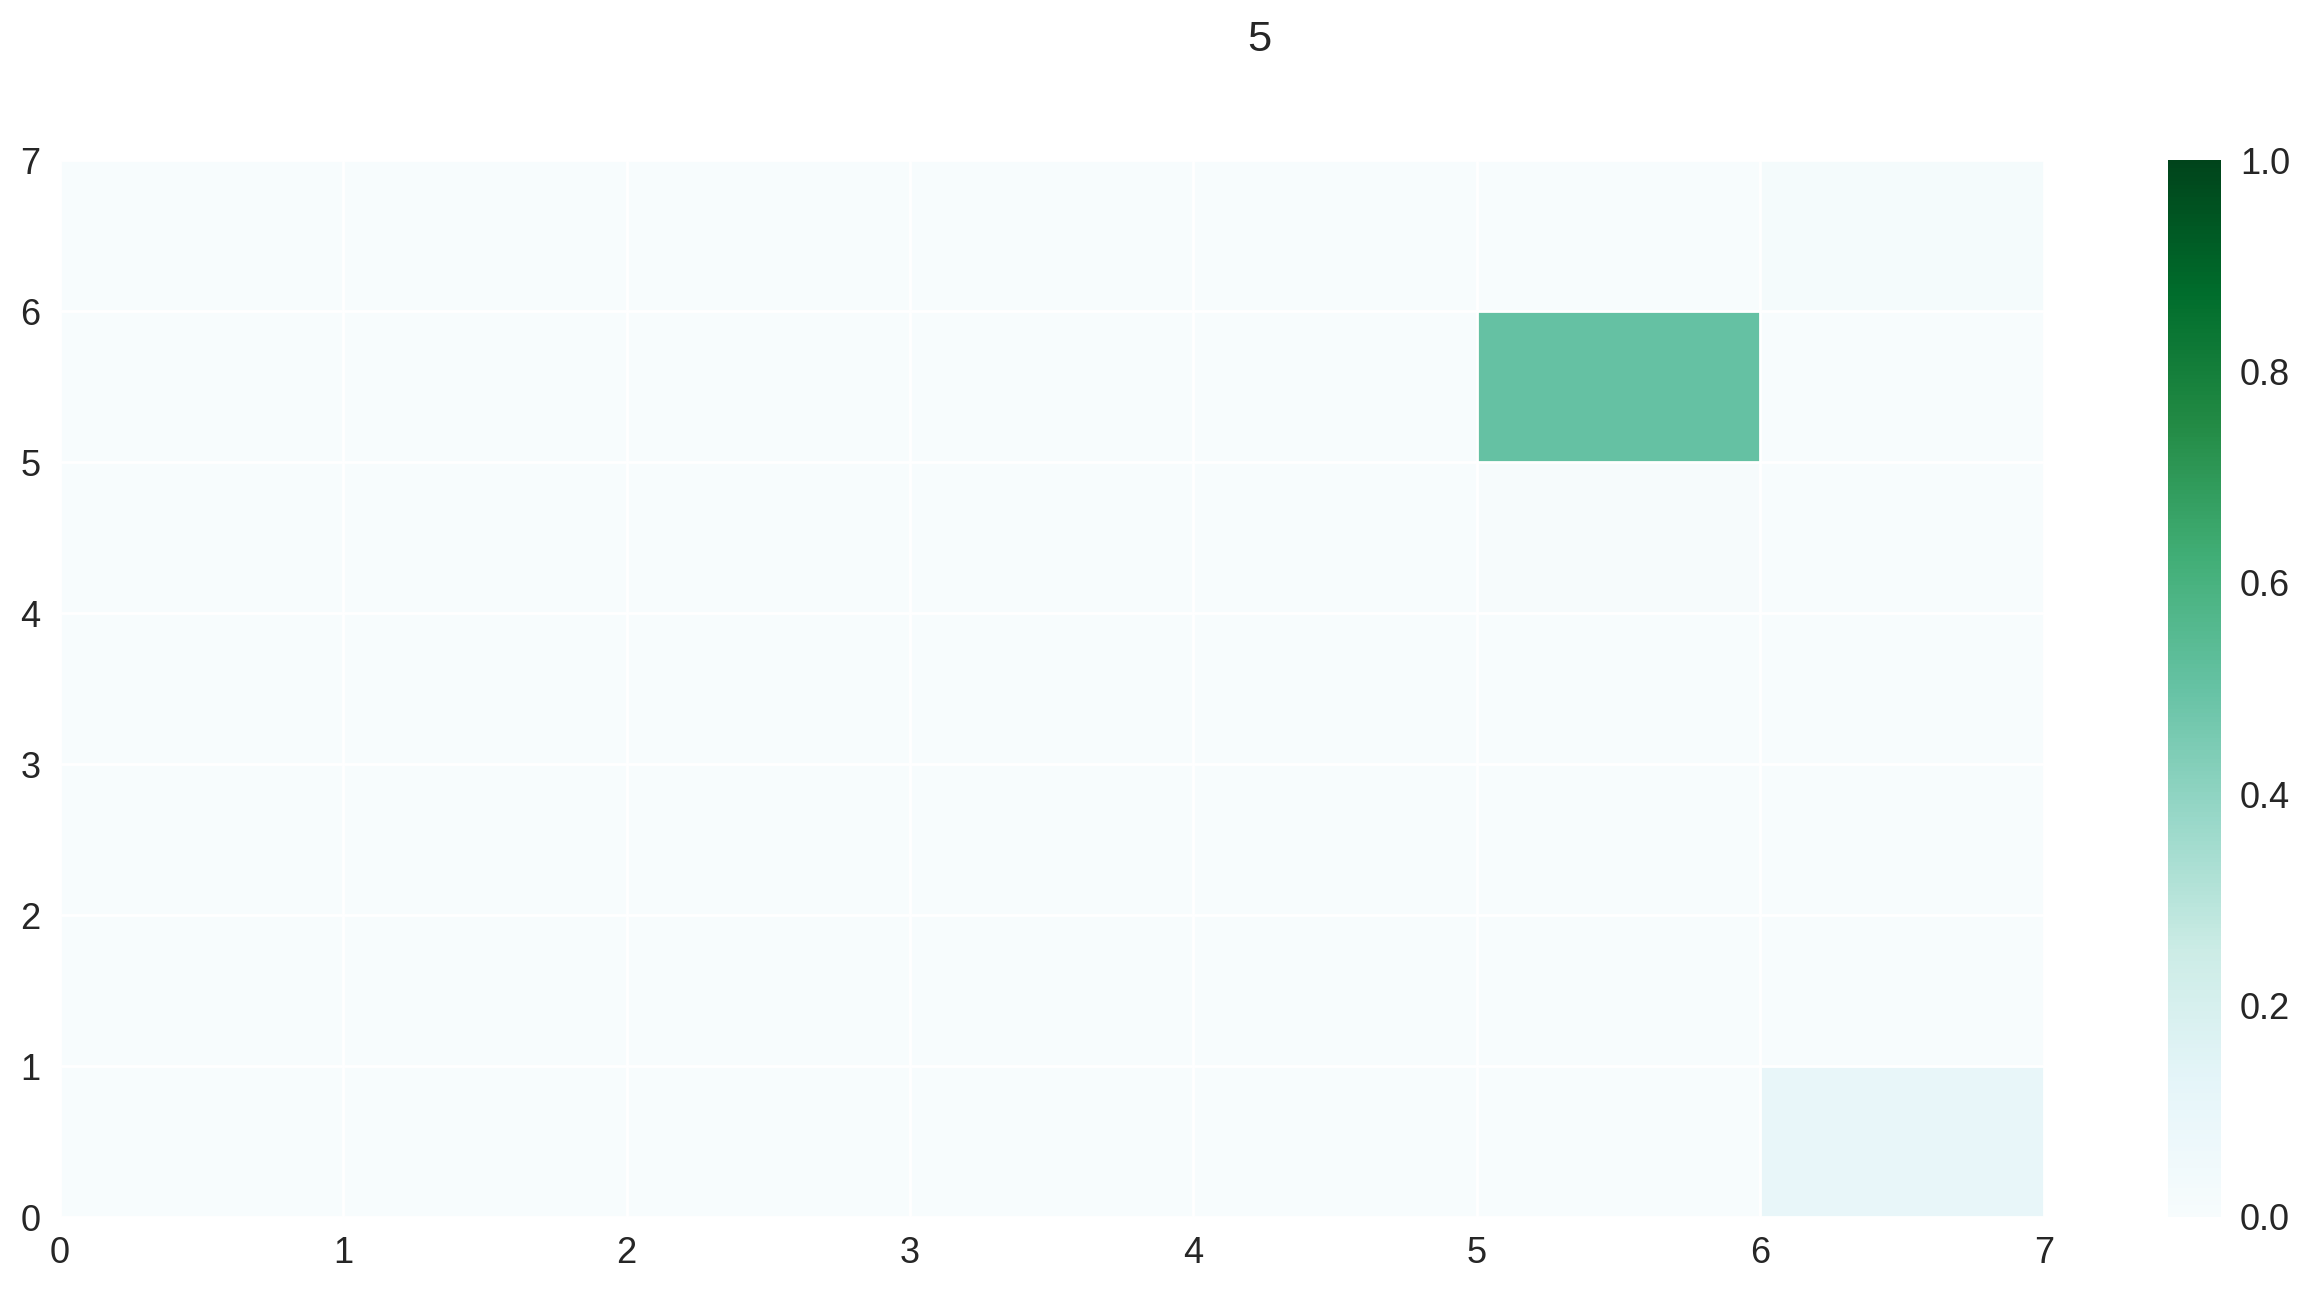

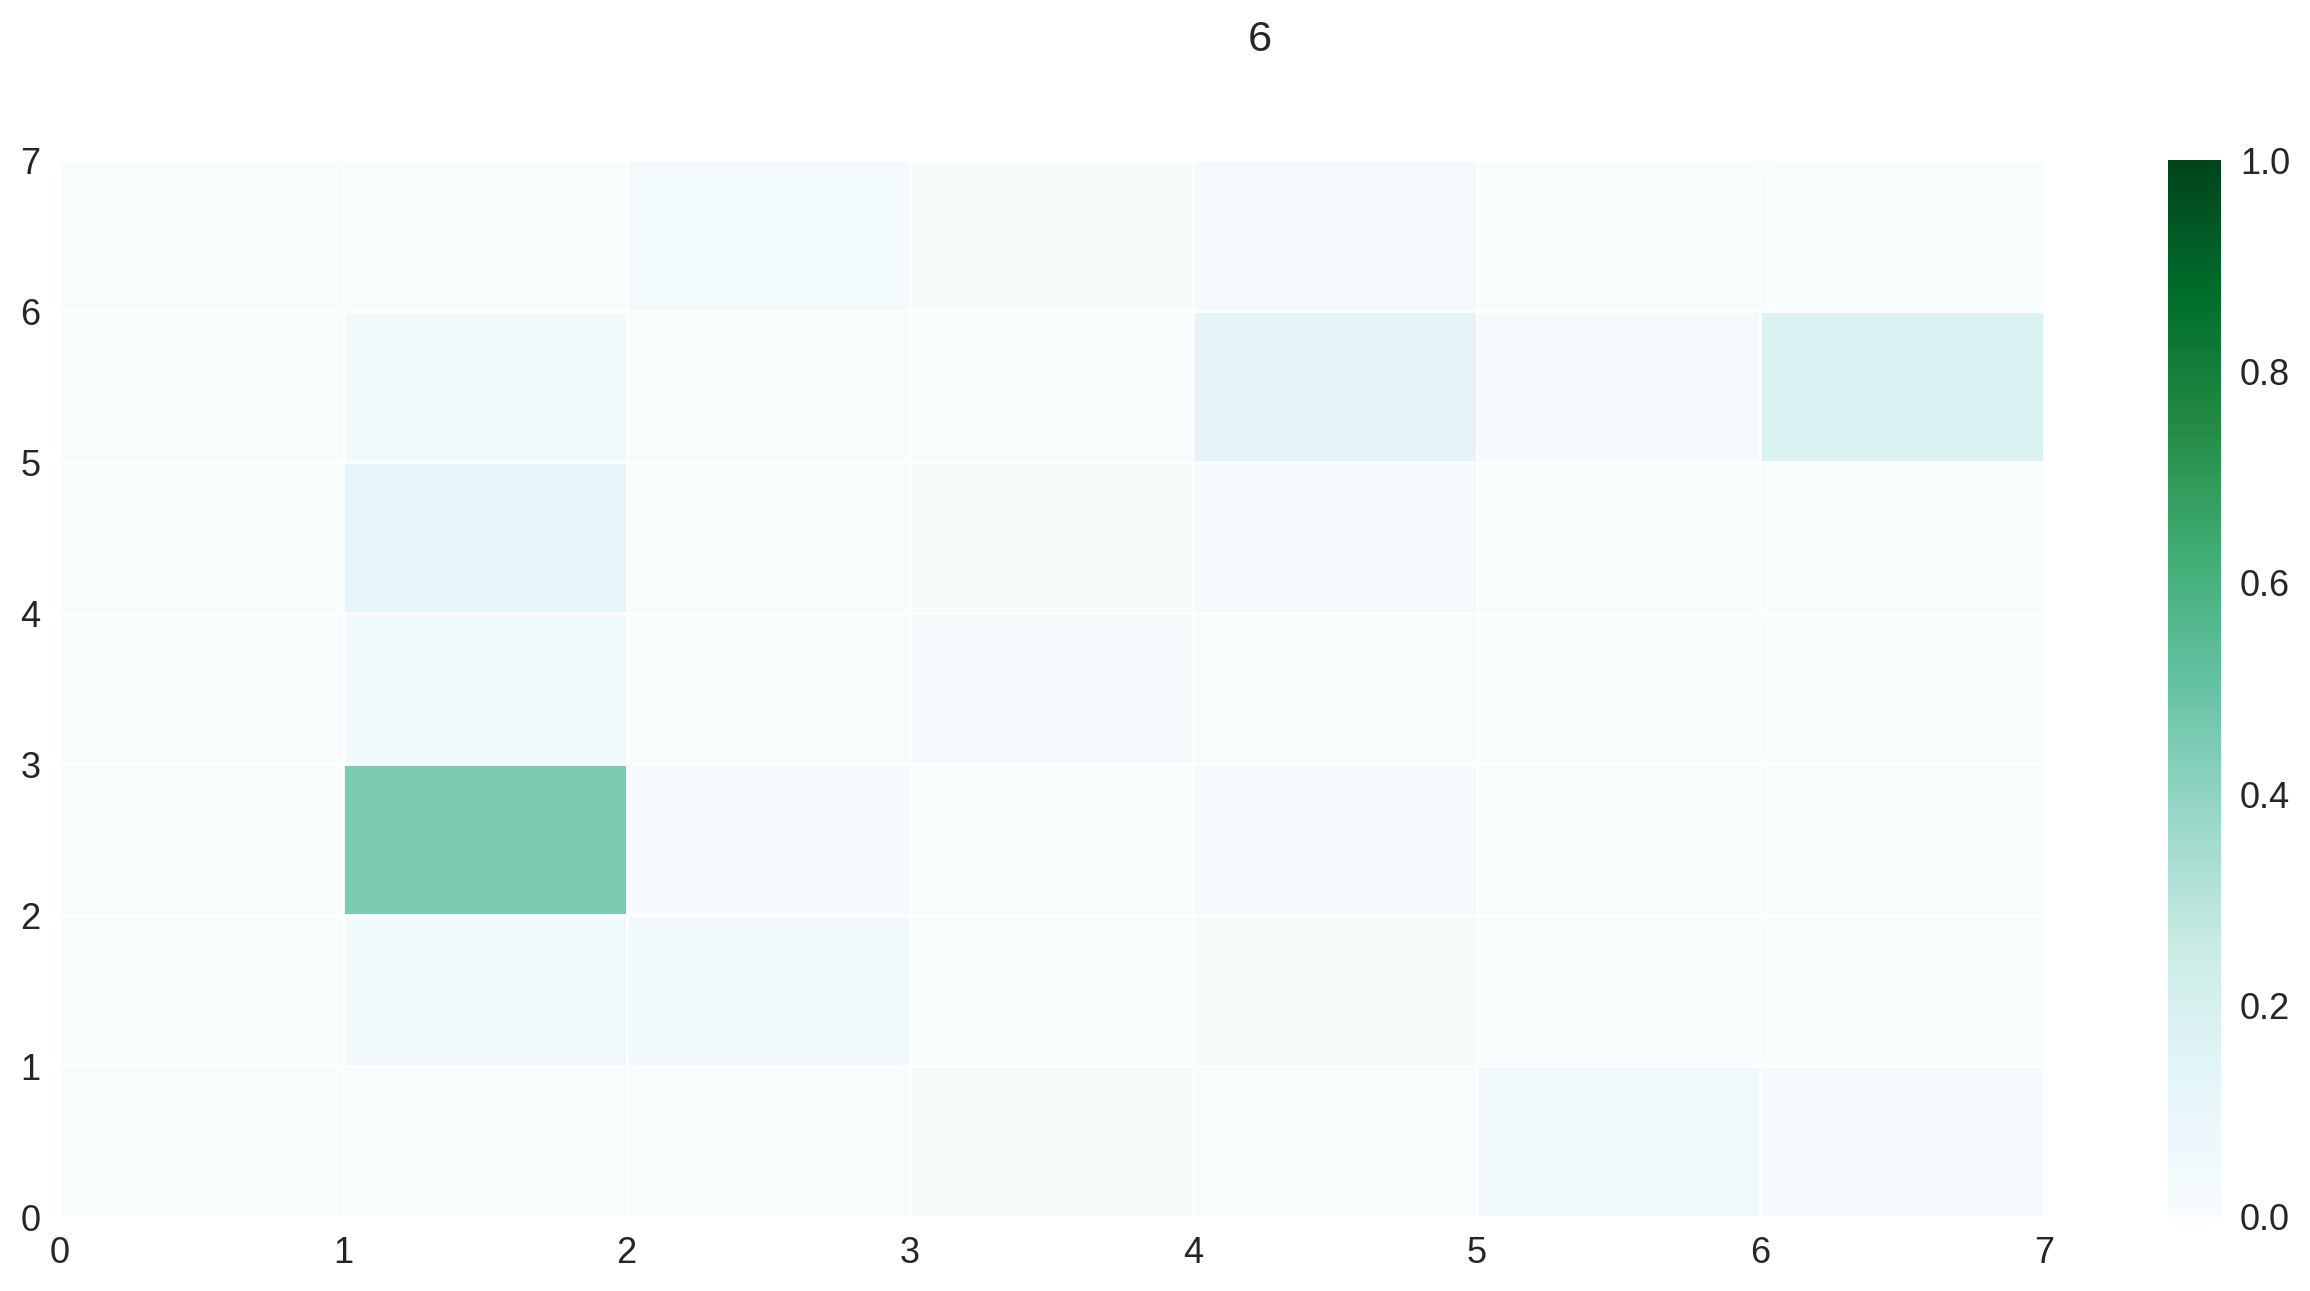

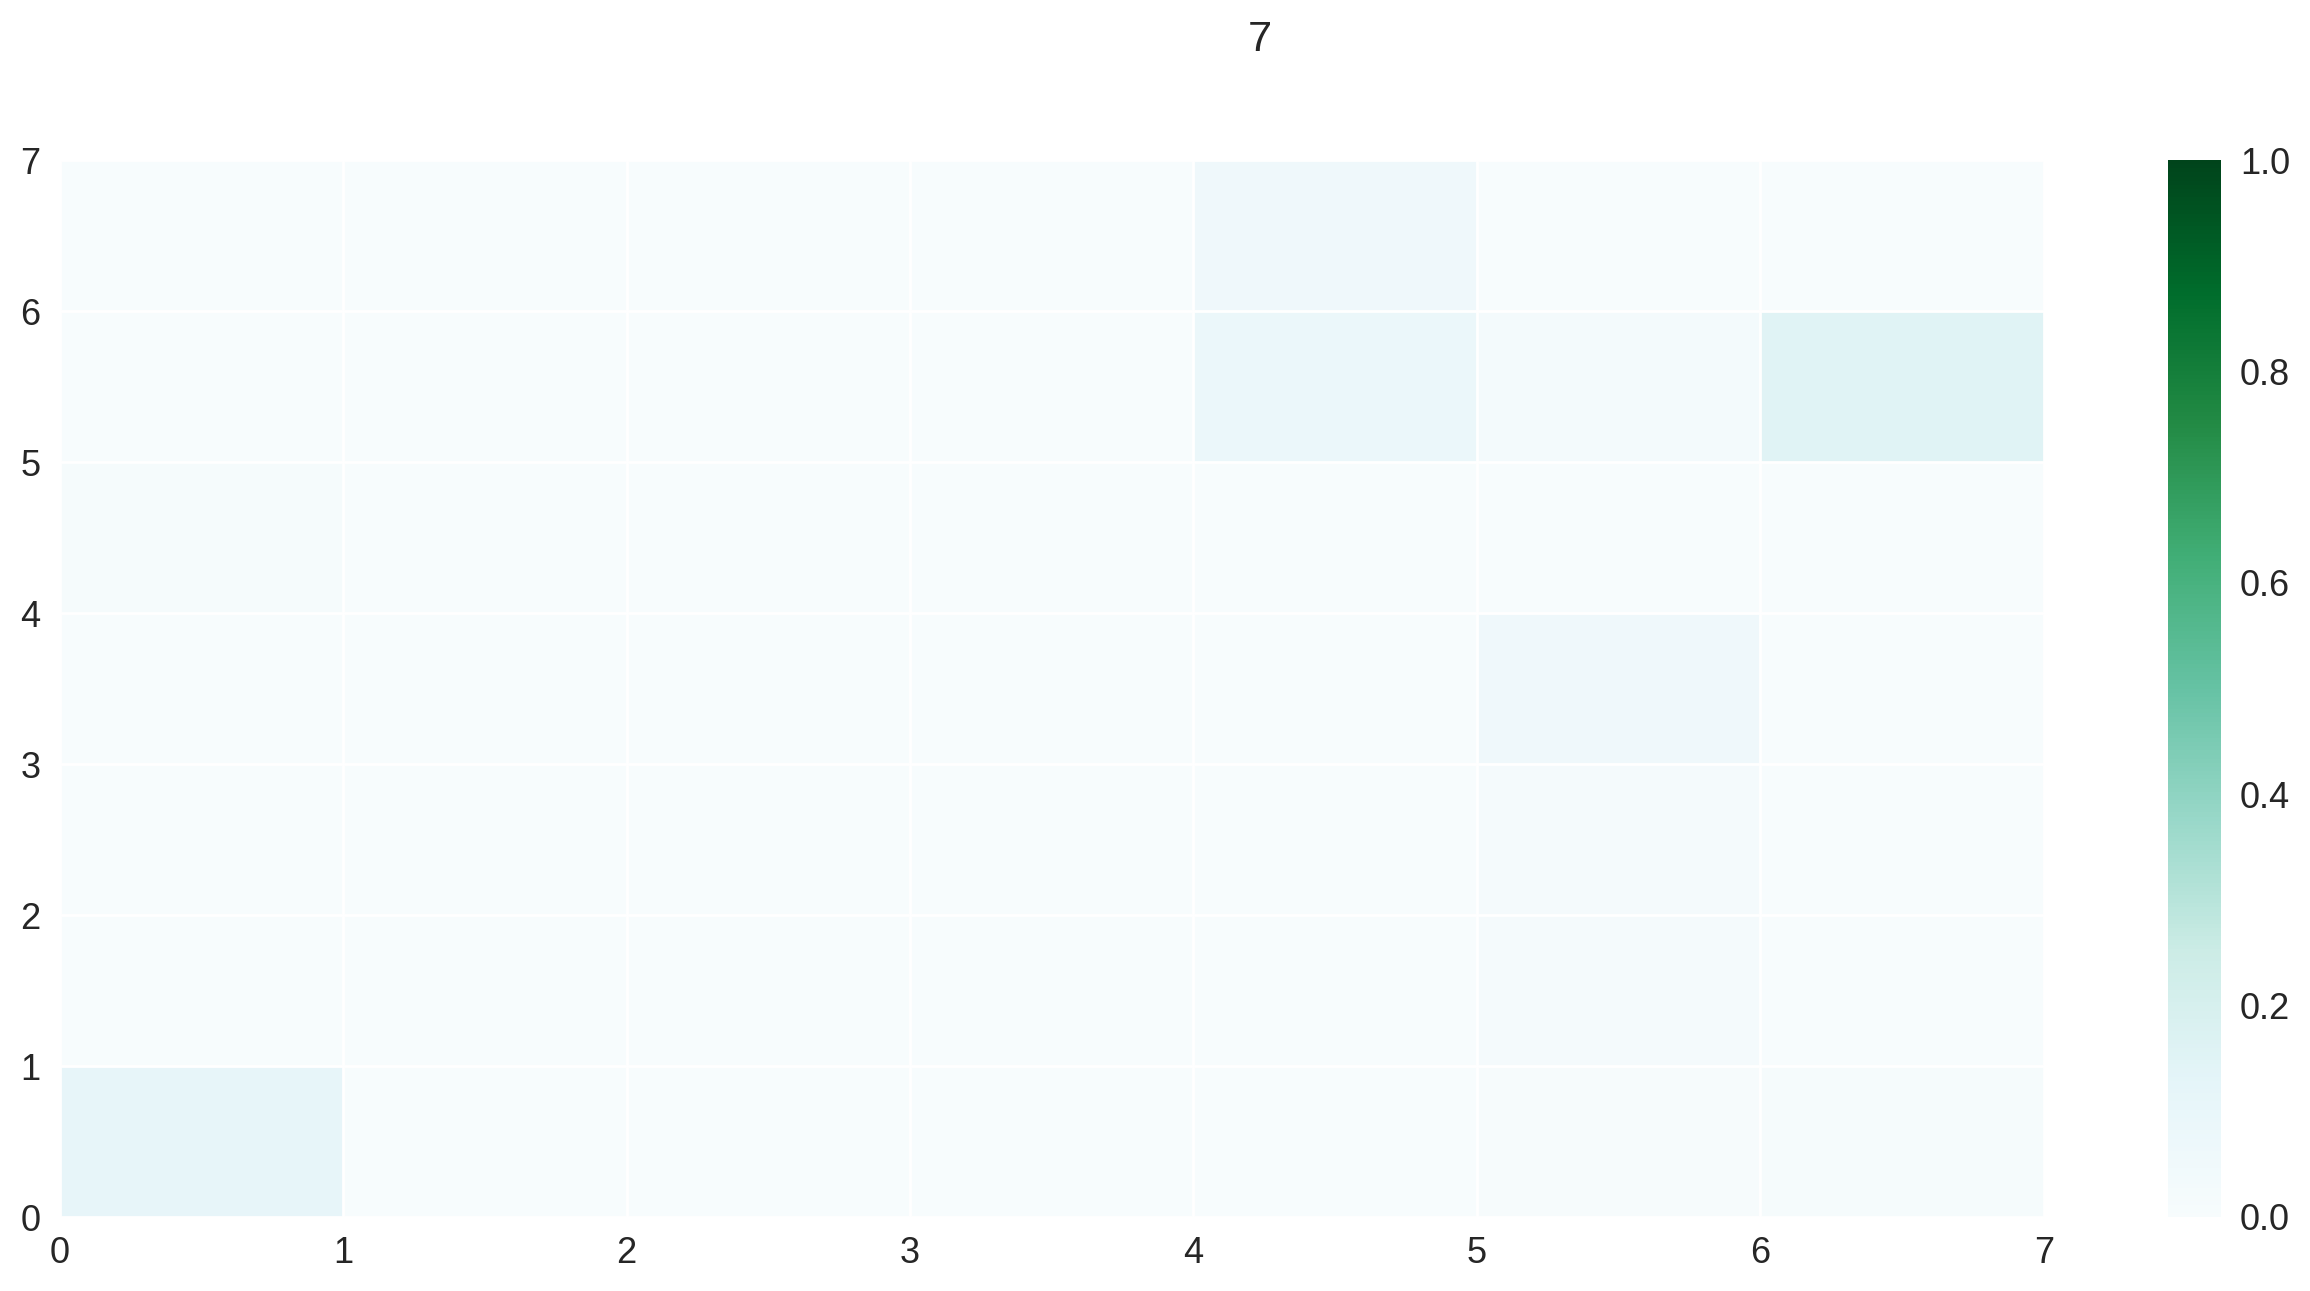

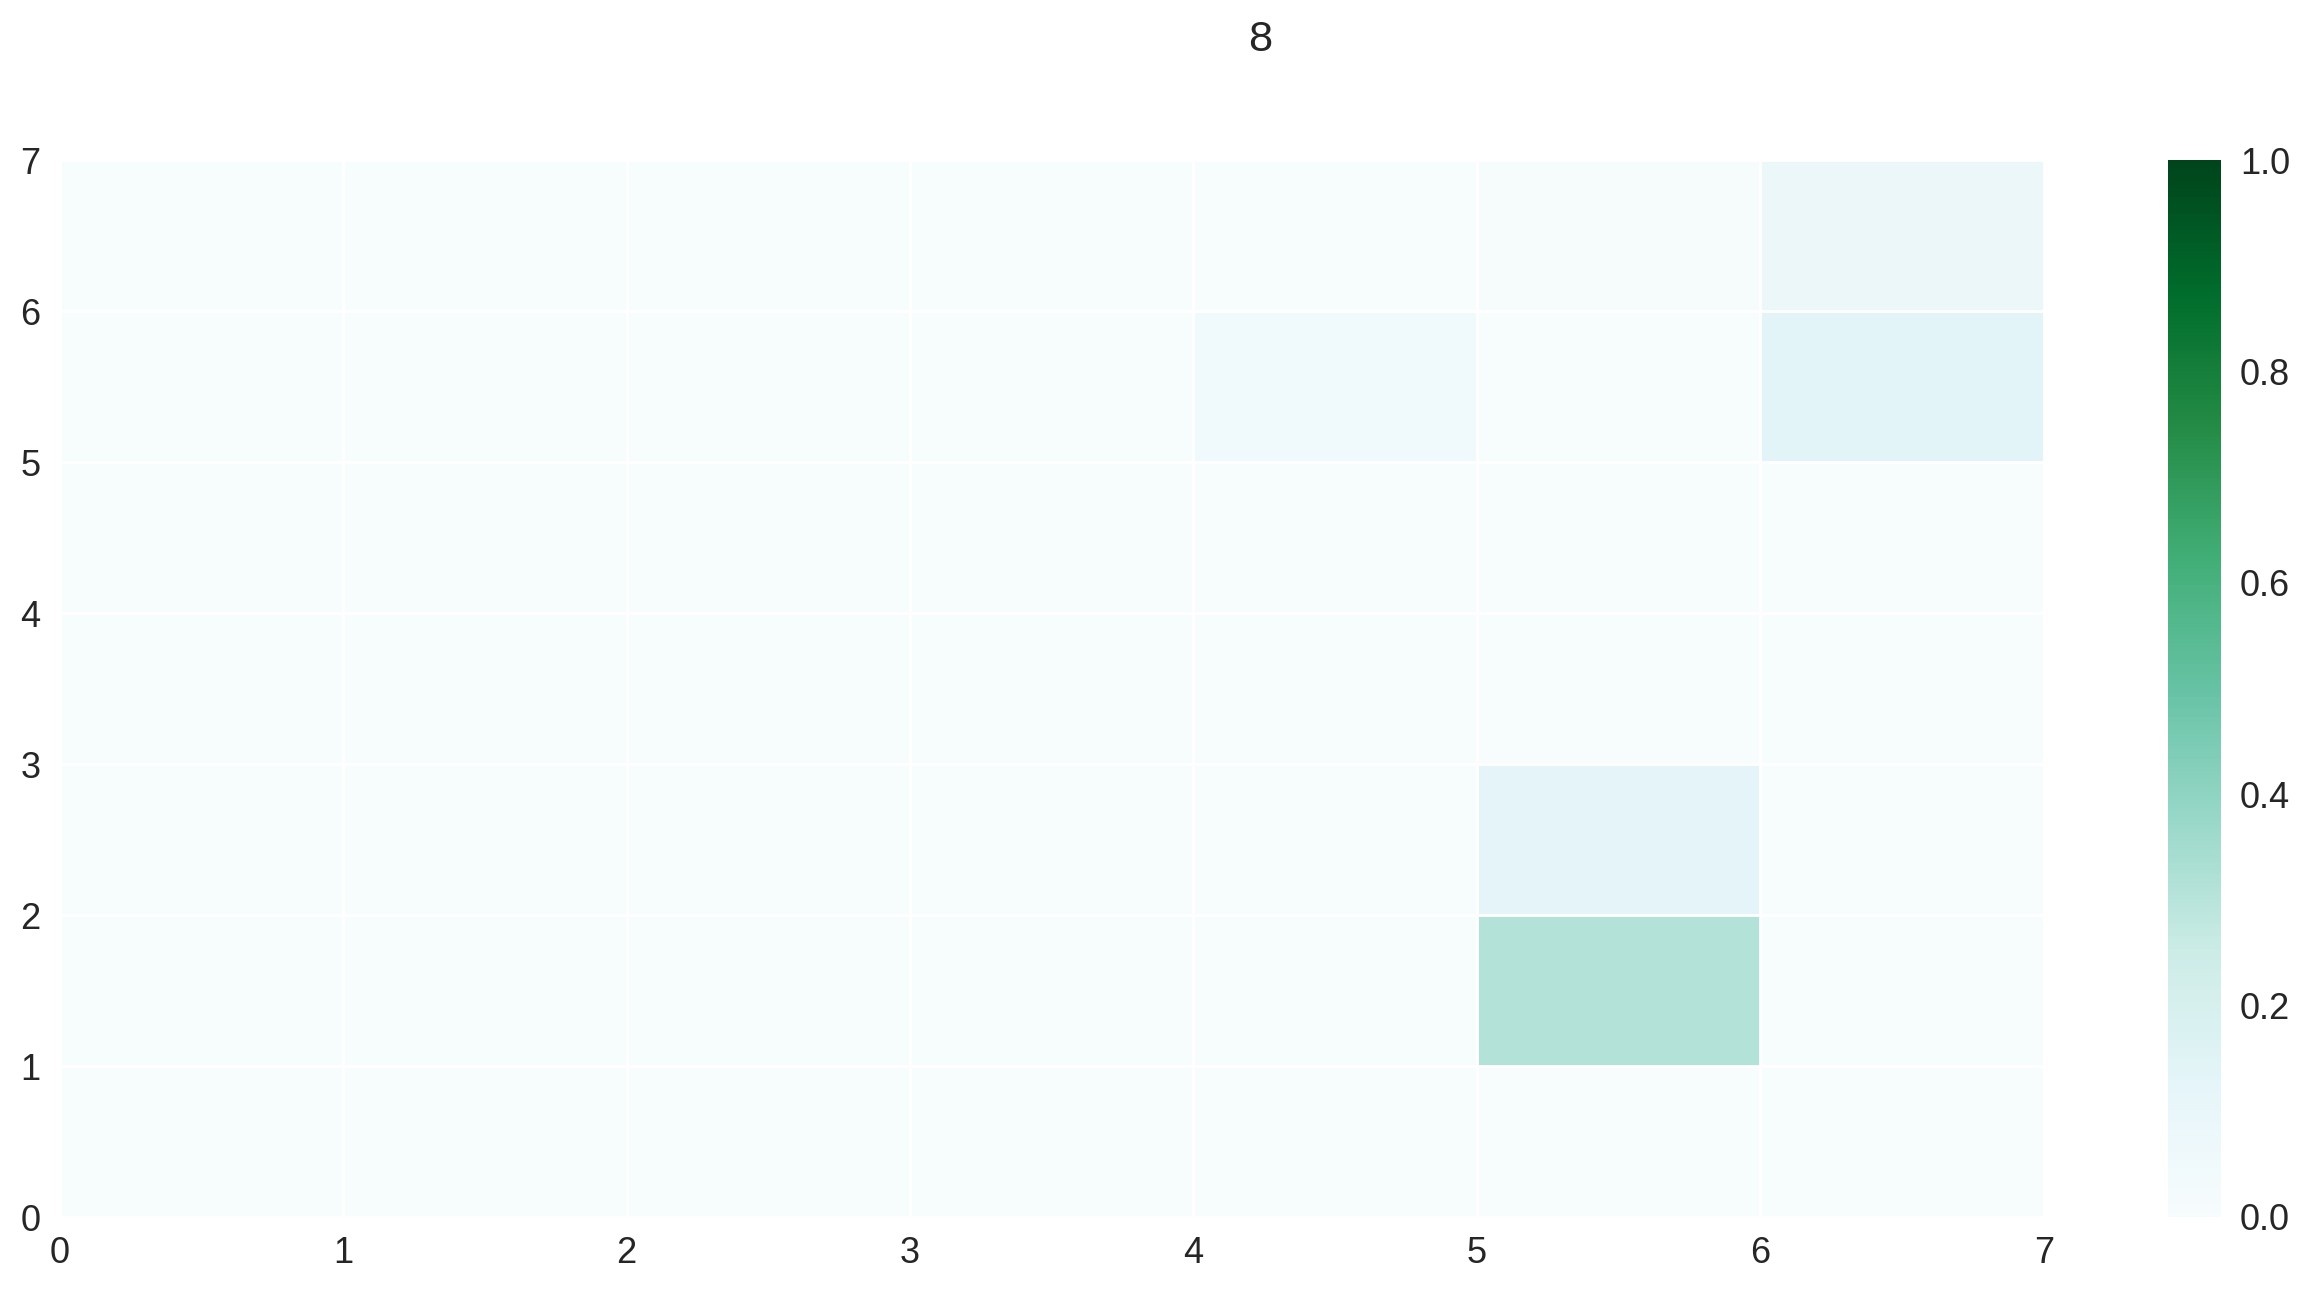

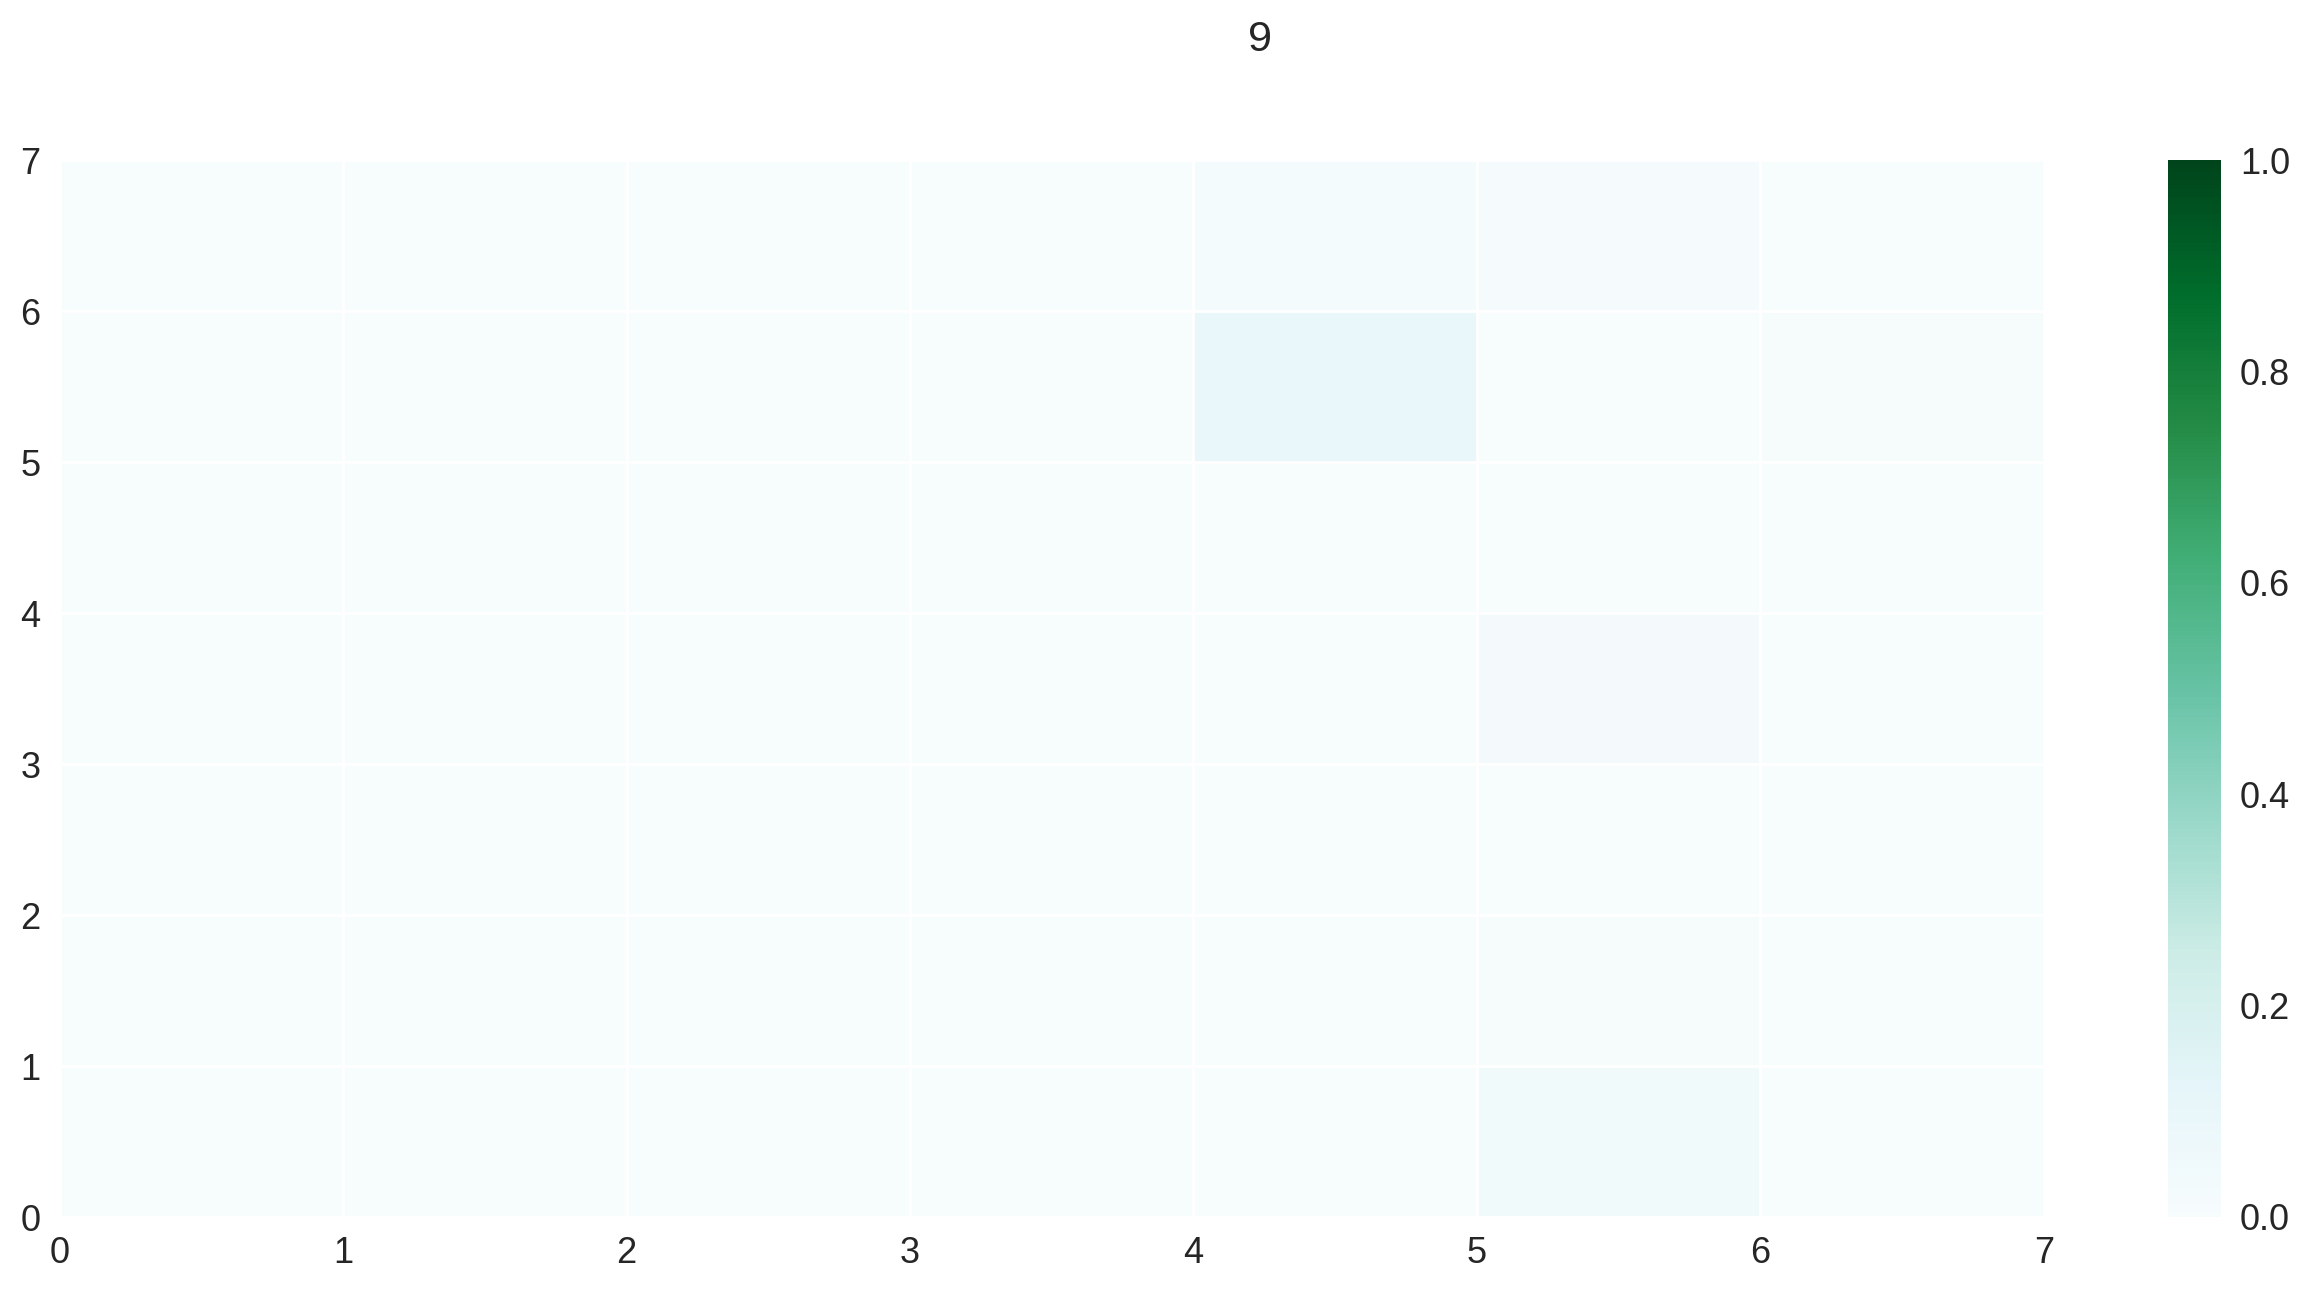

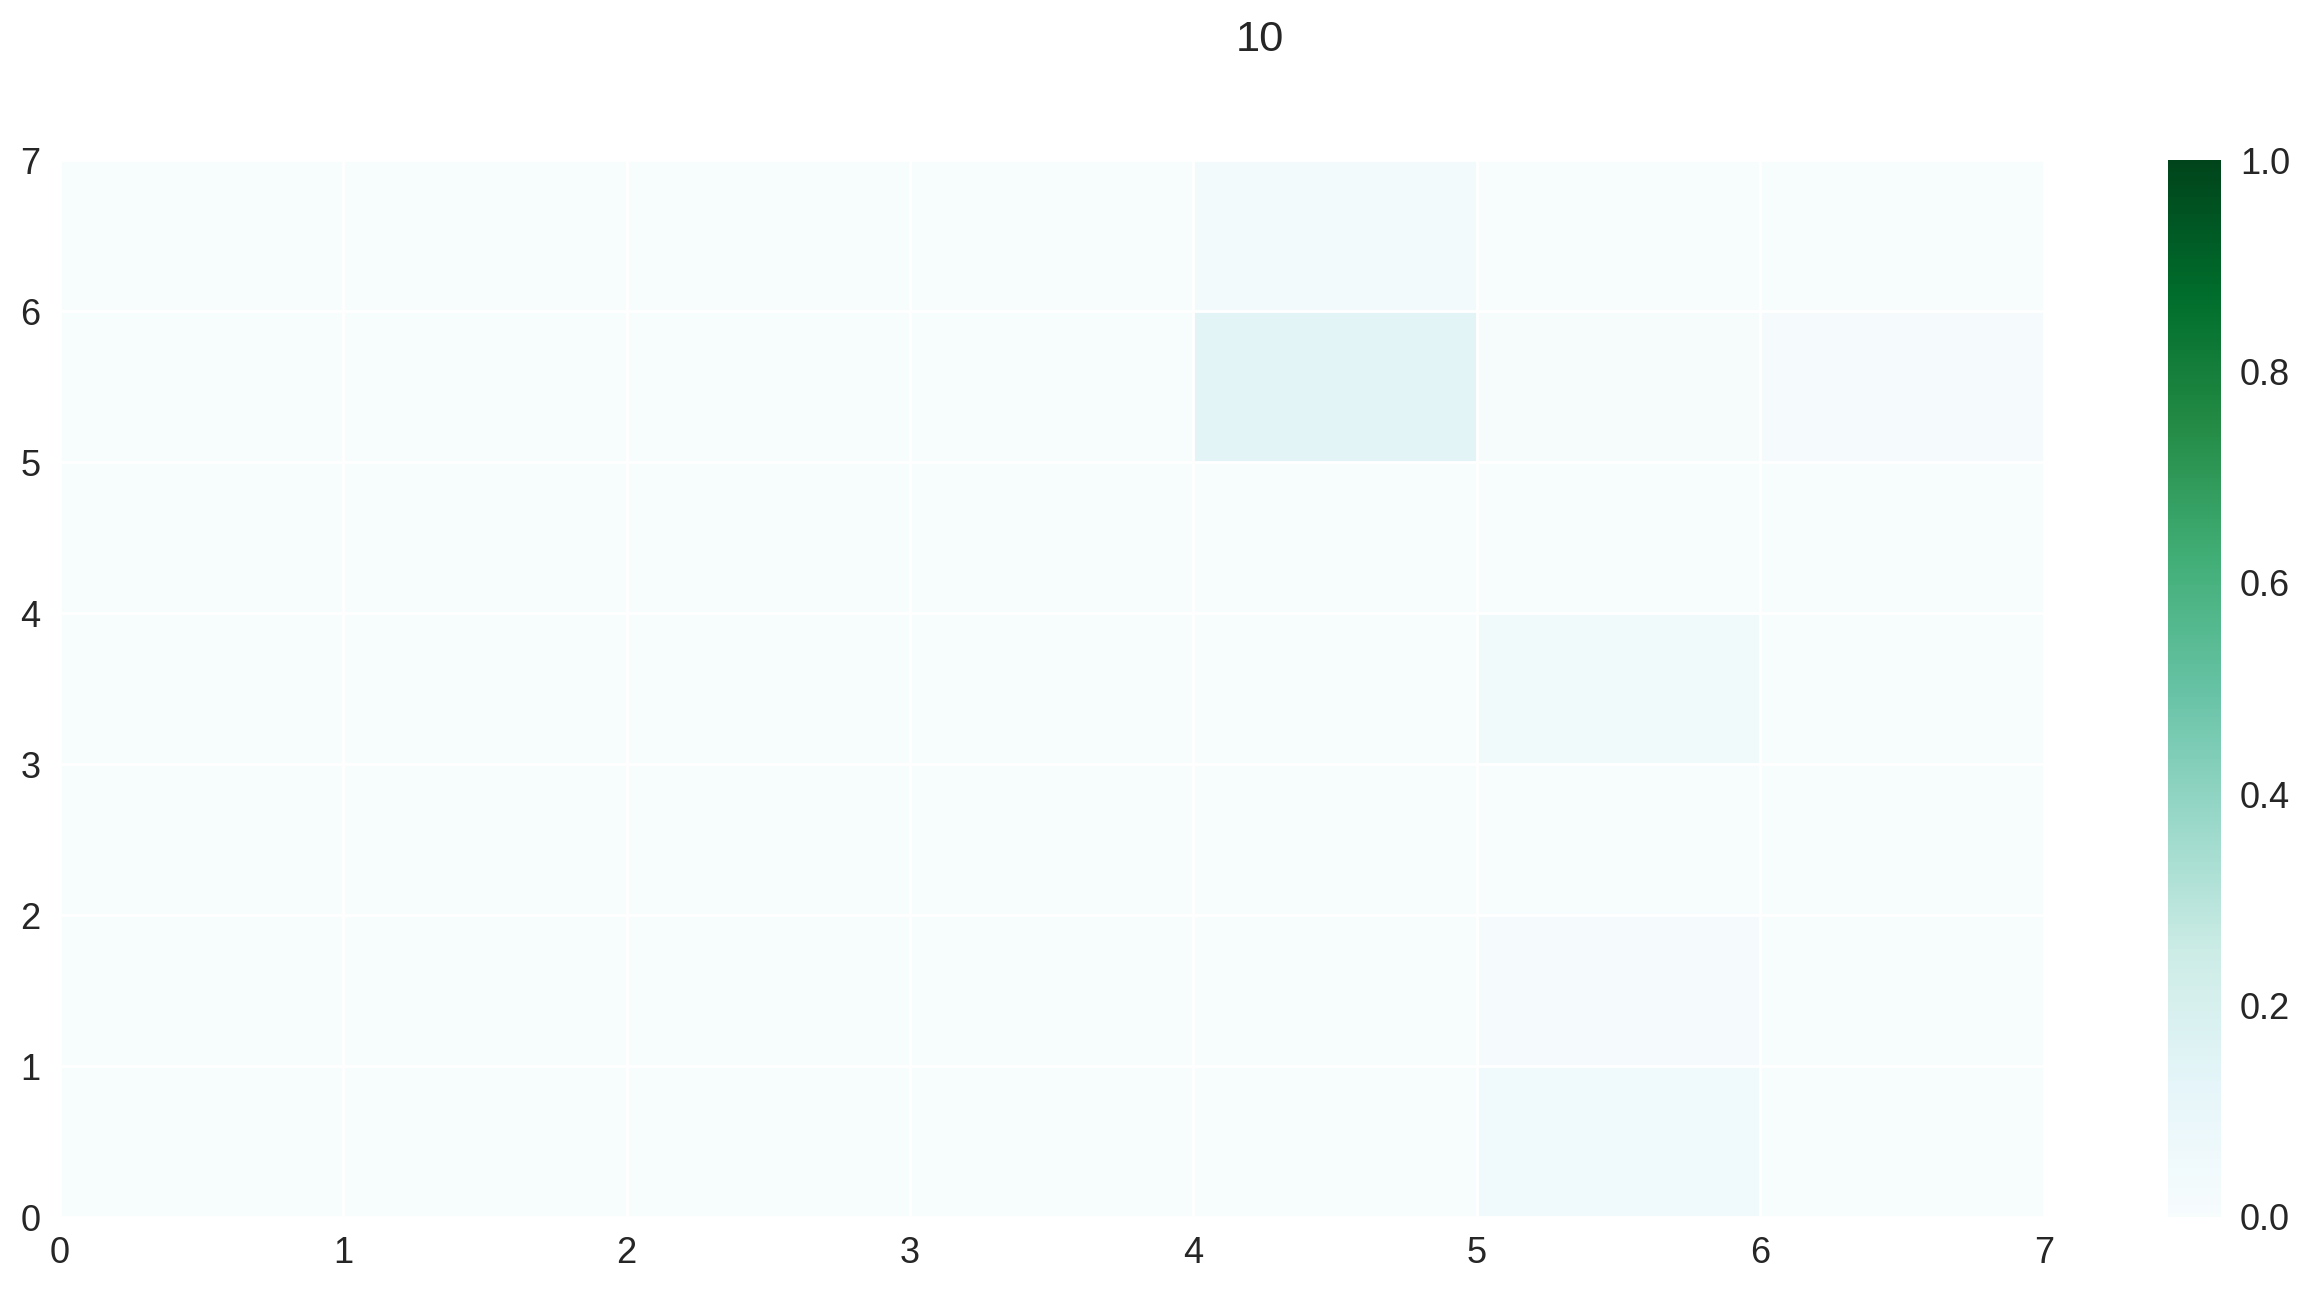

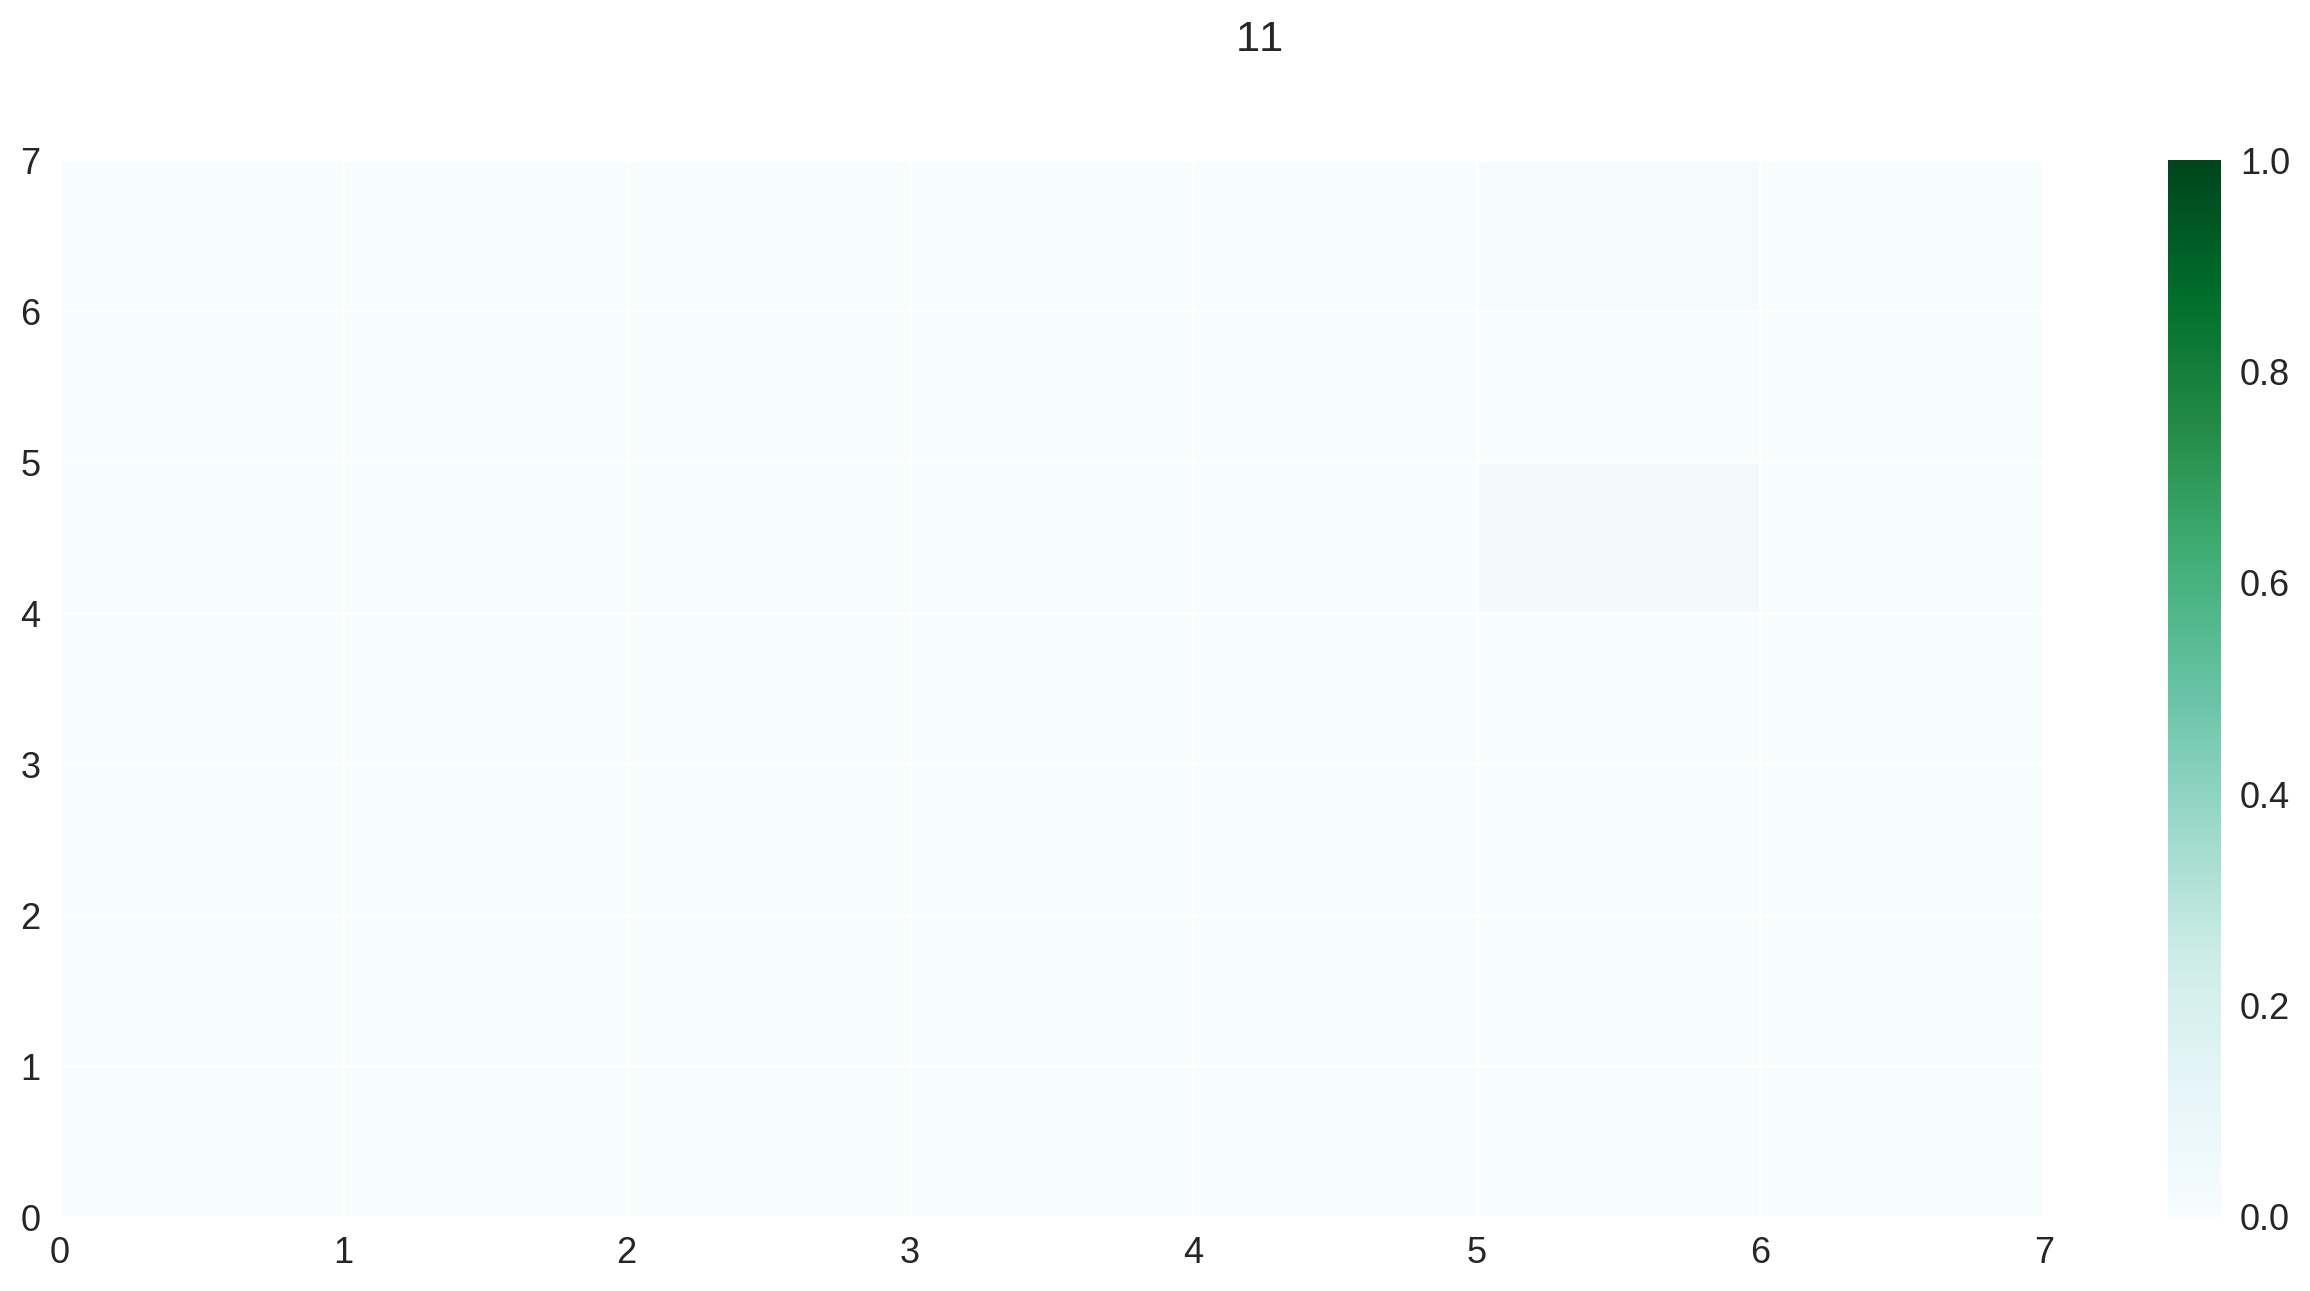

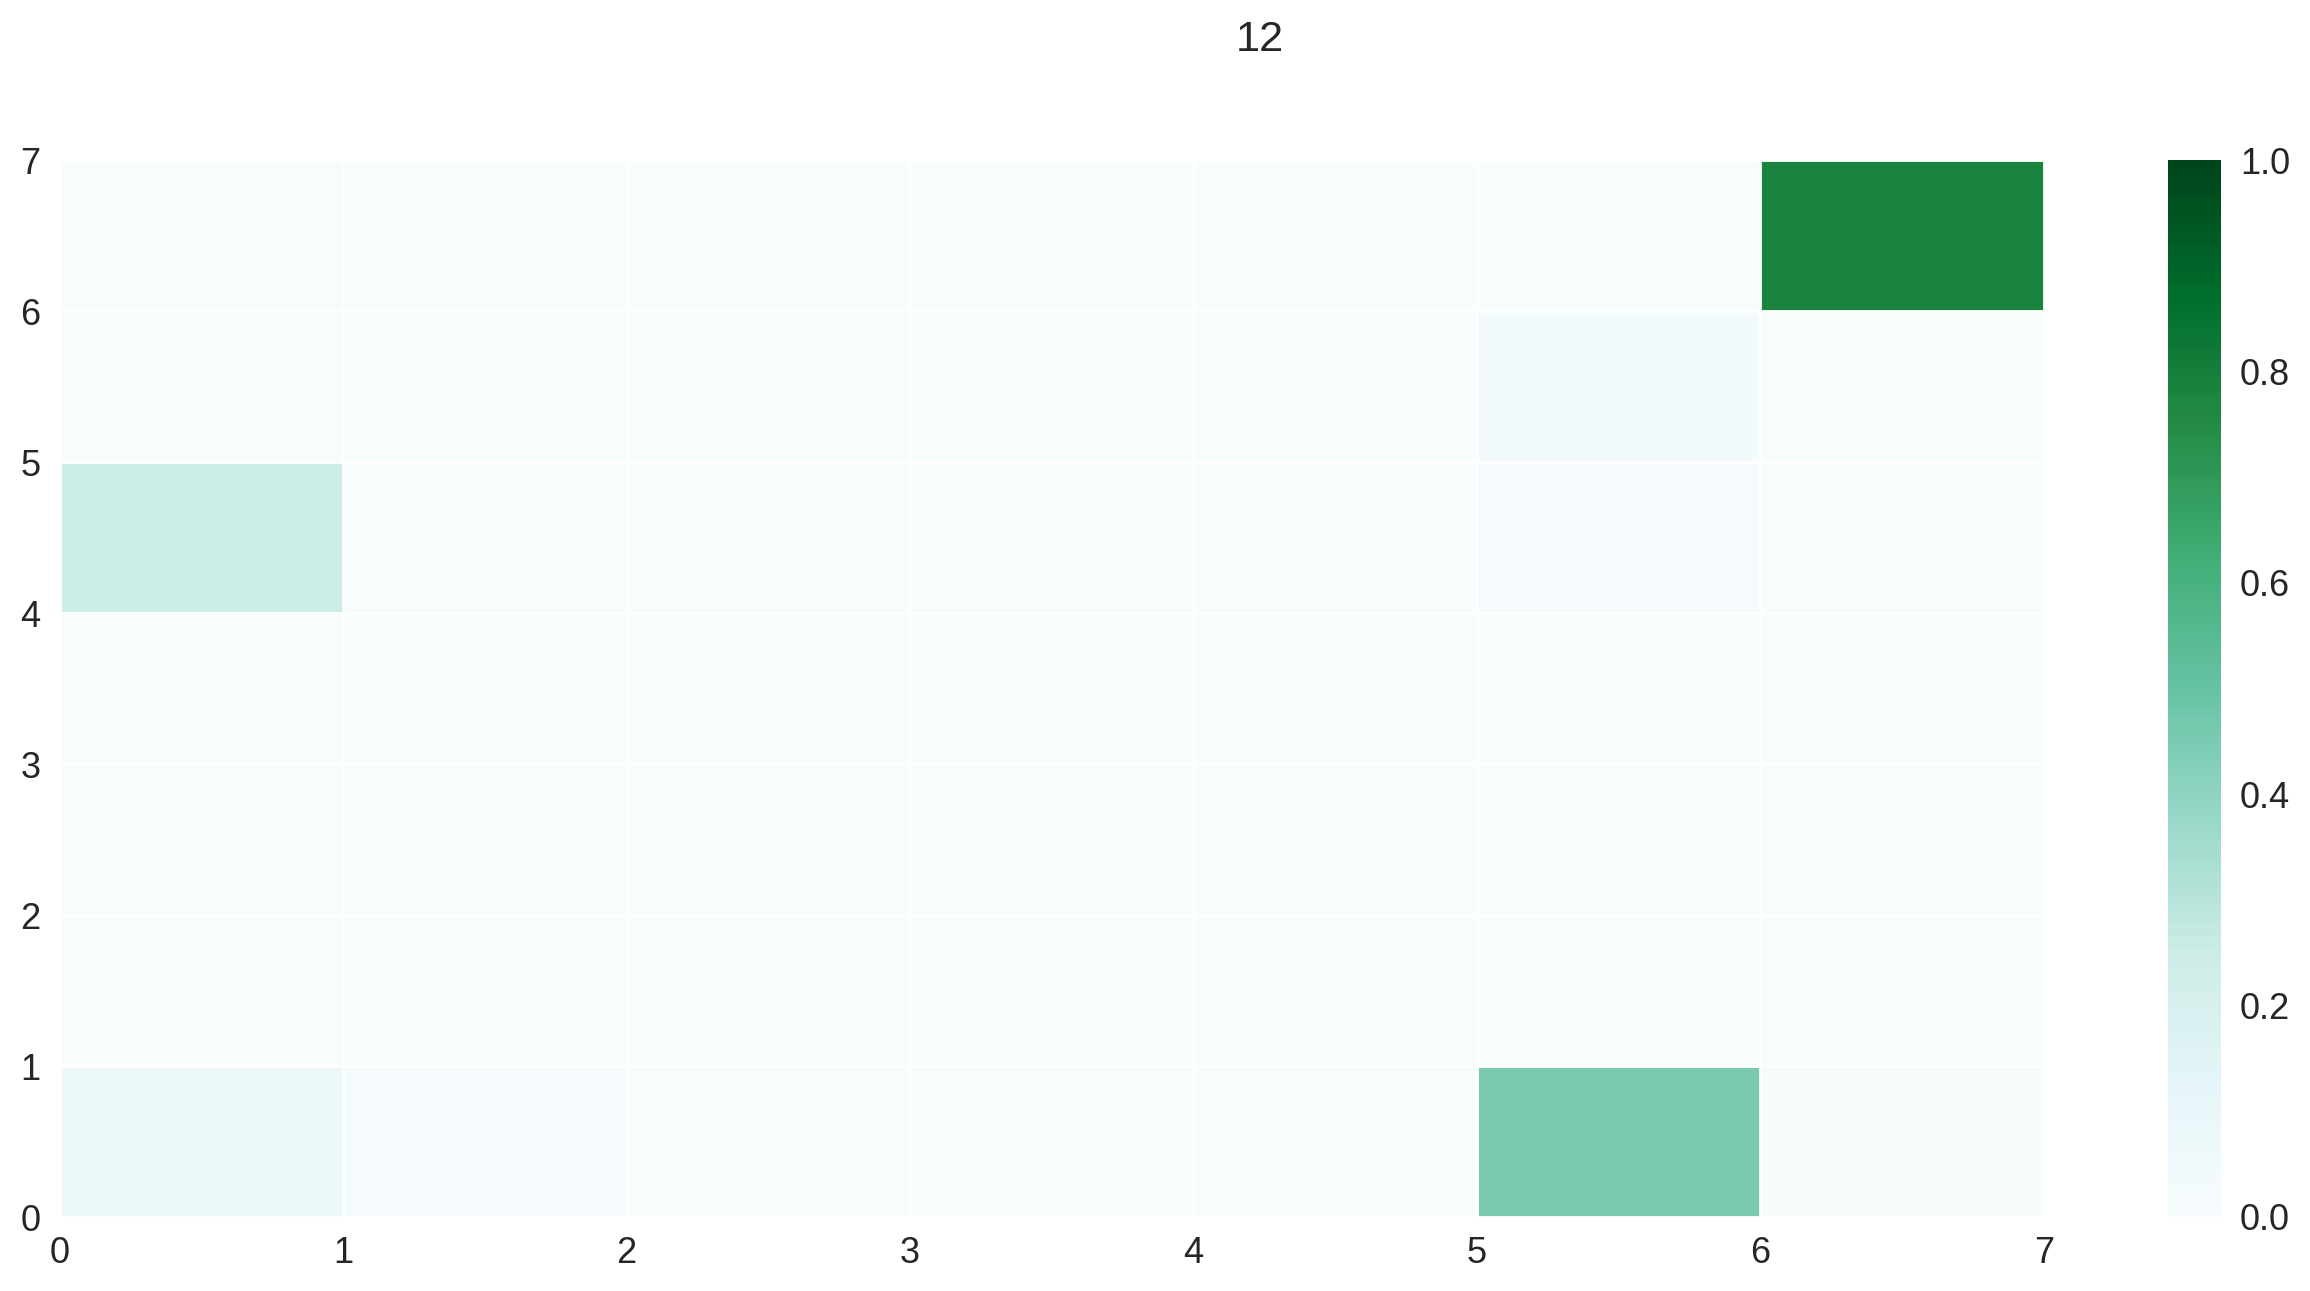

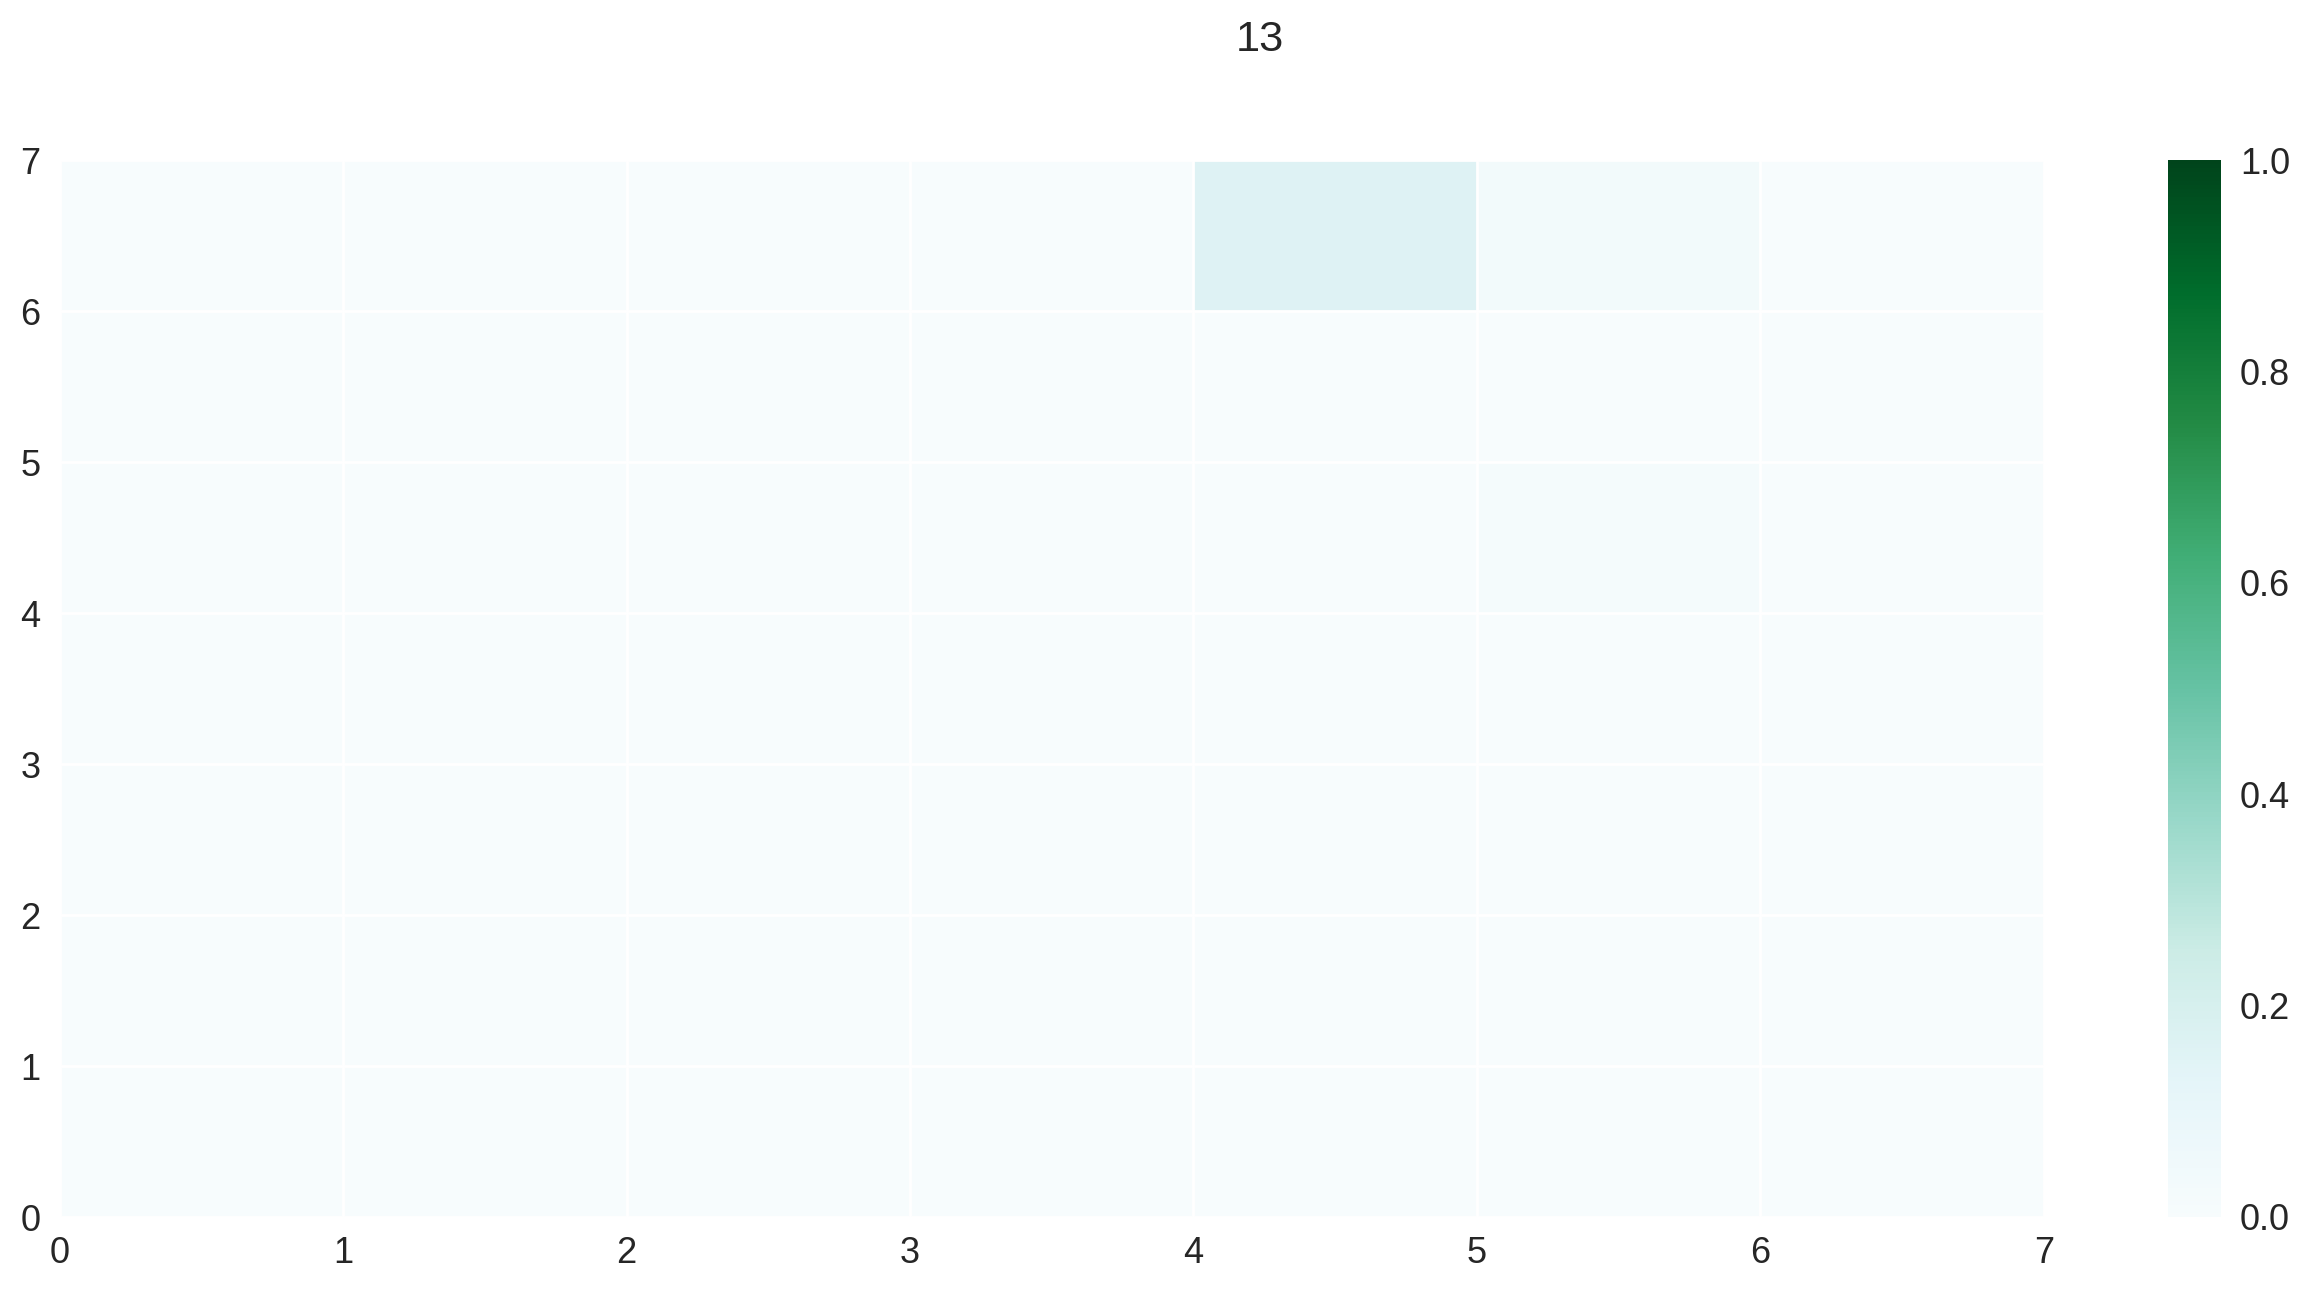

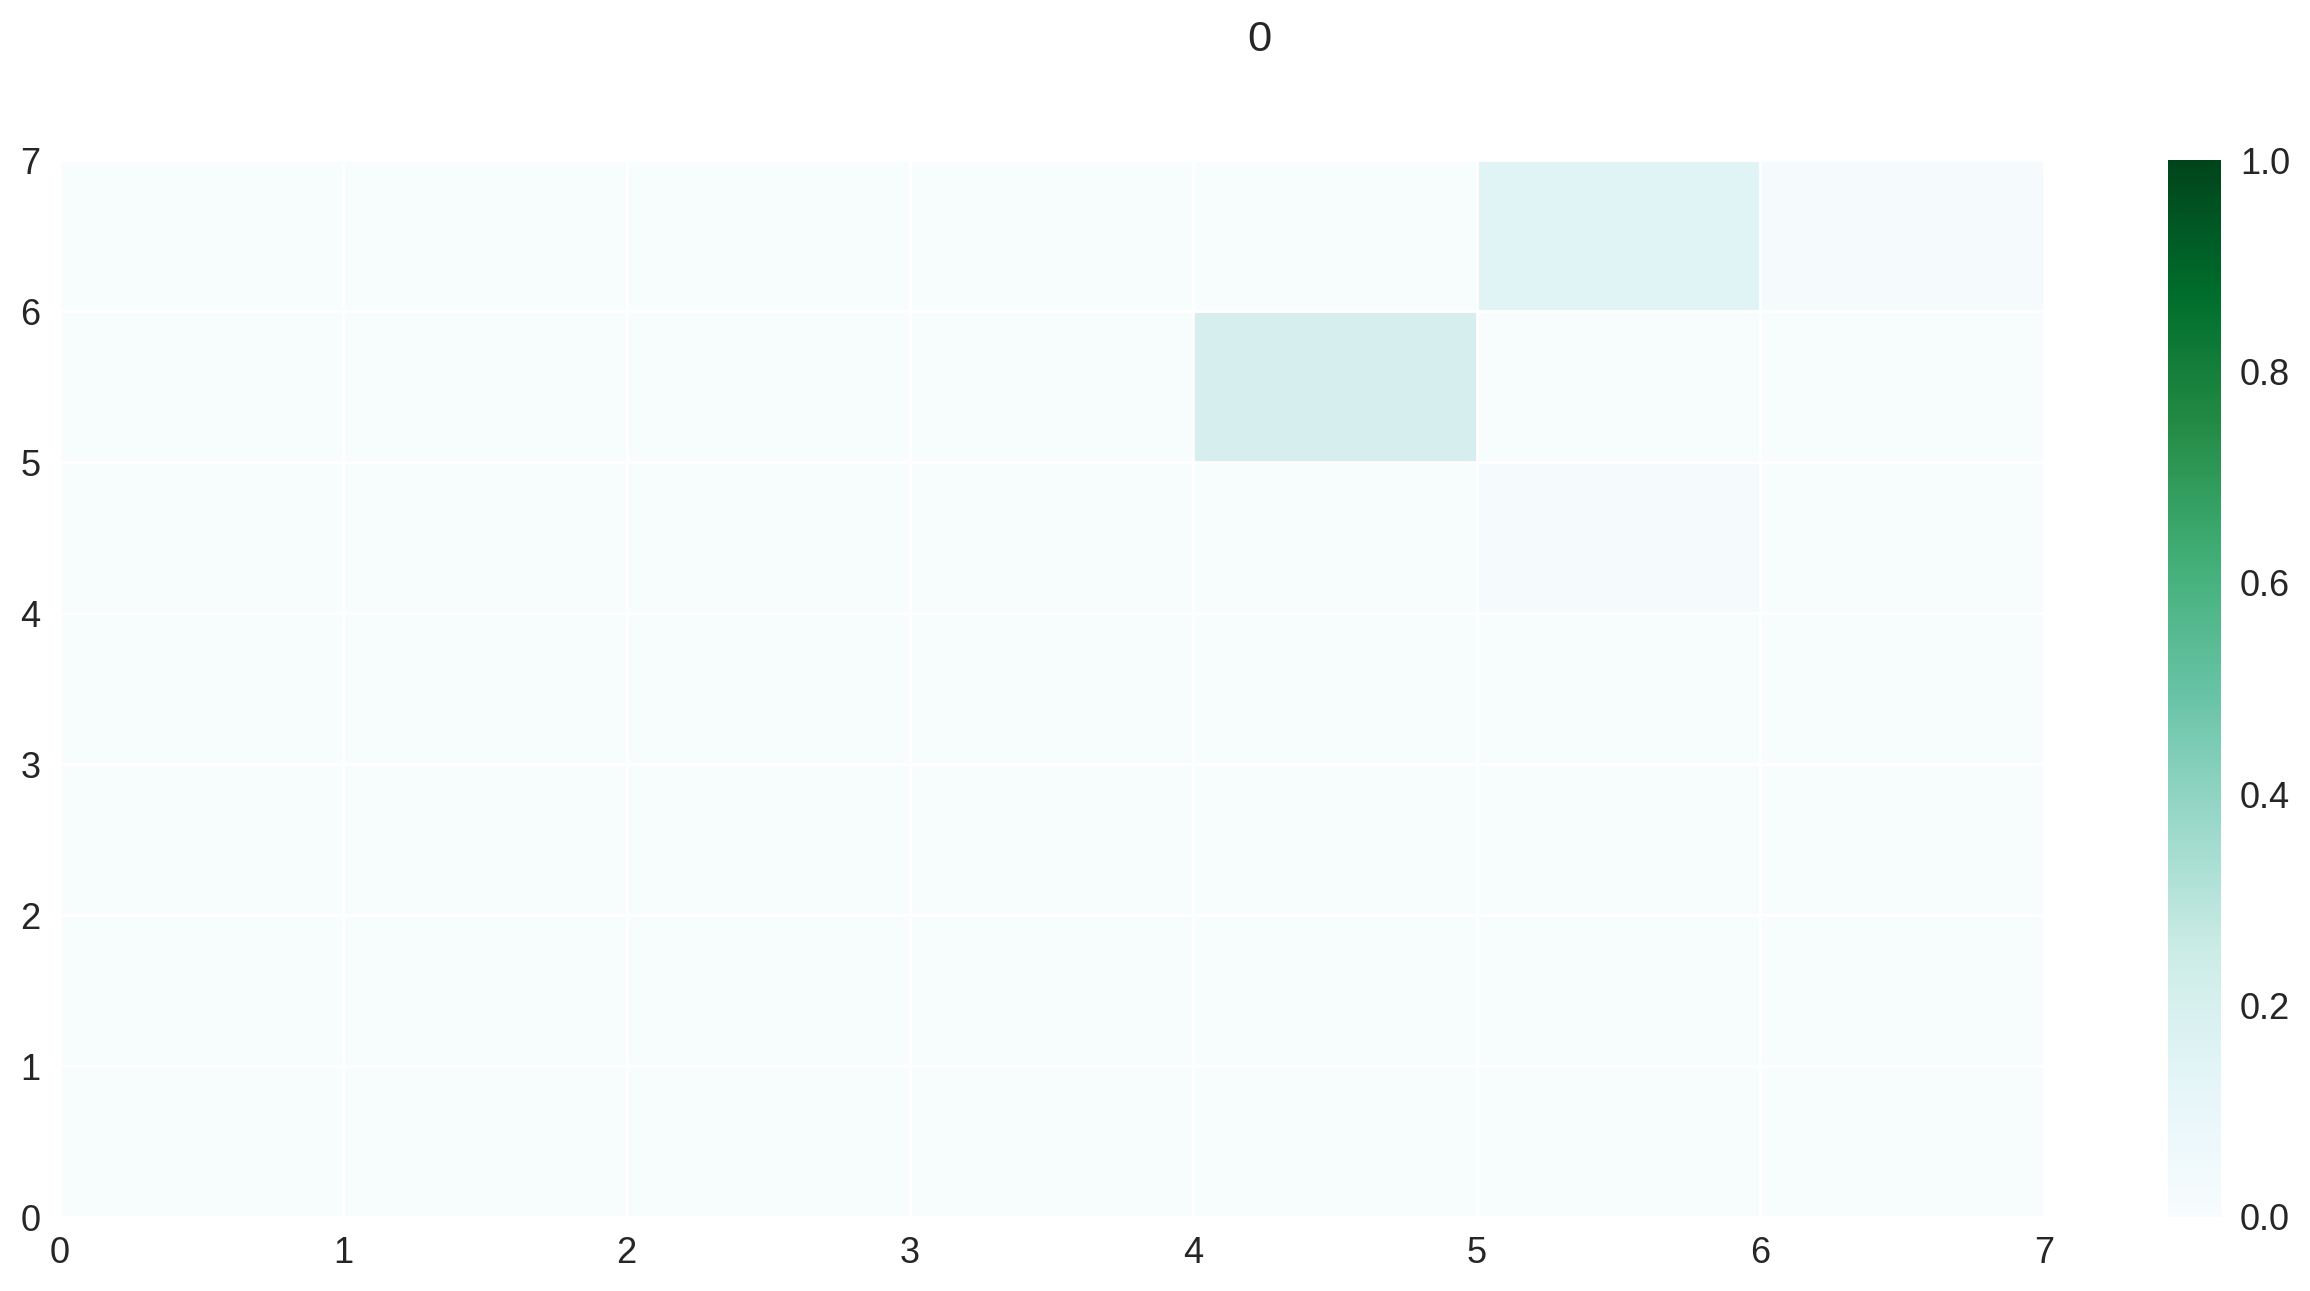

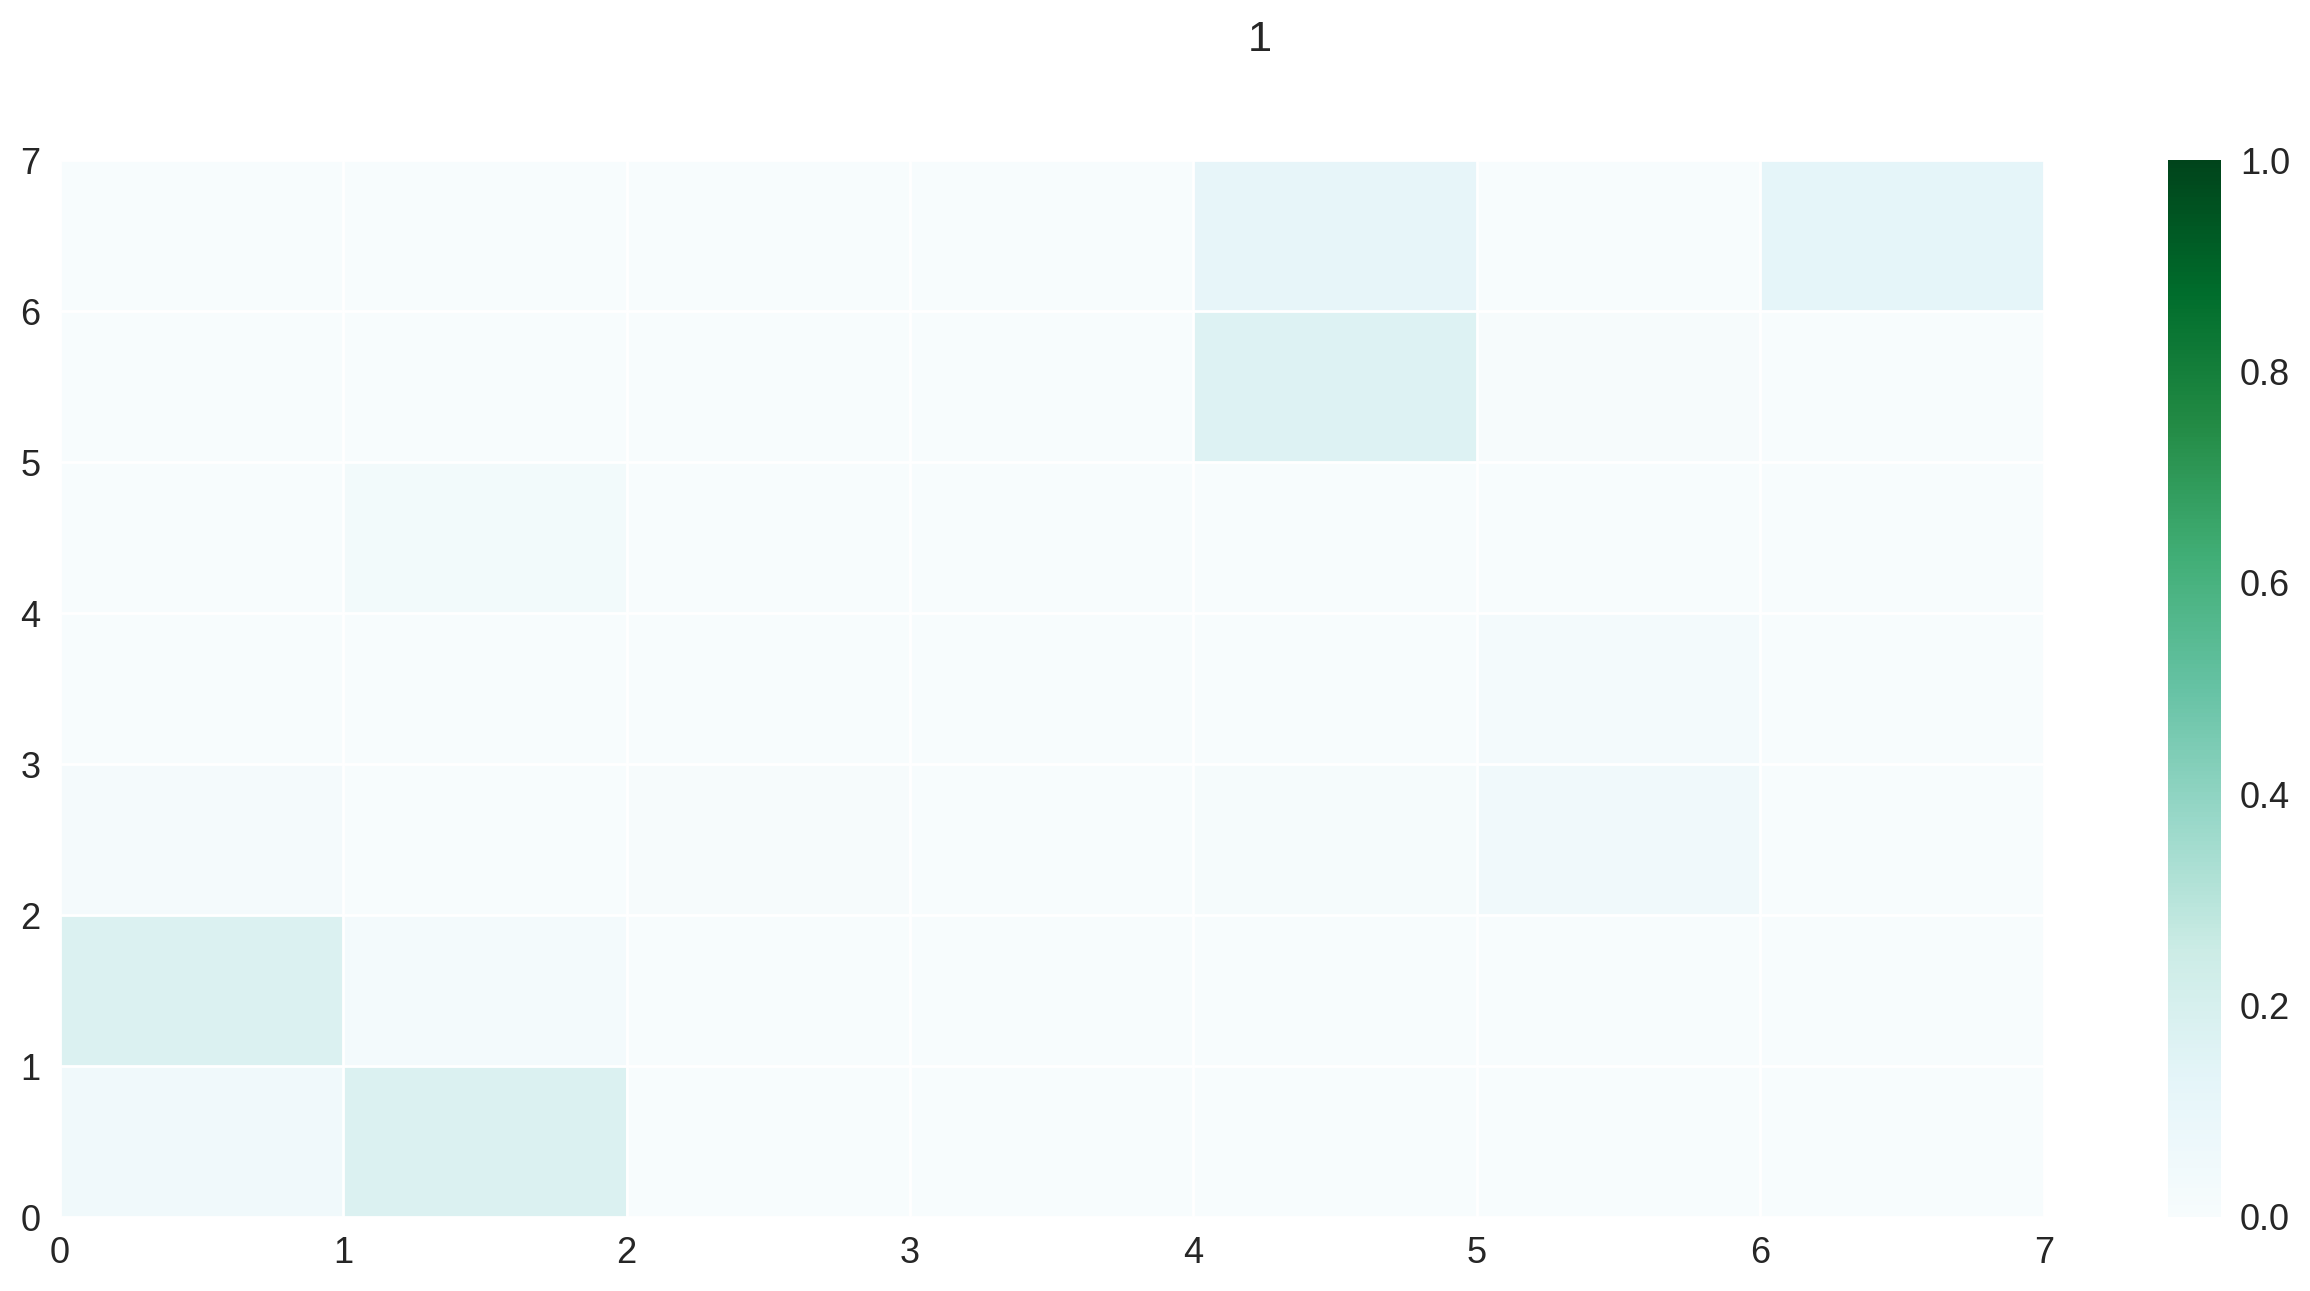

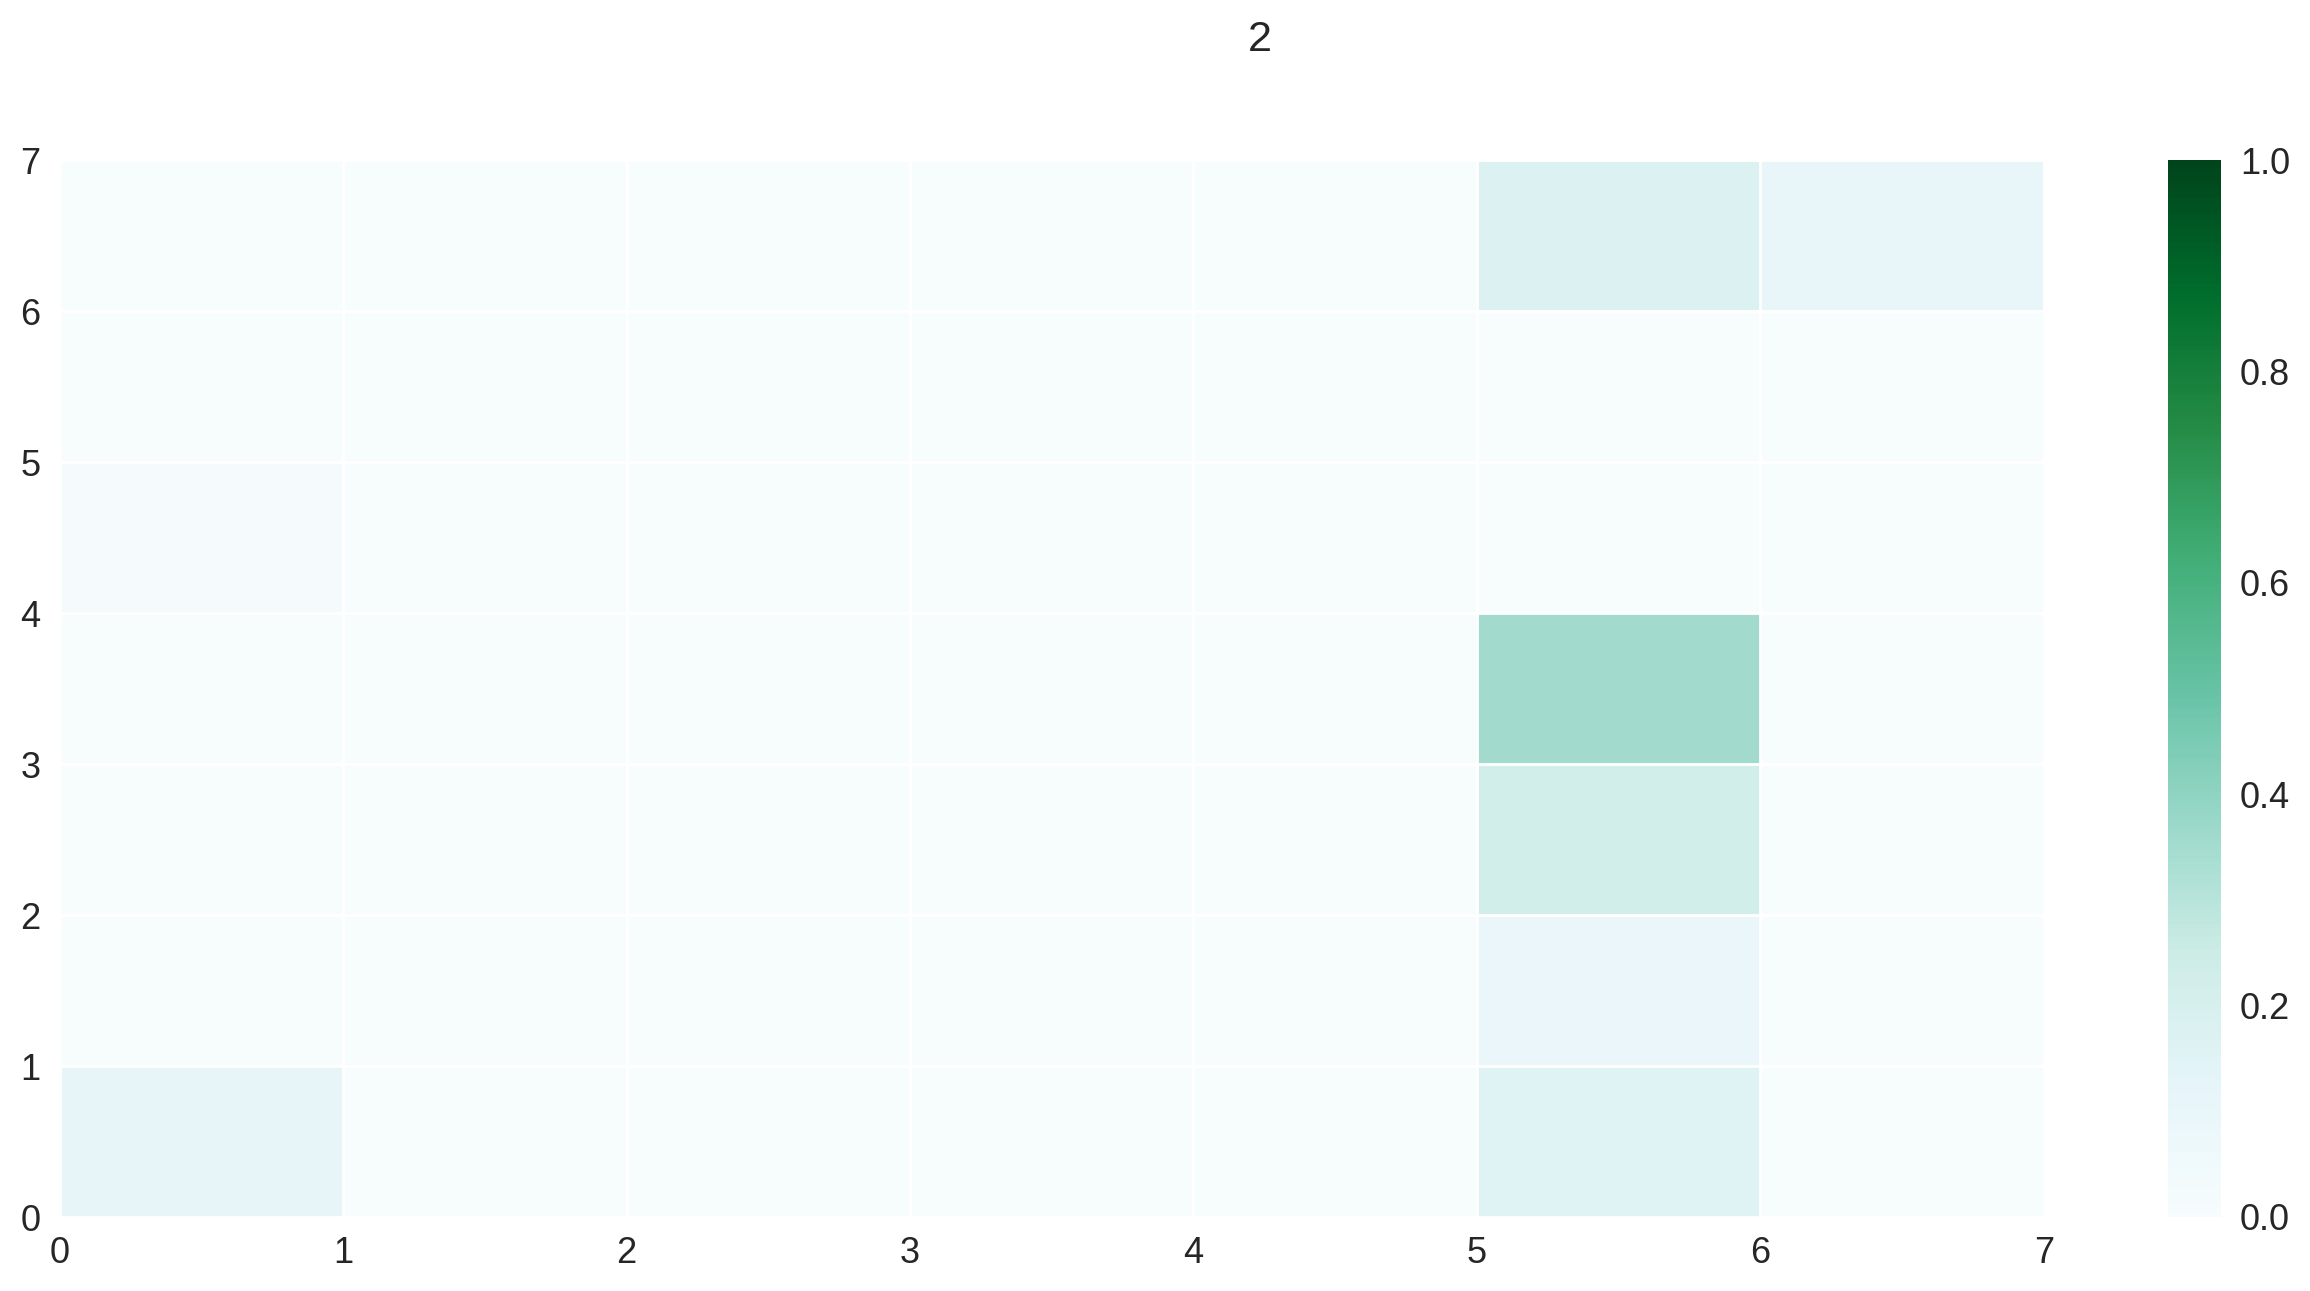

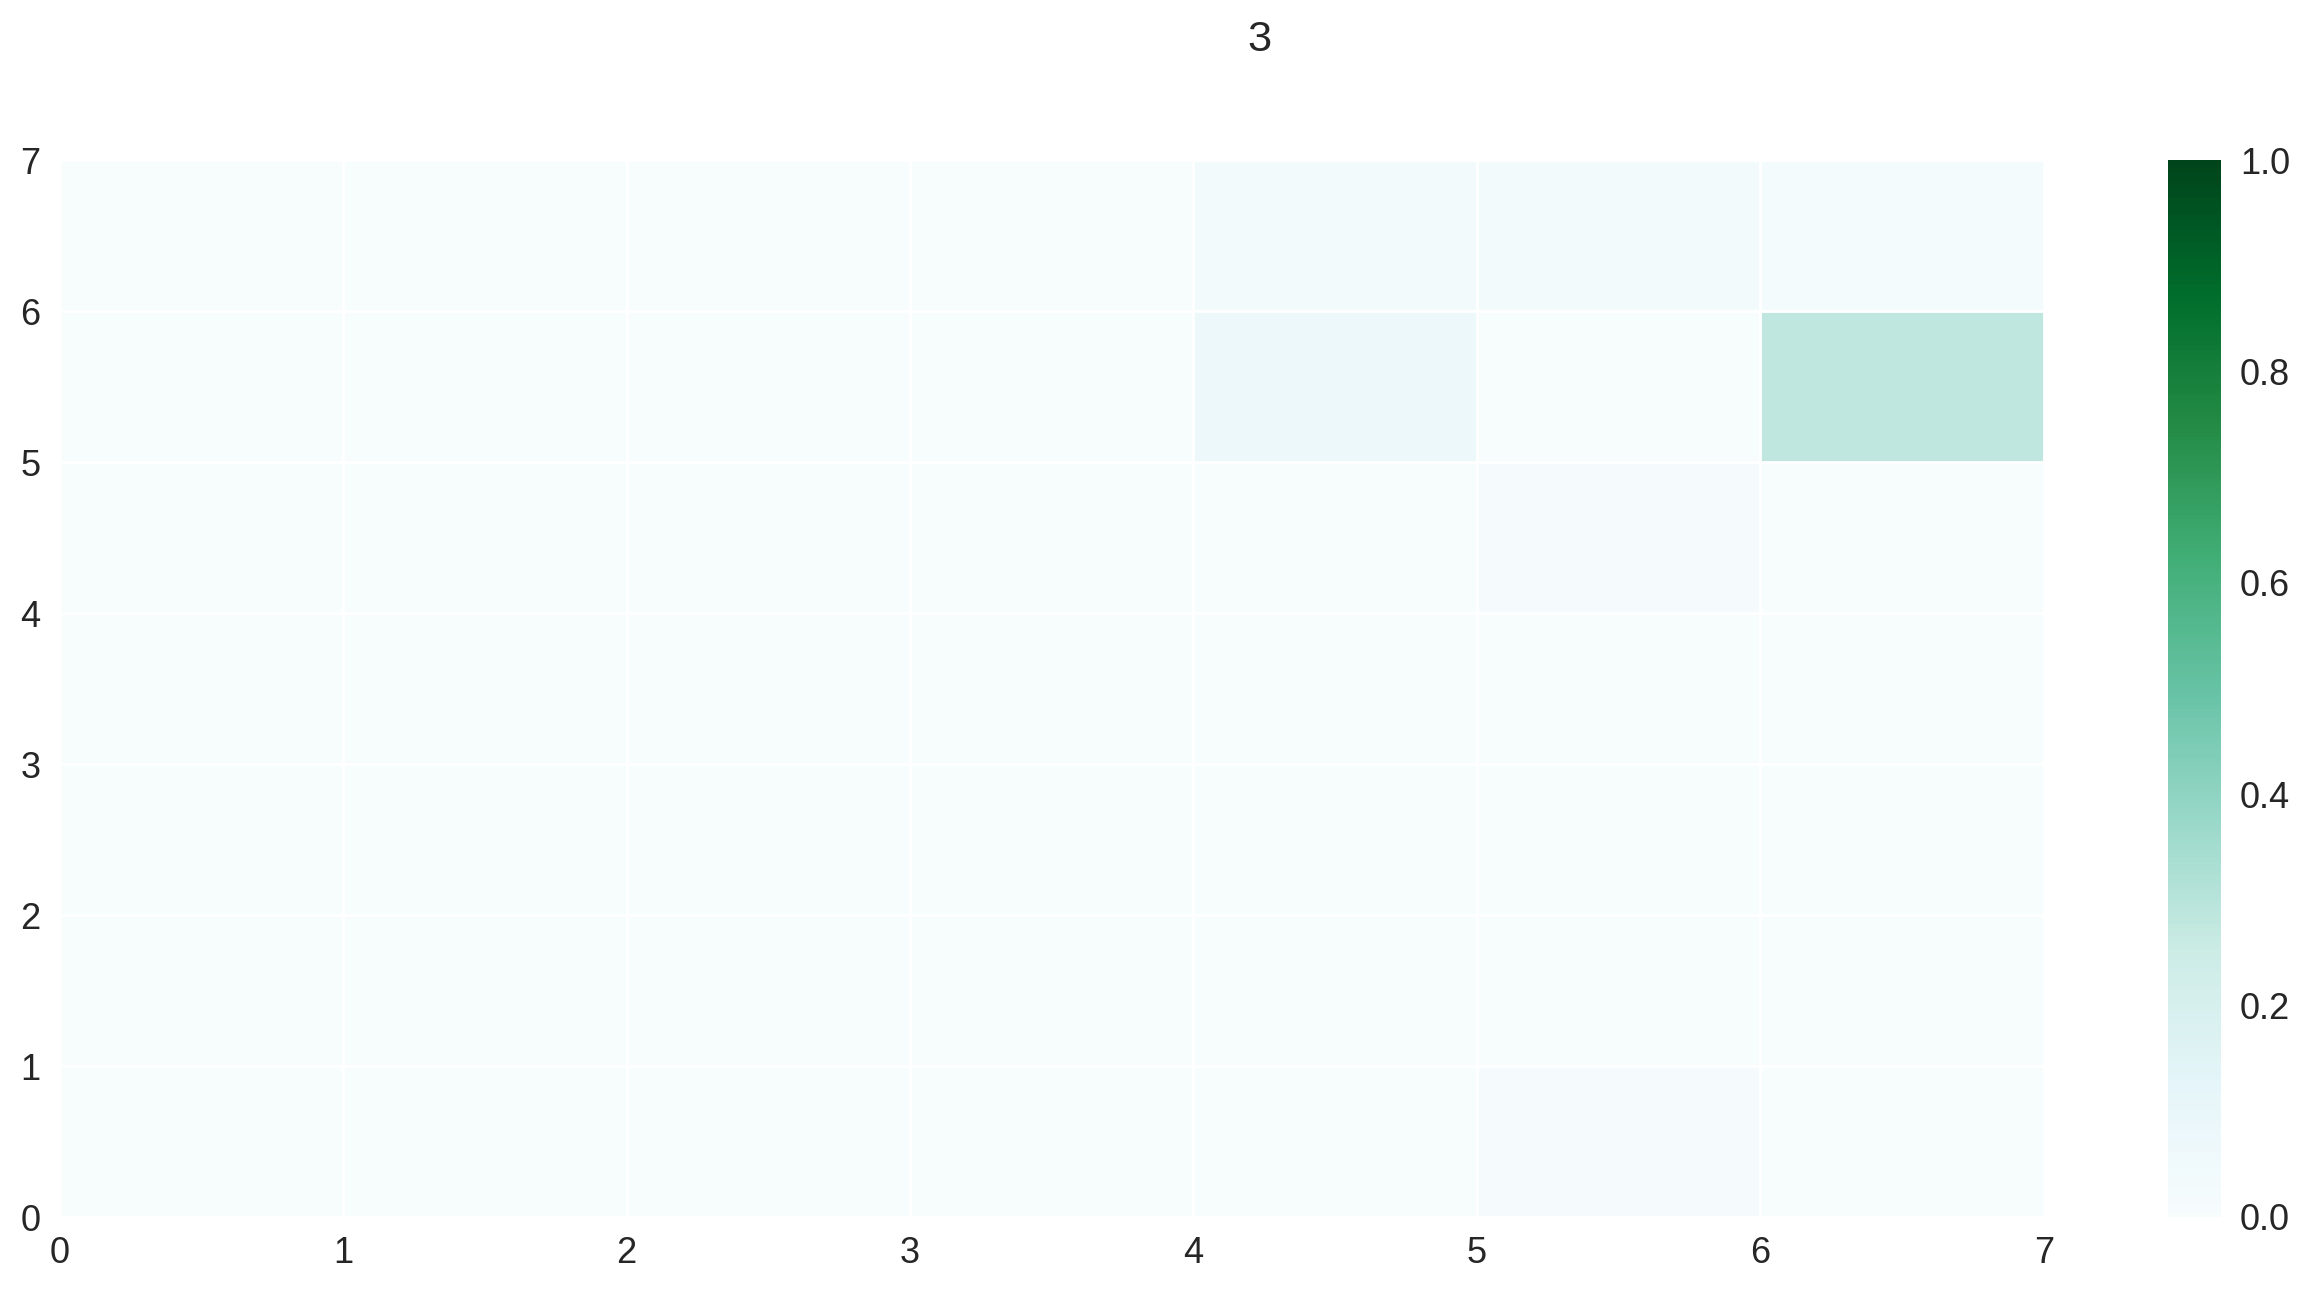

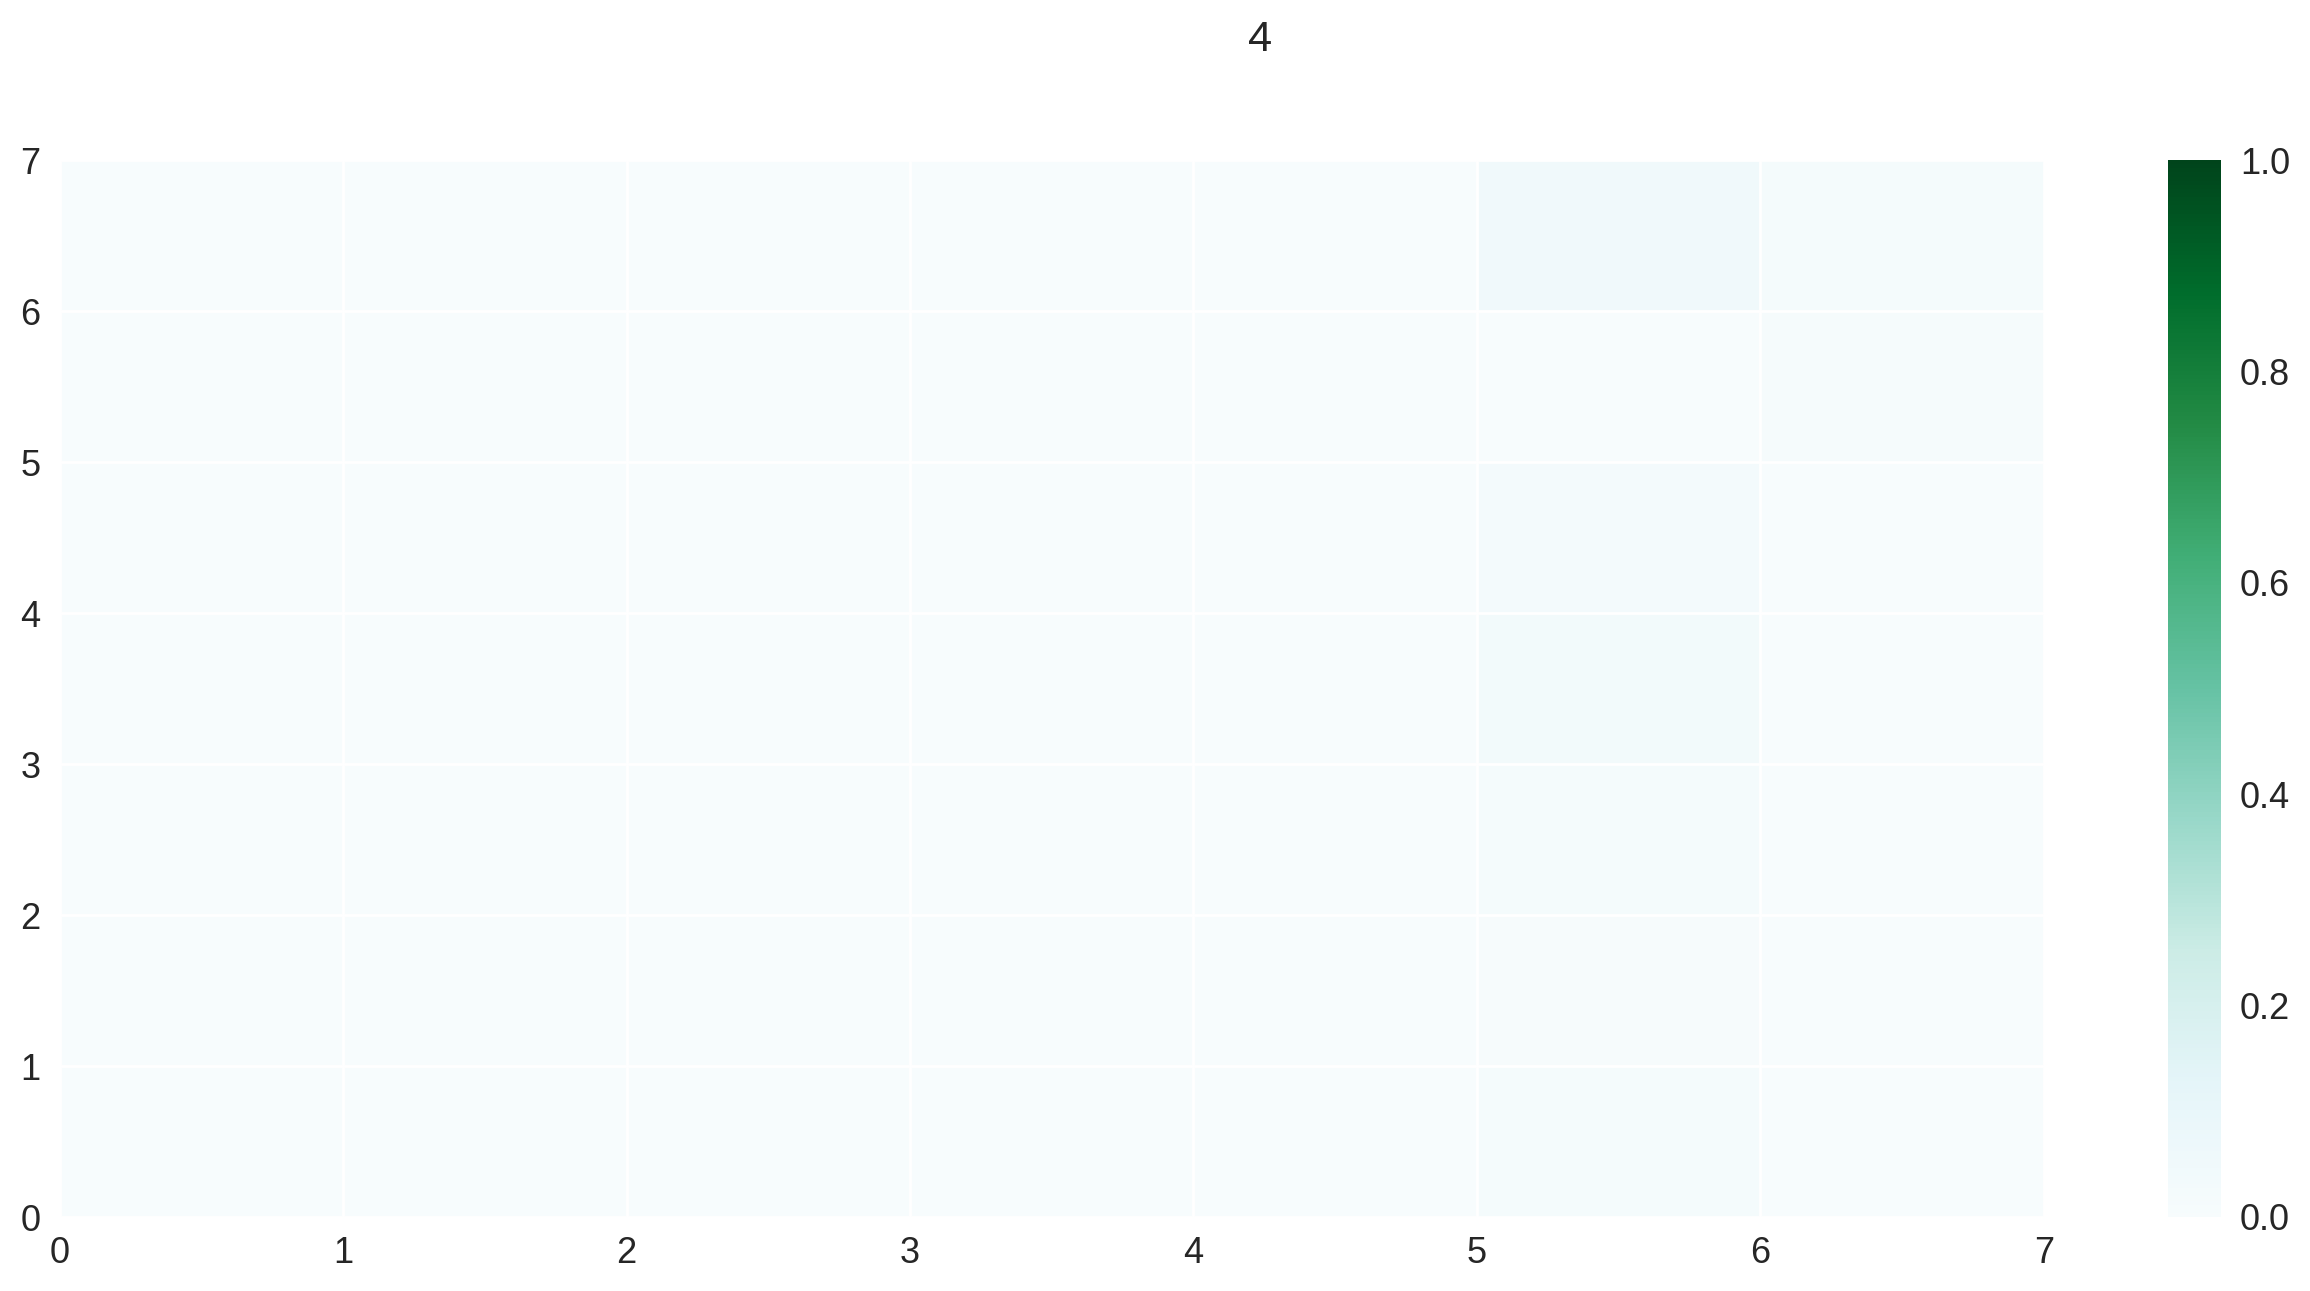

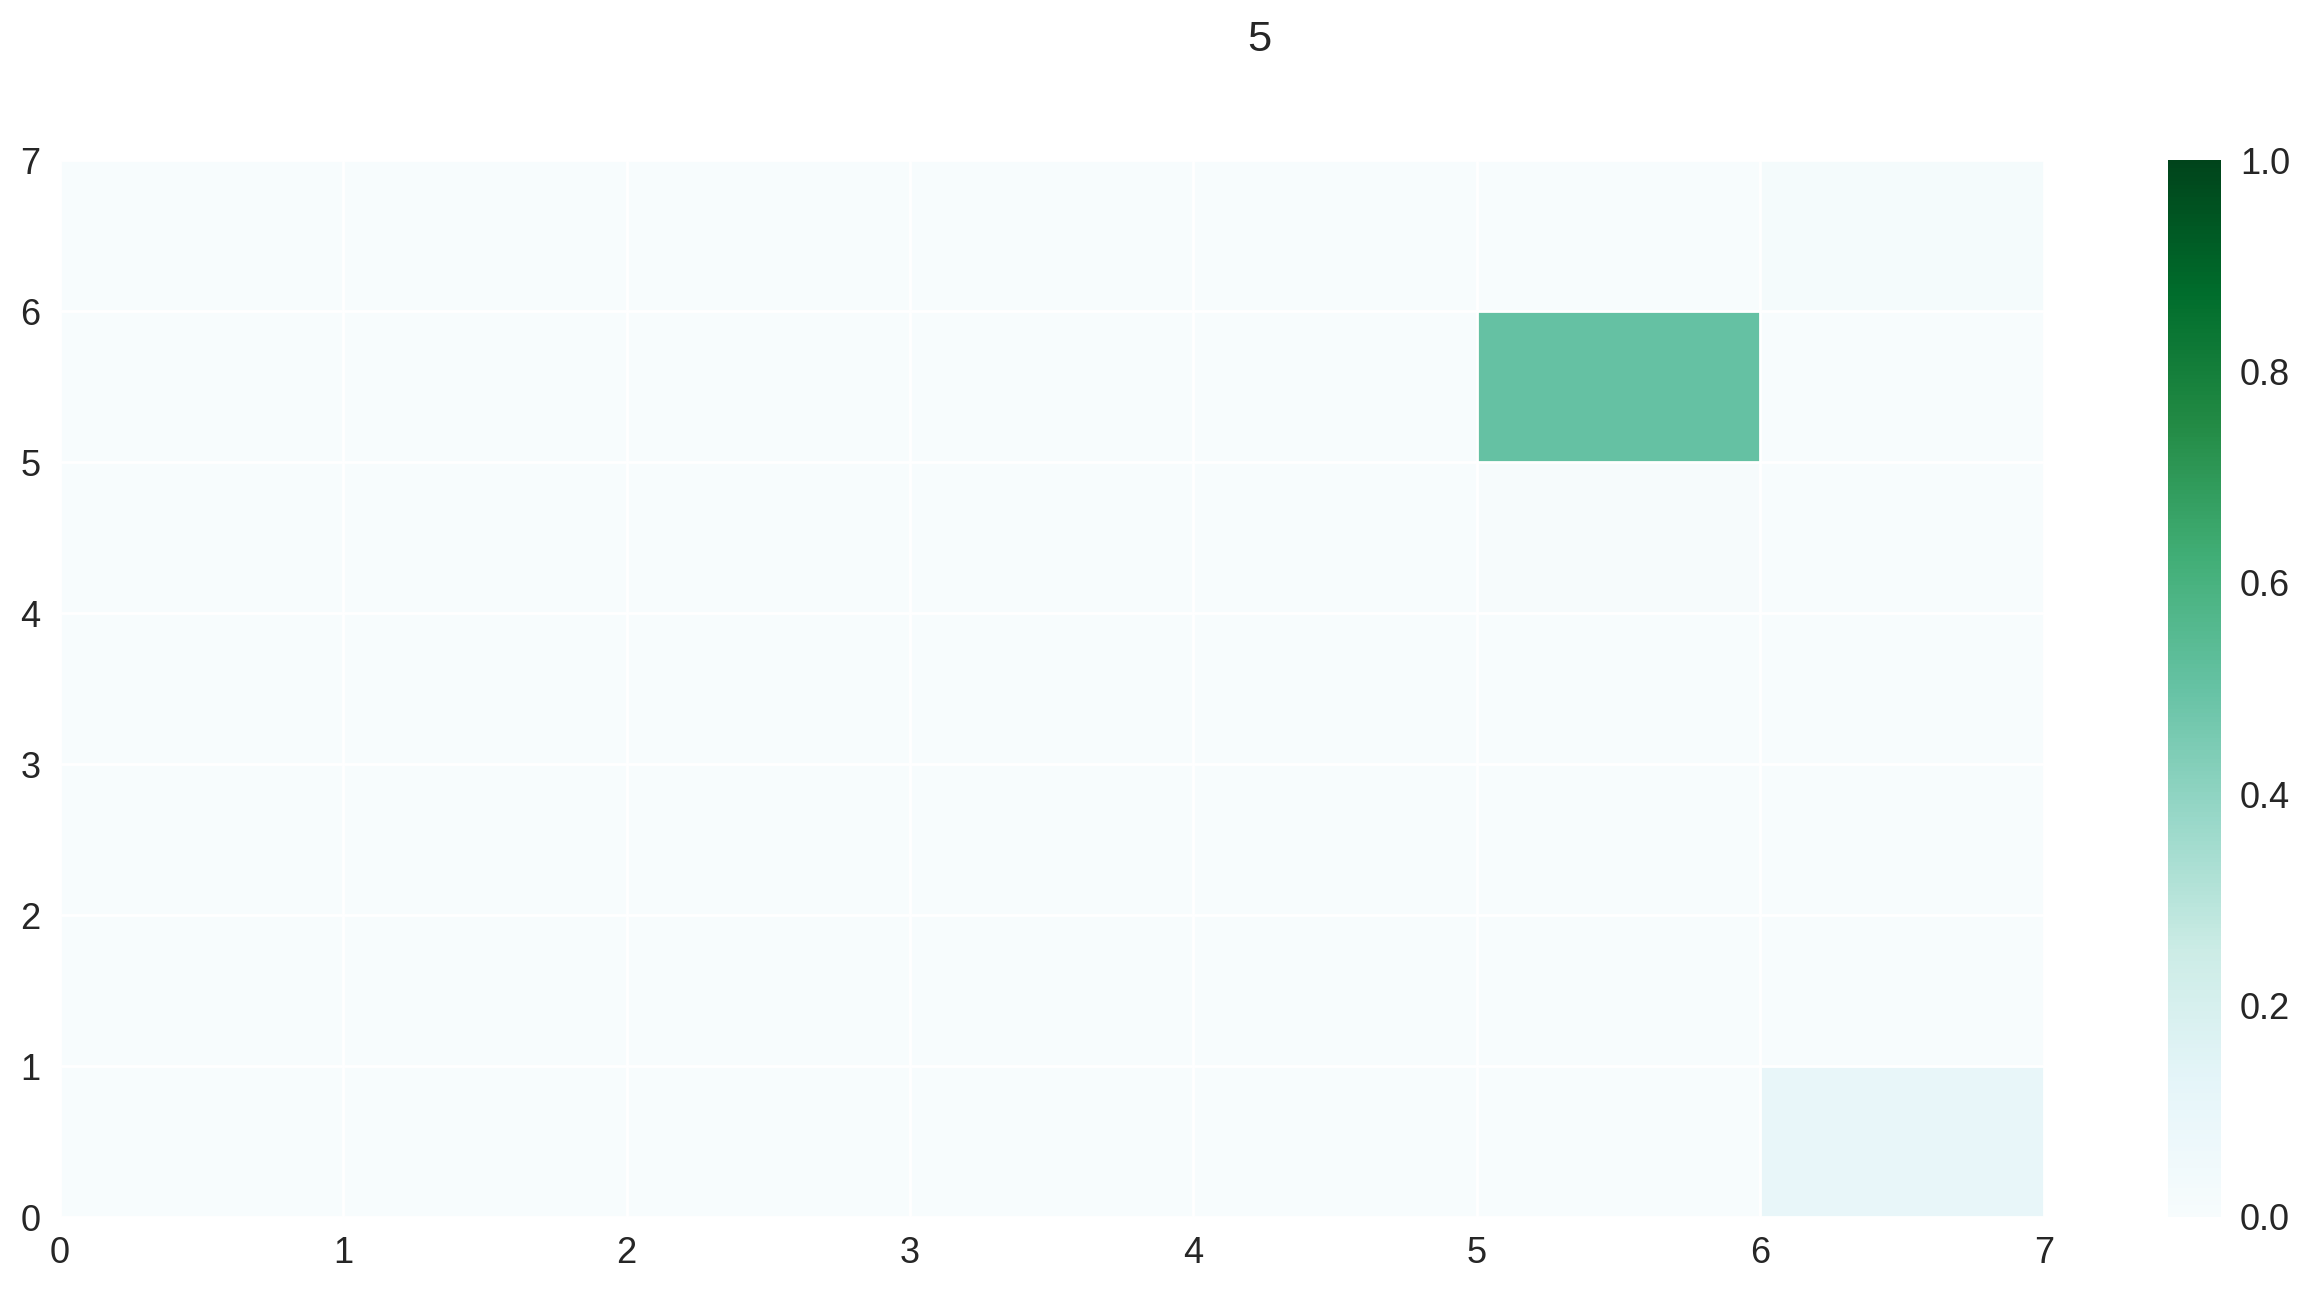

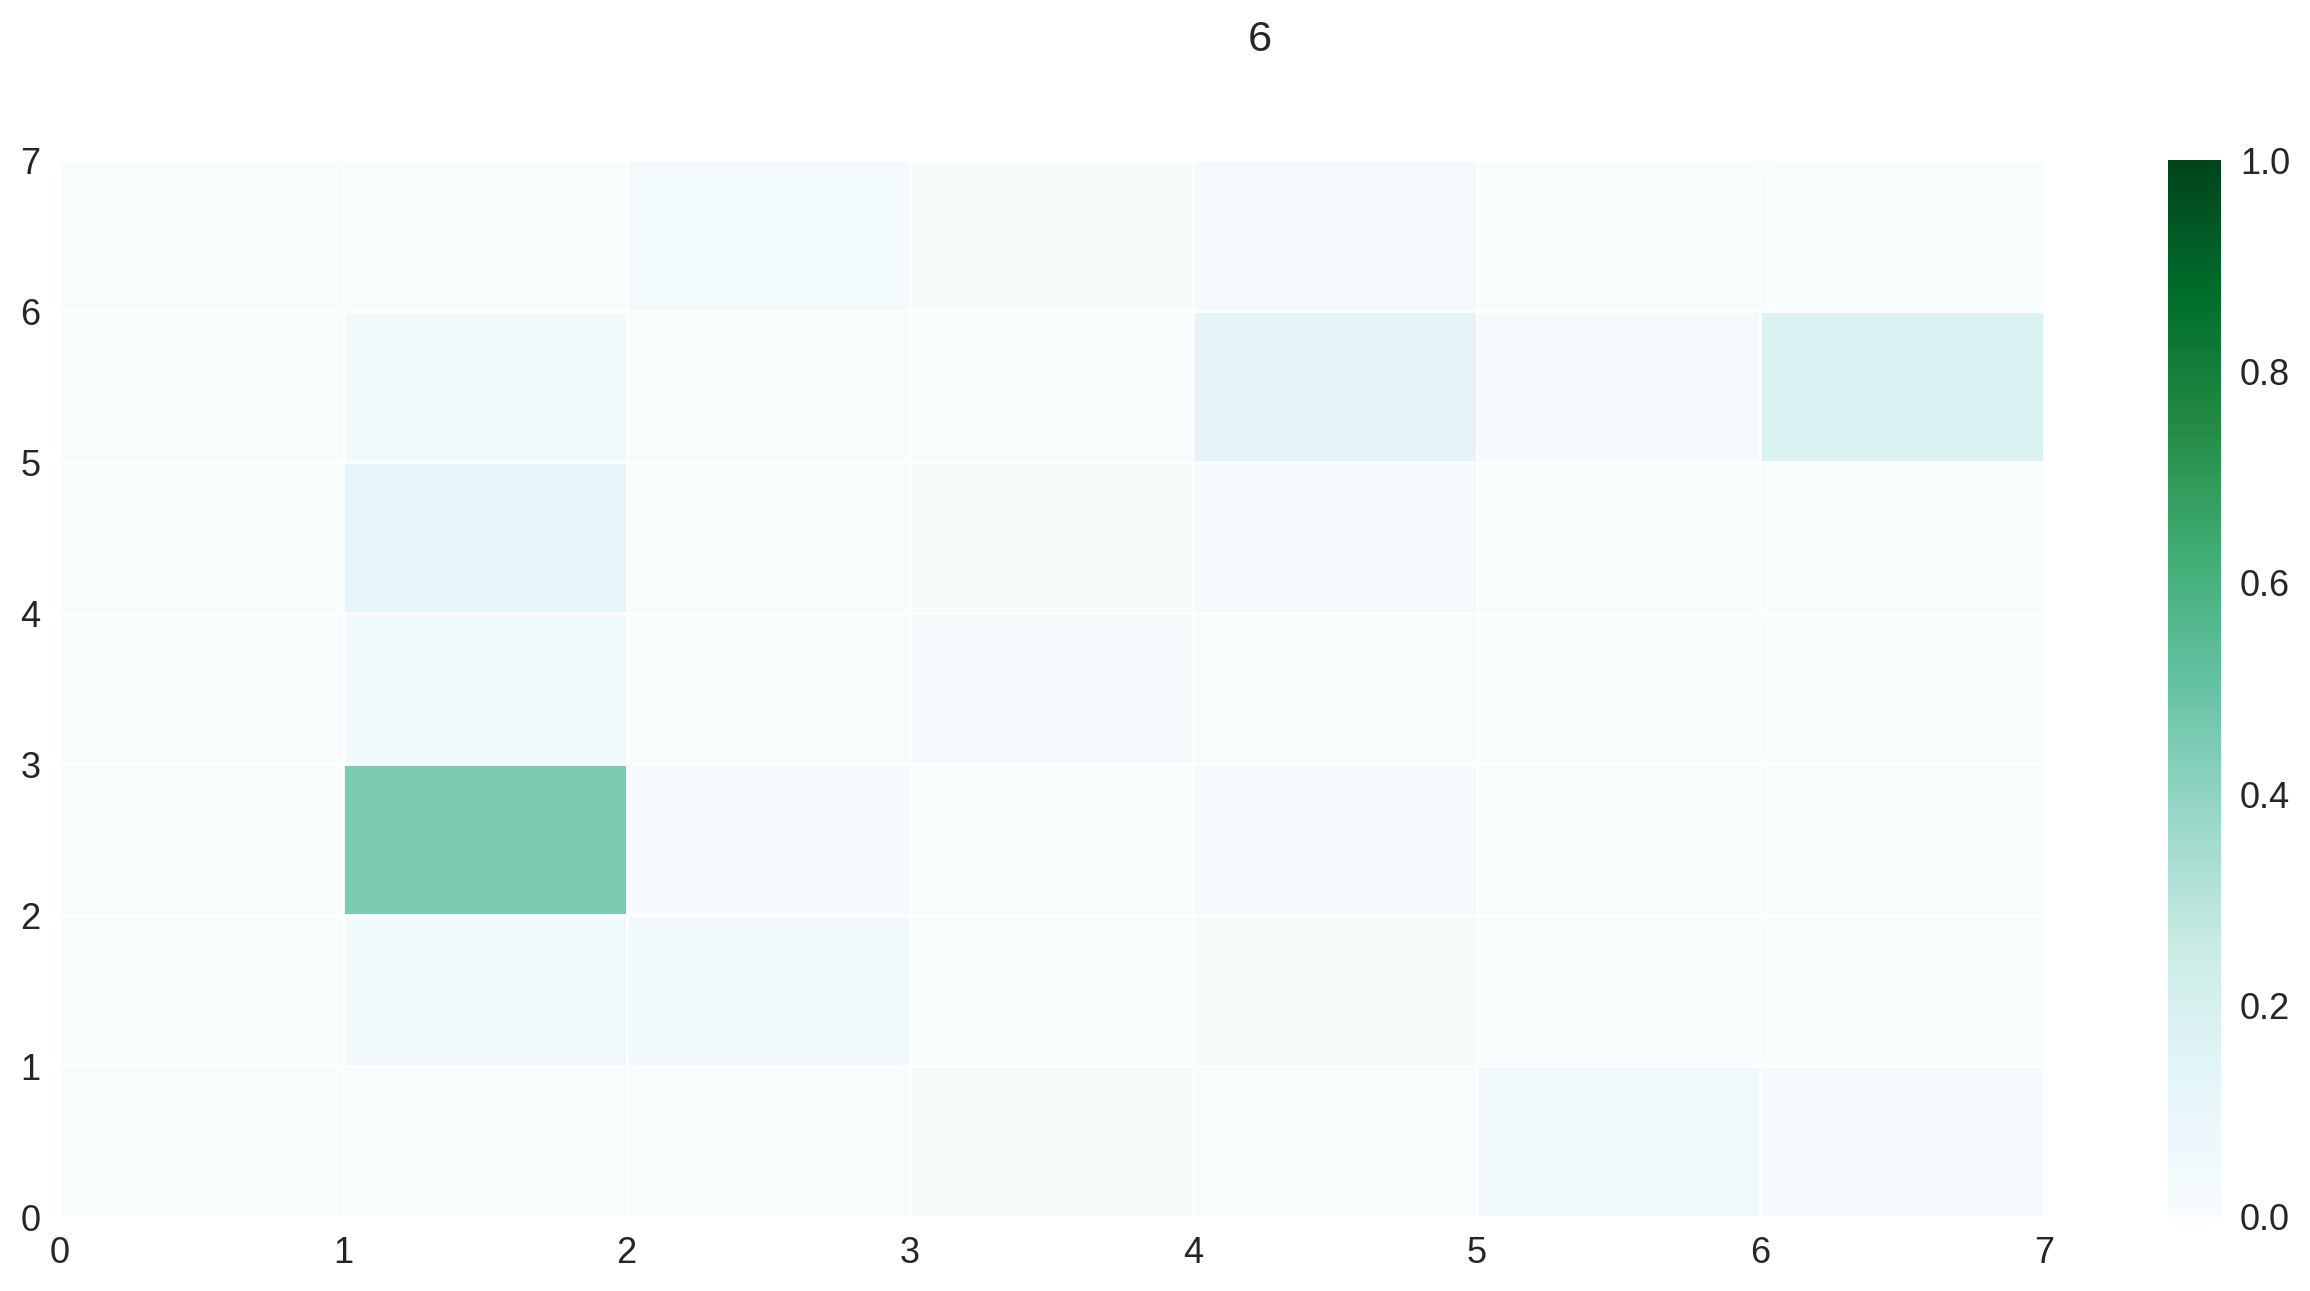

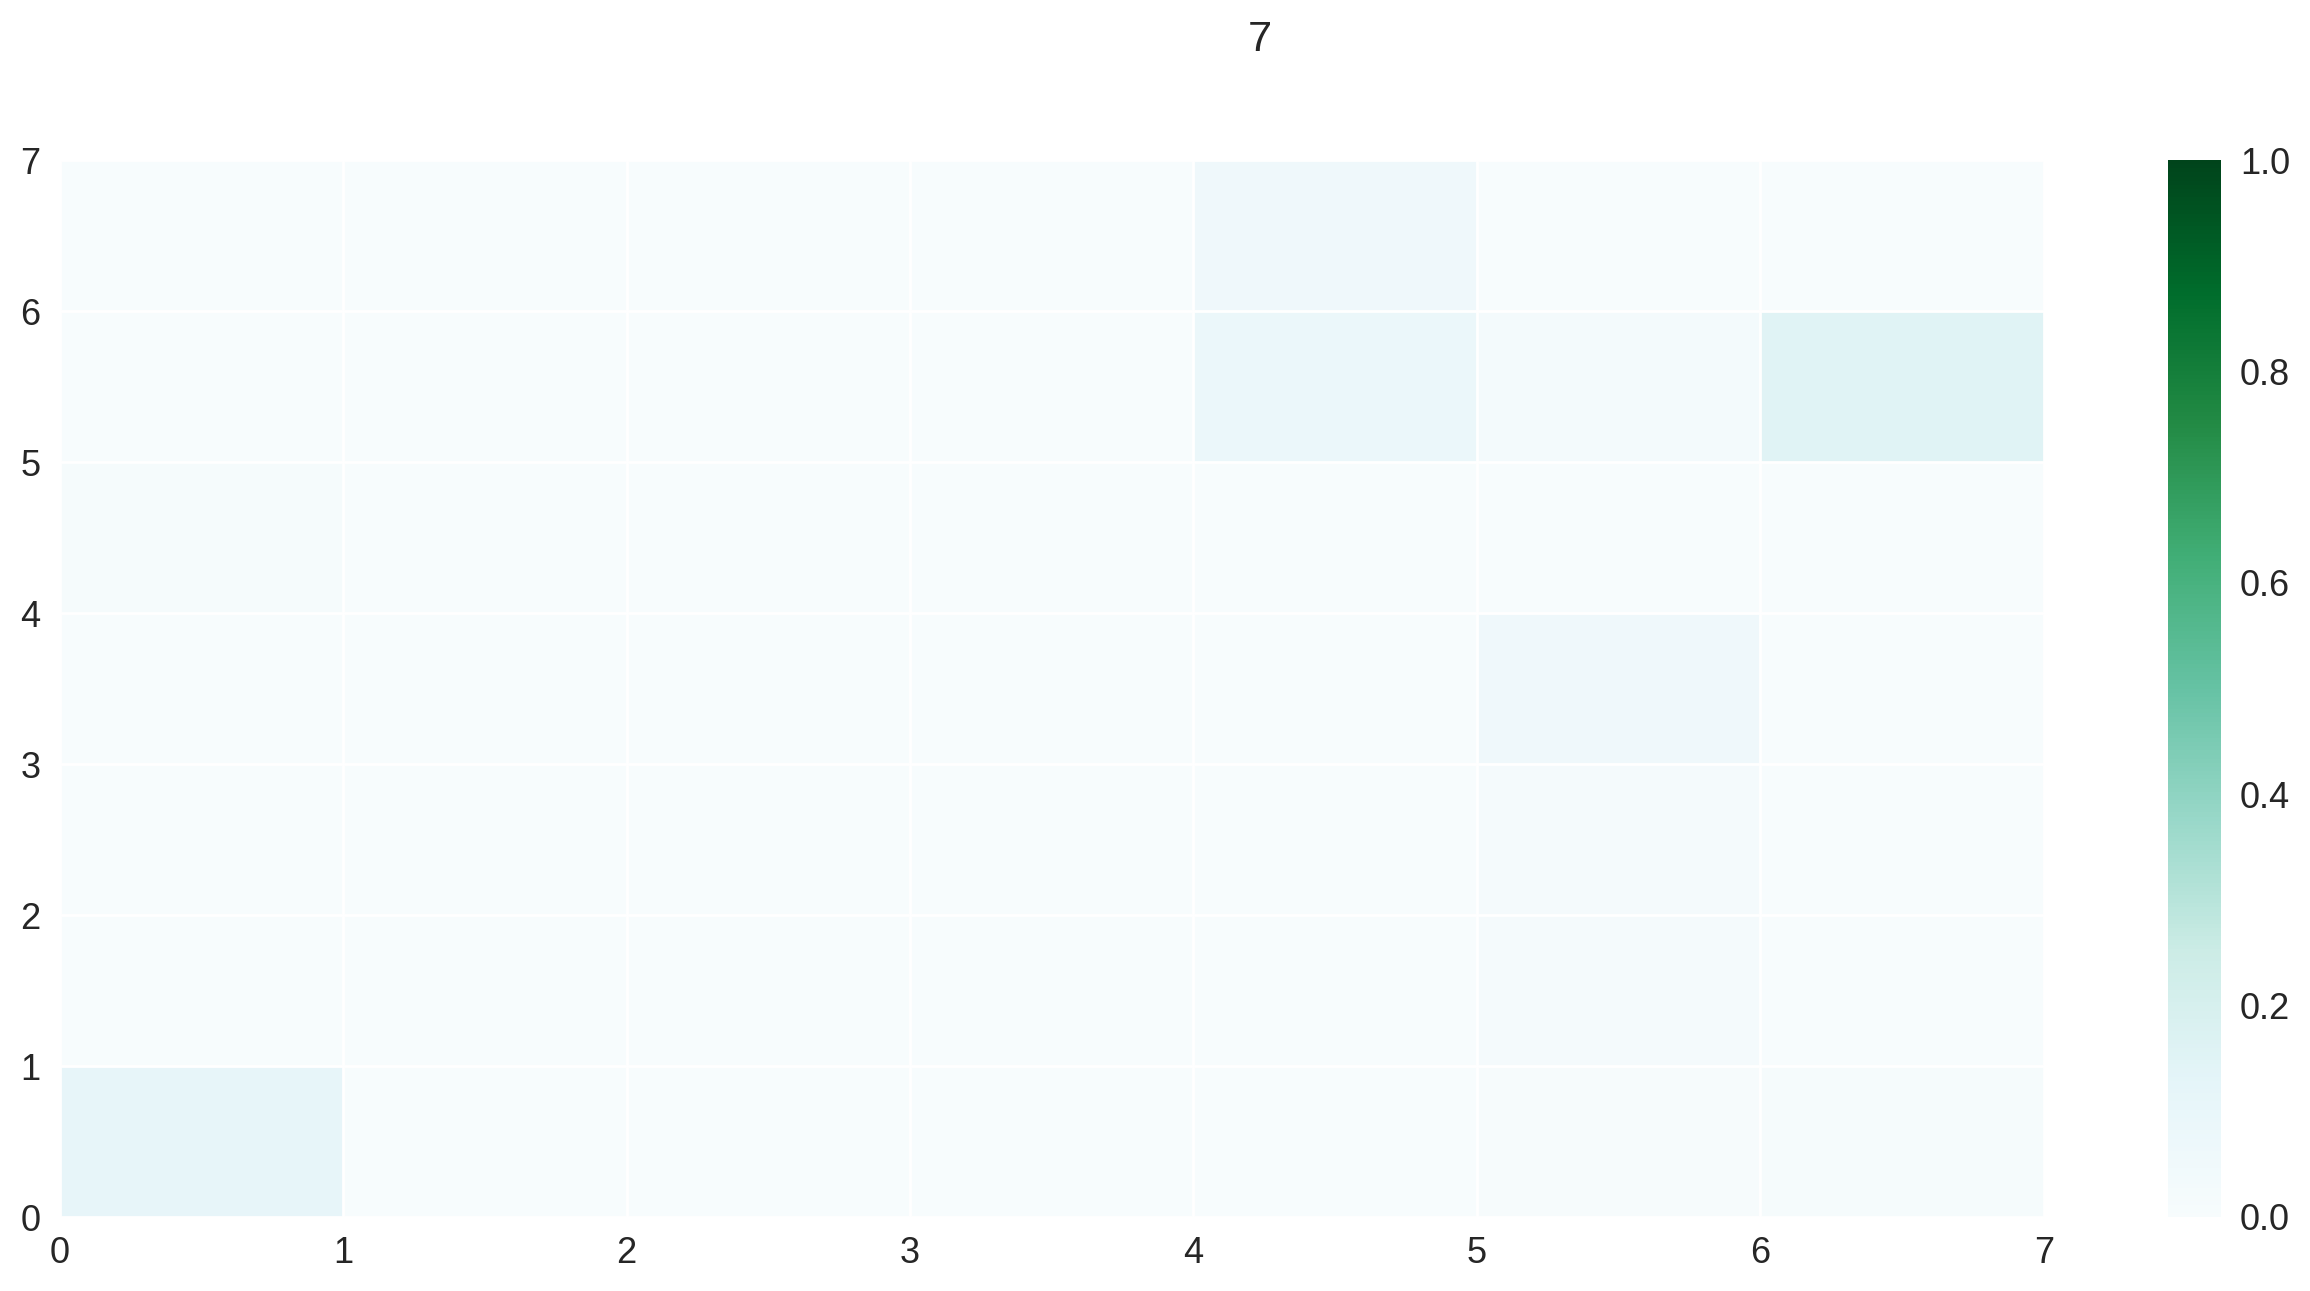

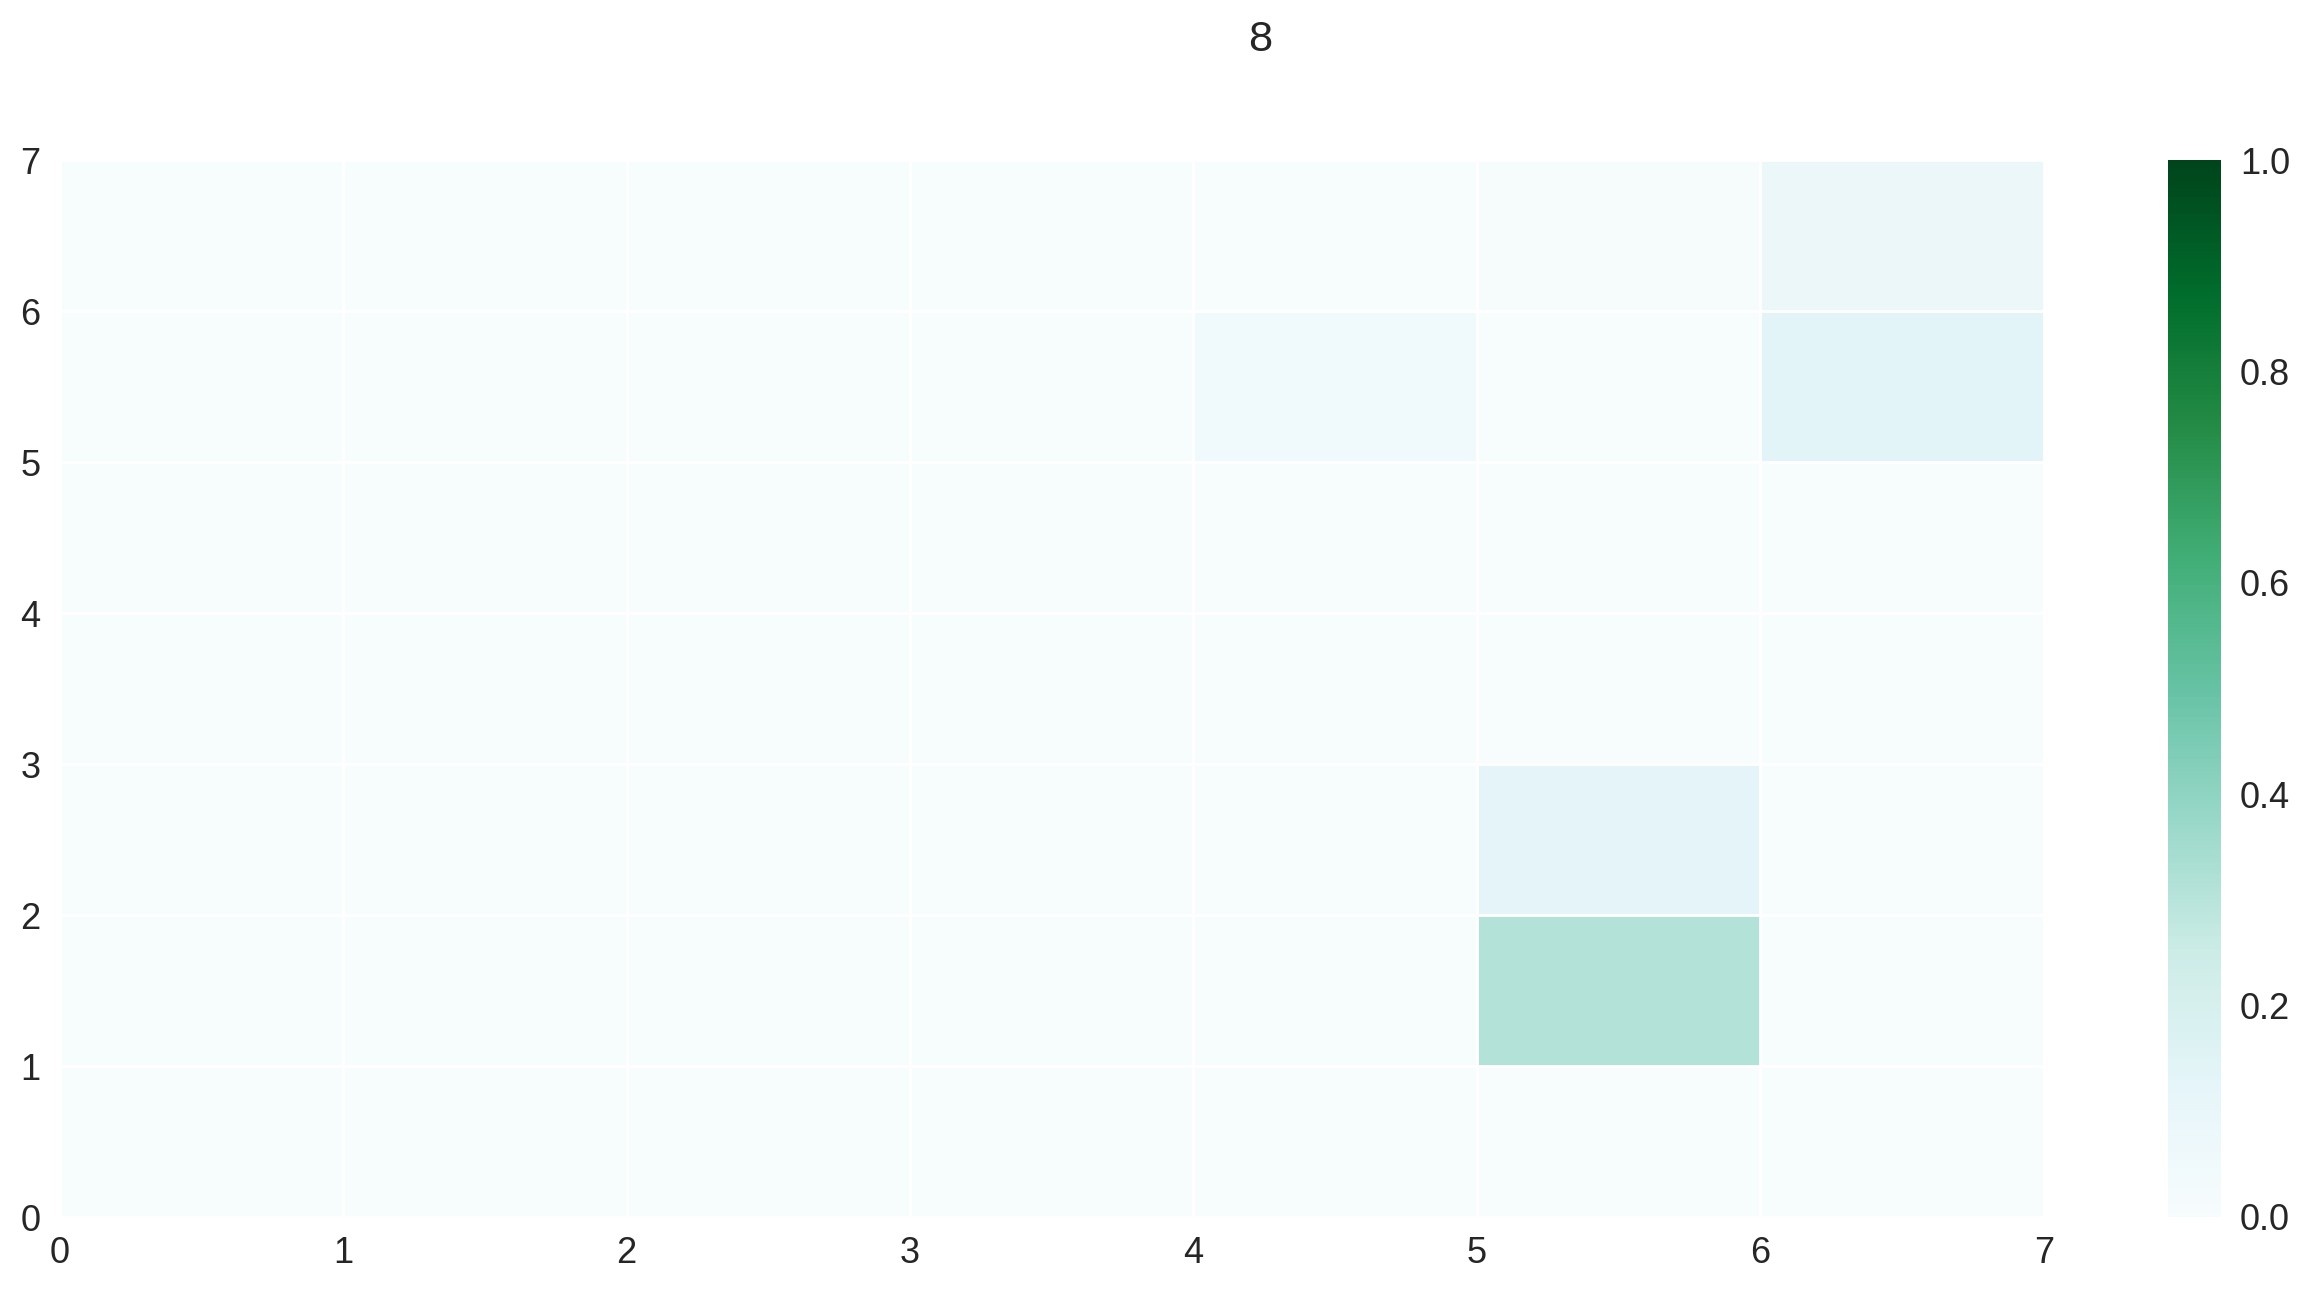

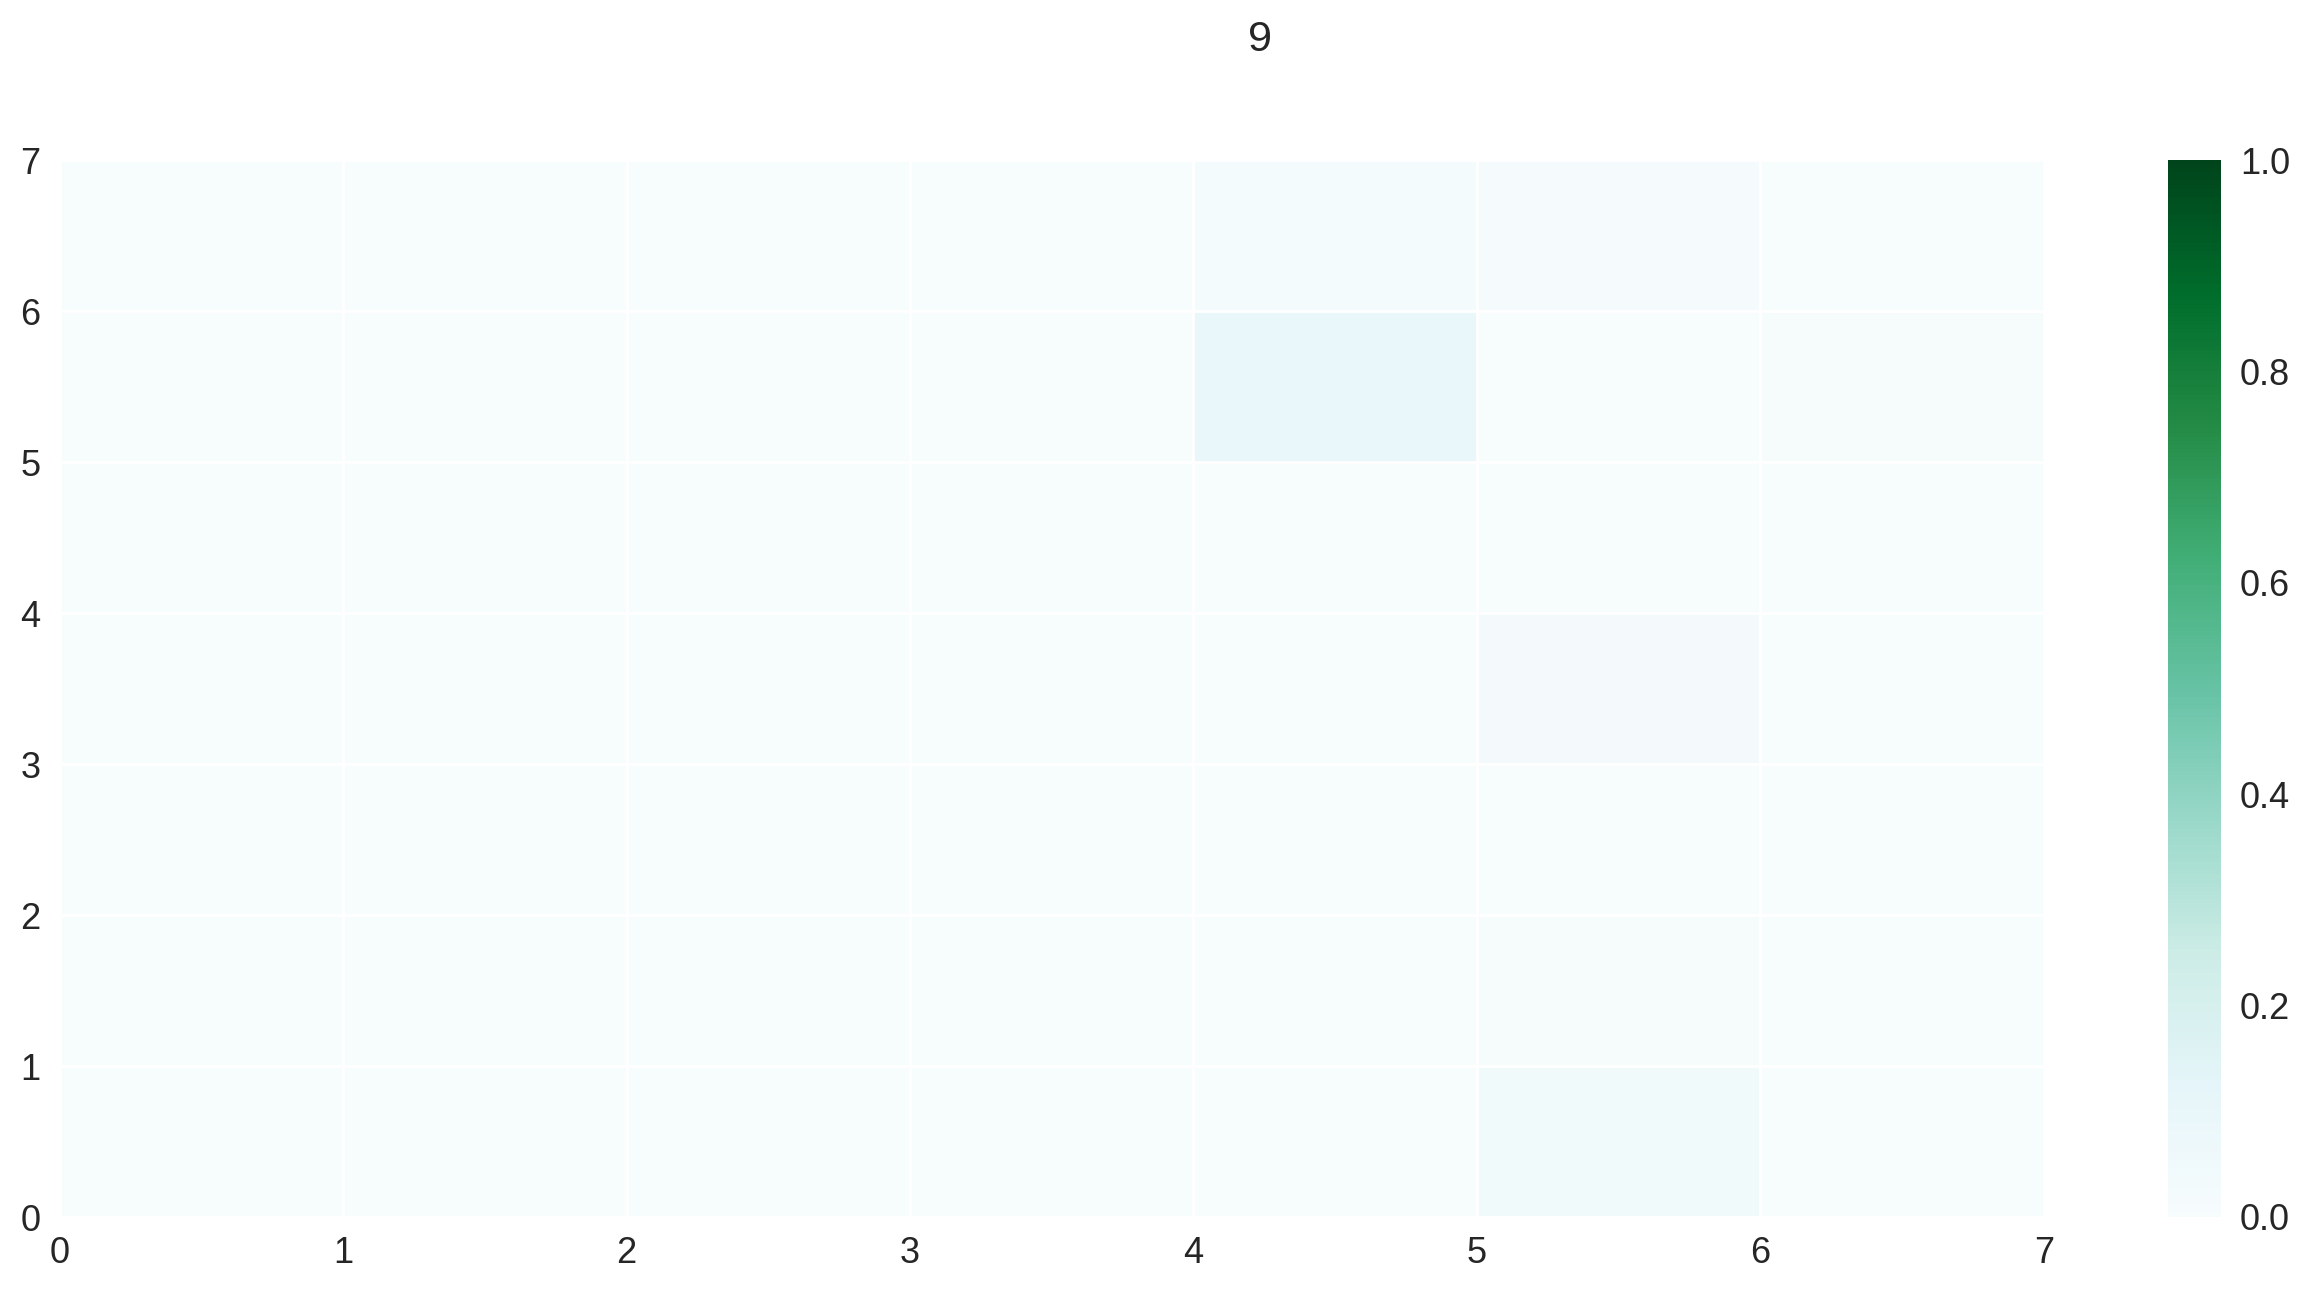

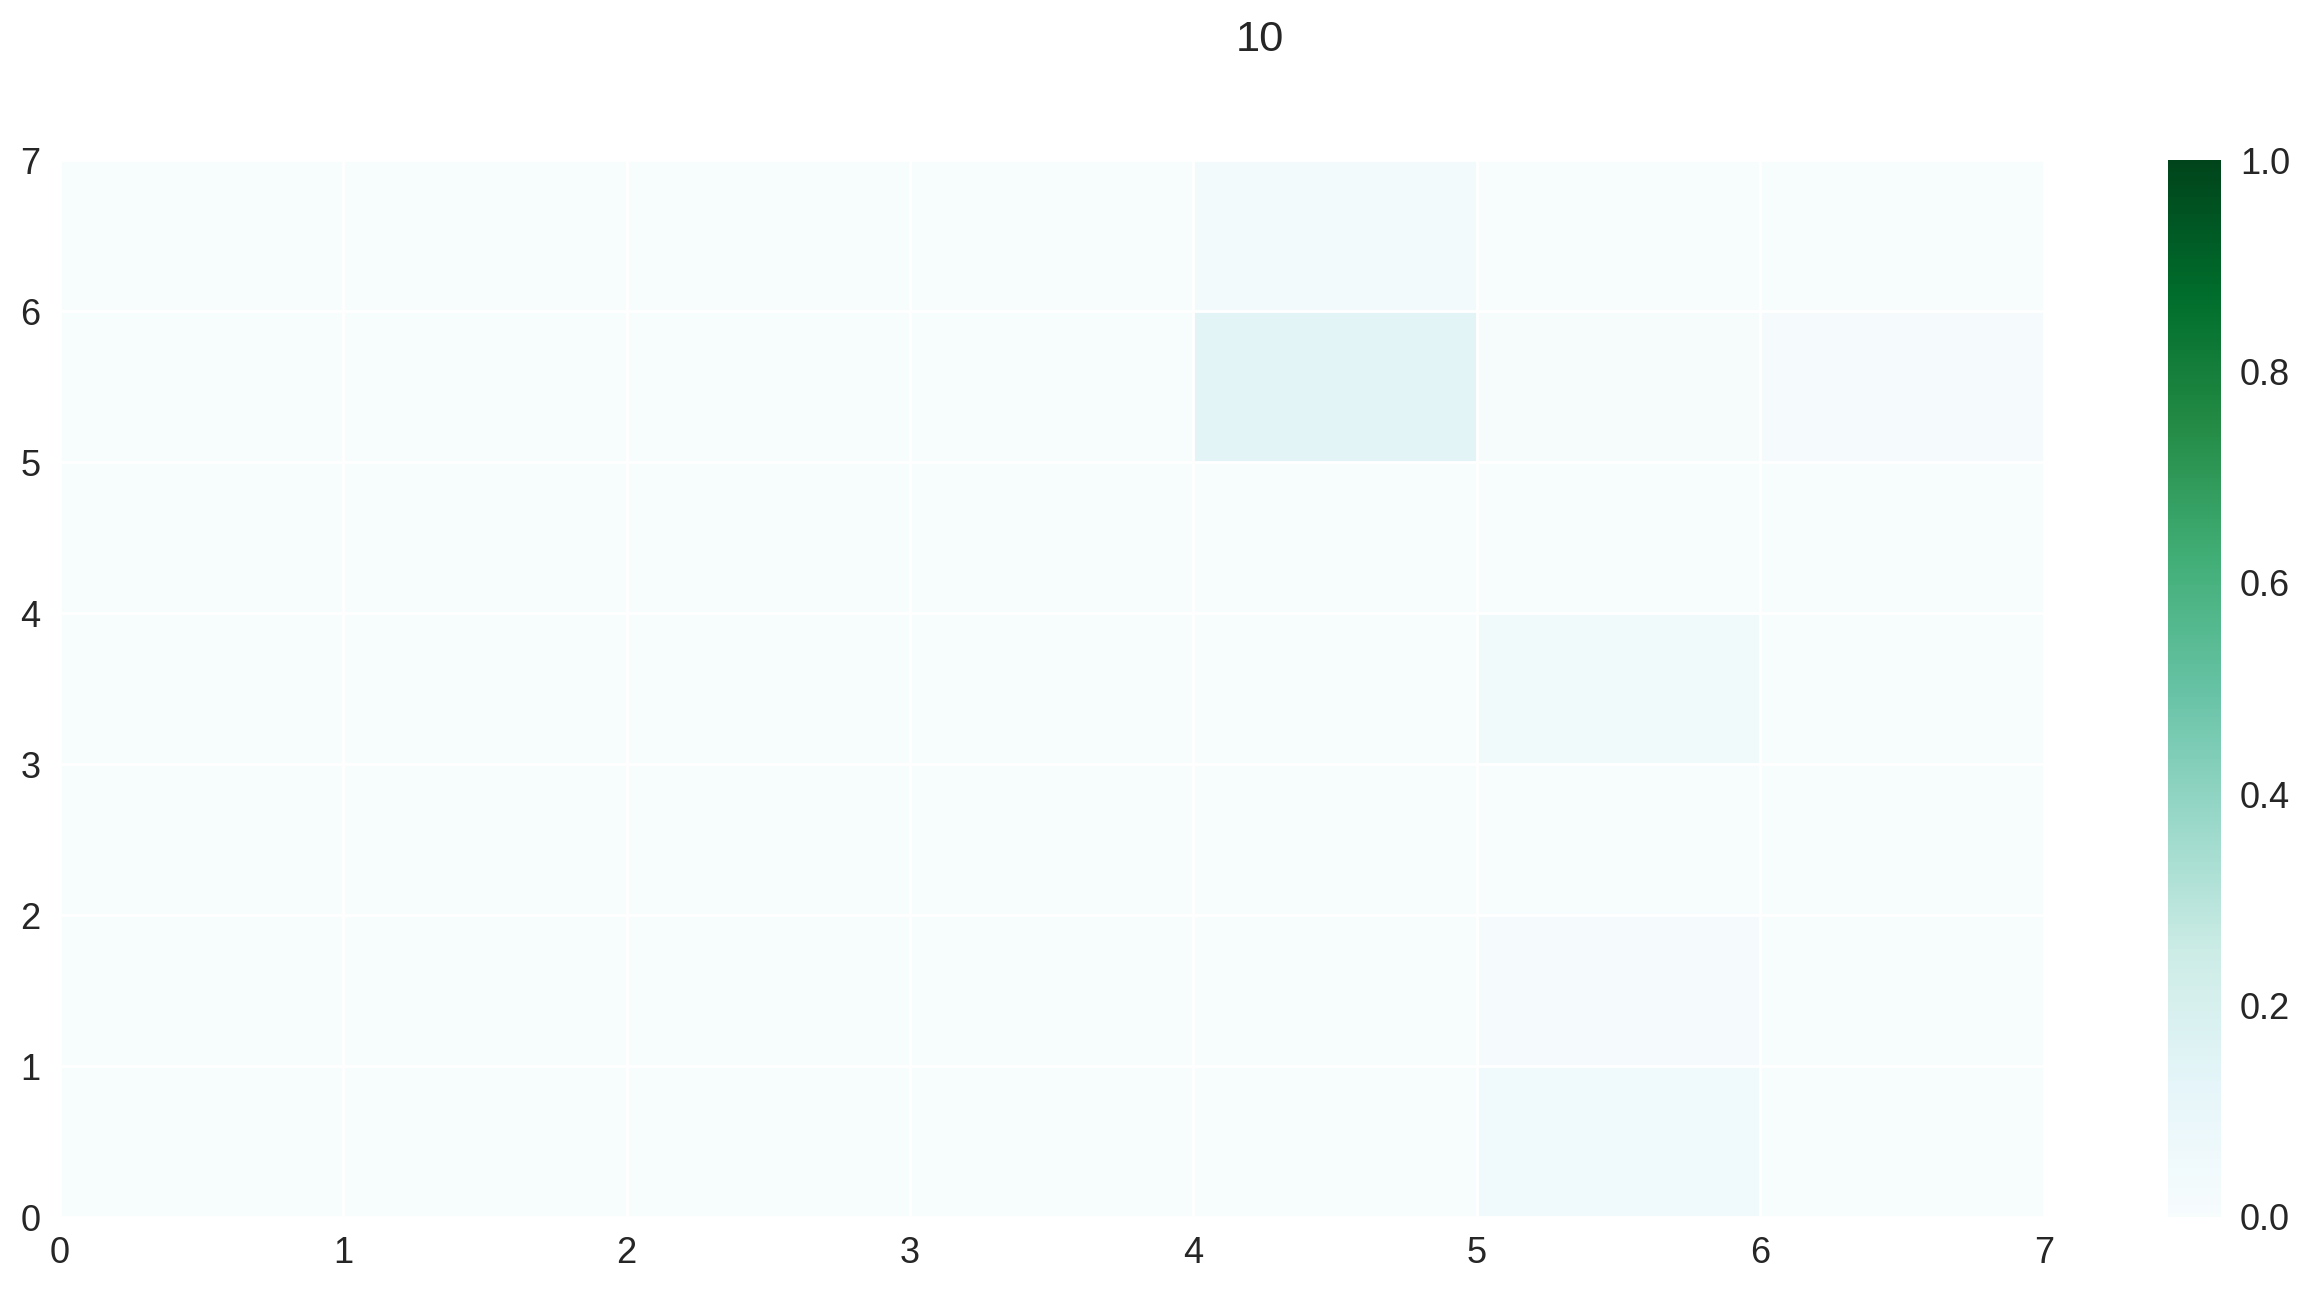

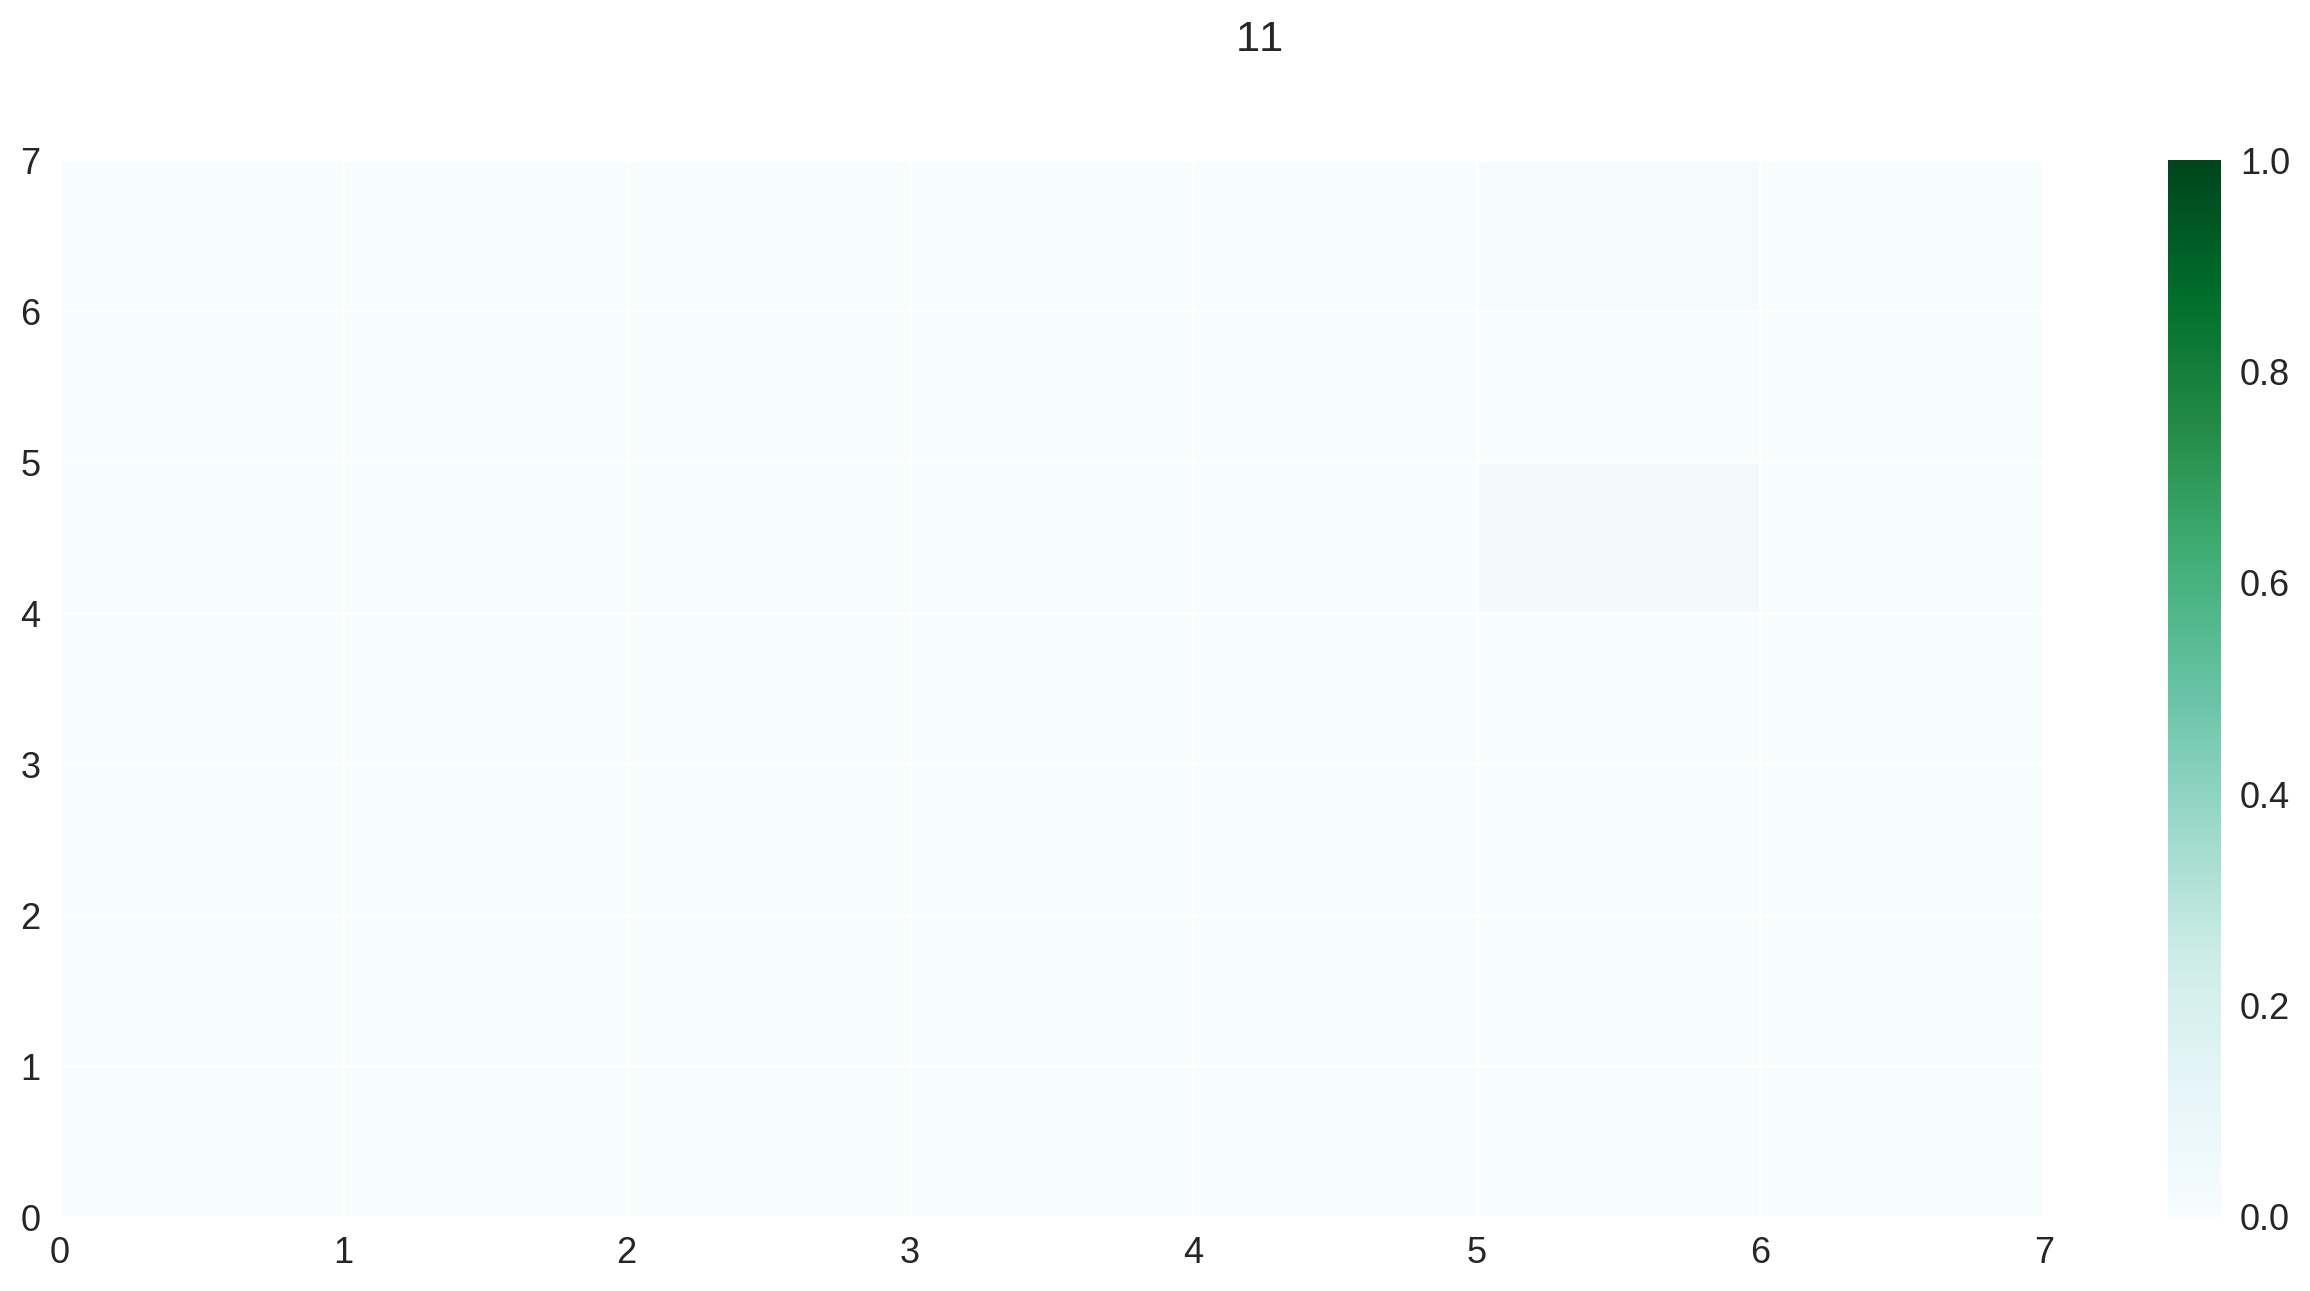

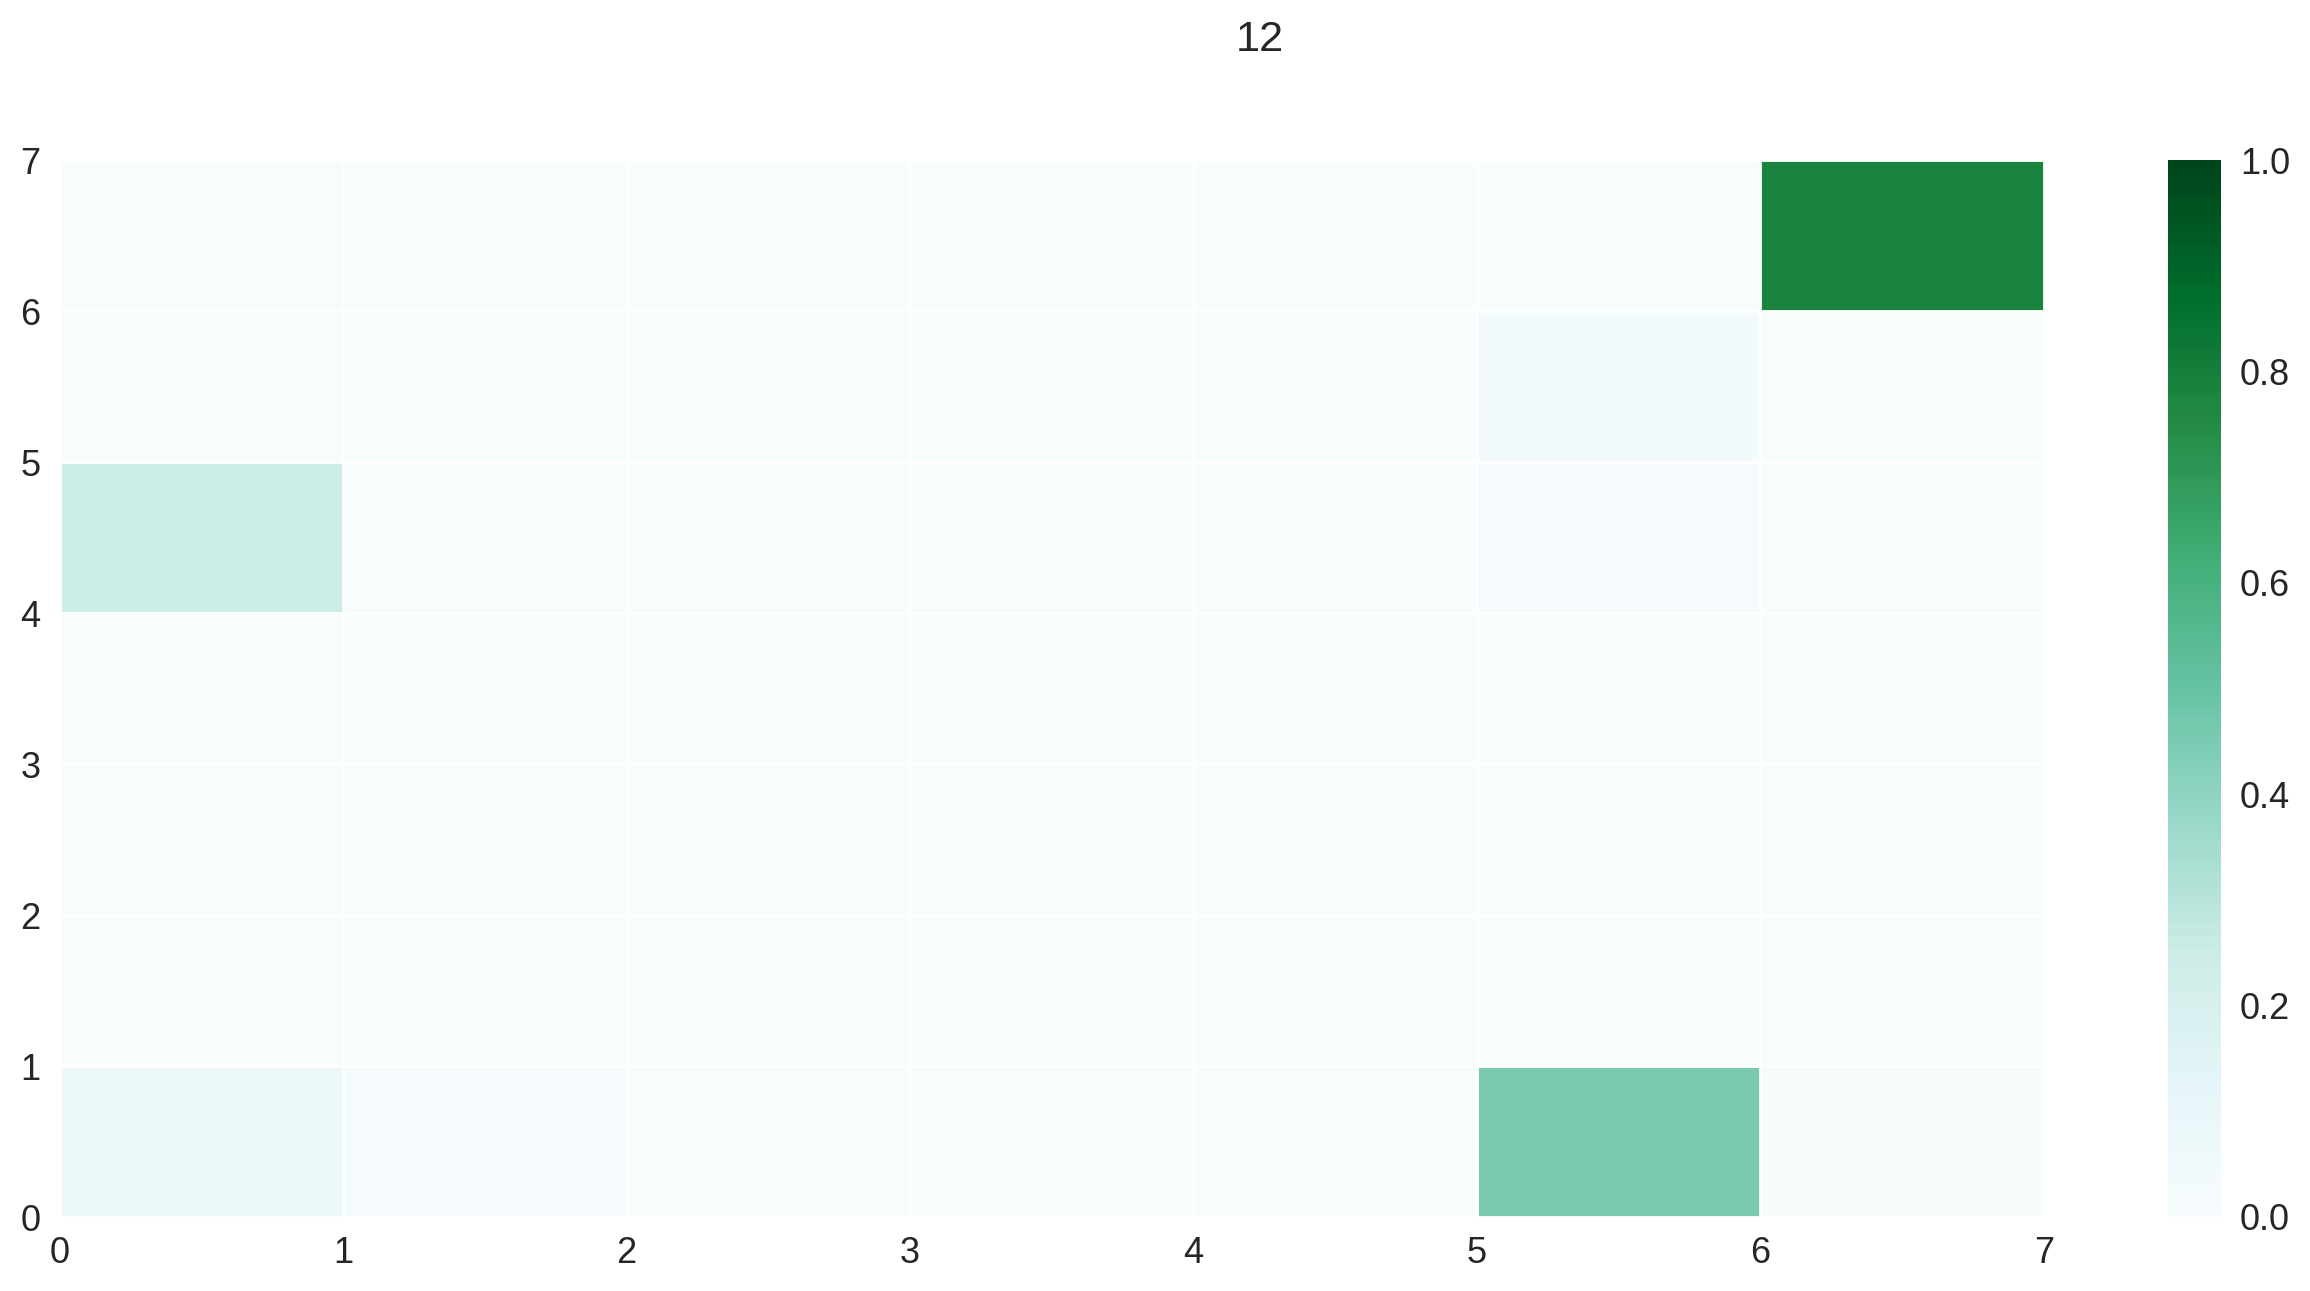

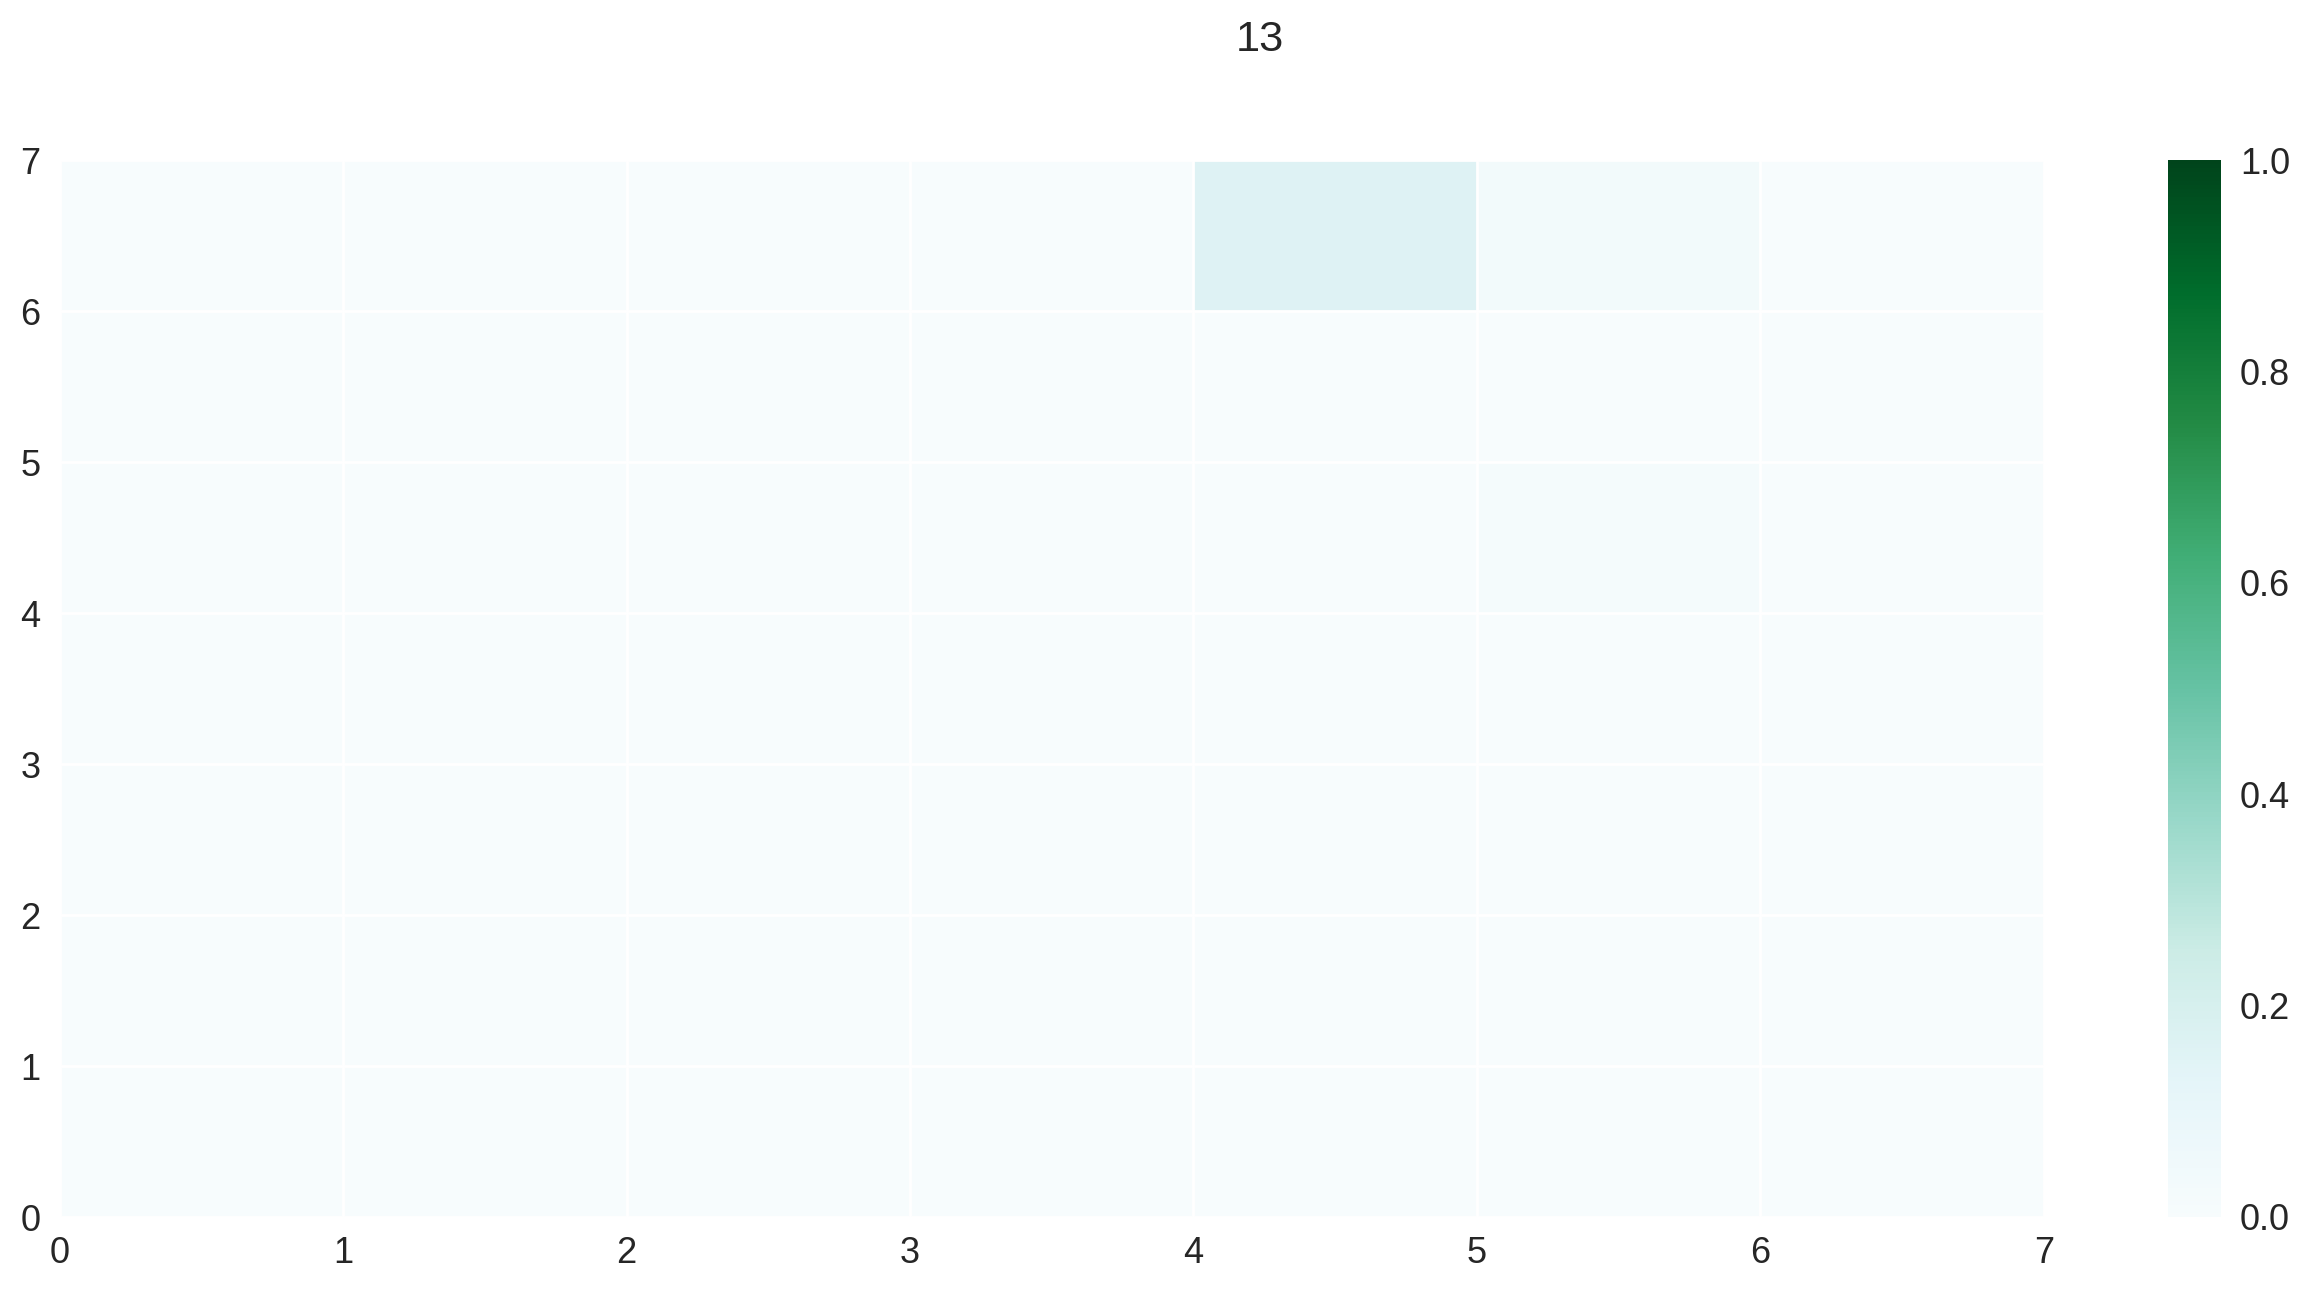

In [47]:
explVar = 0
for i in range(pca.explained_variance_ratio_.size):
    explVar += pca.explained_variance_ratio_[i]
    if explVar > 0.9:
        break
    adjmat = vec2squareMat(pca.components_[:,i]) 
    adjmat[adjmat < 1e-6] = 0.0
    fig, ax = plt.subplots()
    p = ax.pcolorfast(adjmat, vmin=0, vmax=1, cmap=mpl.cm.BuGn)
    fig.colorbar(p)
    fig.suptitle(i)
    disp(fig)

### 0

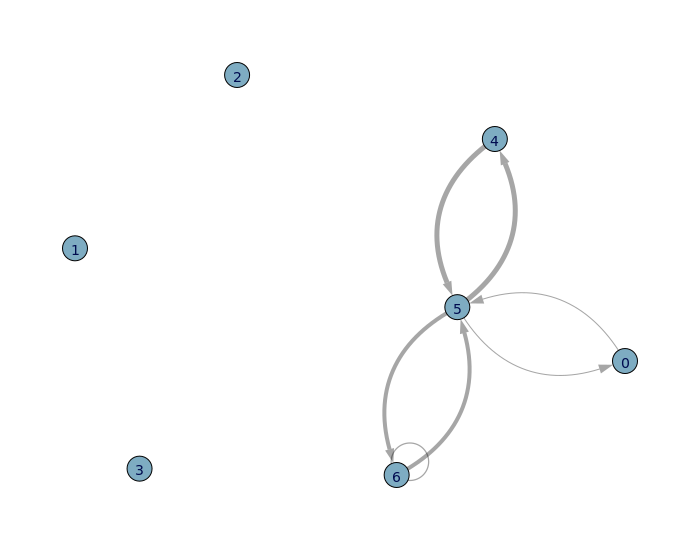

### 1

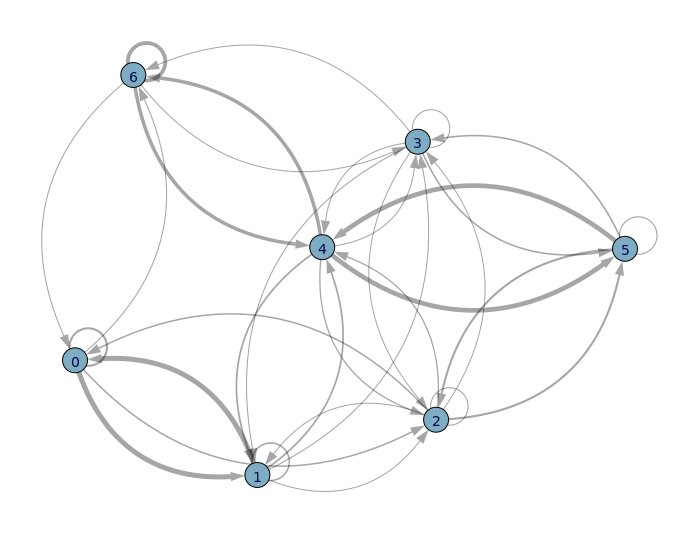

### 2

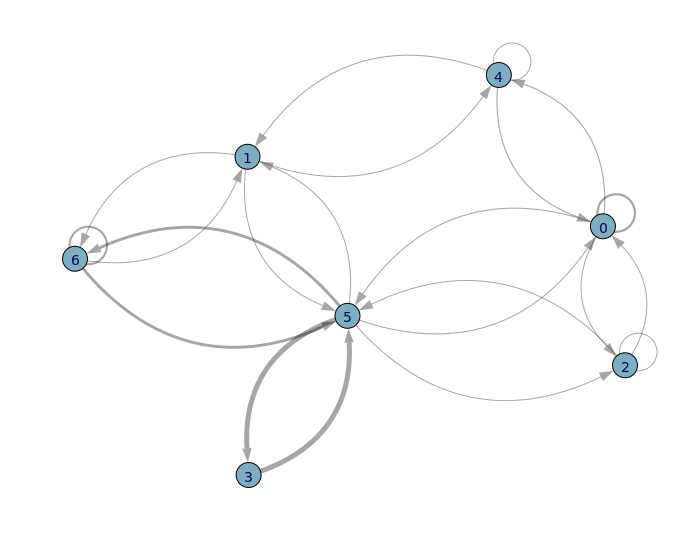

### 3

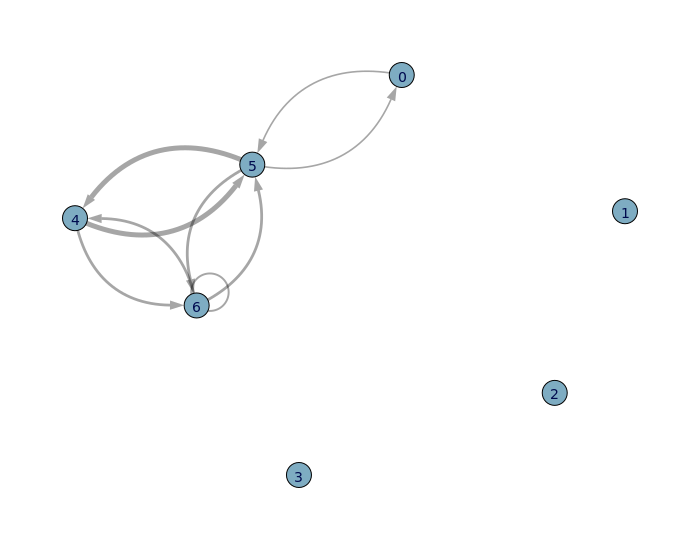

### 4

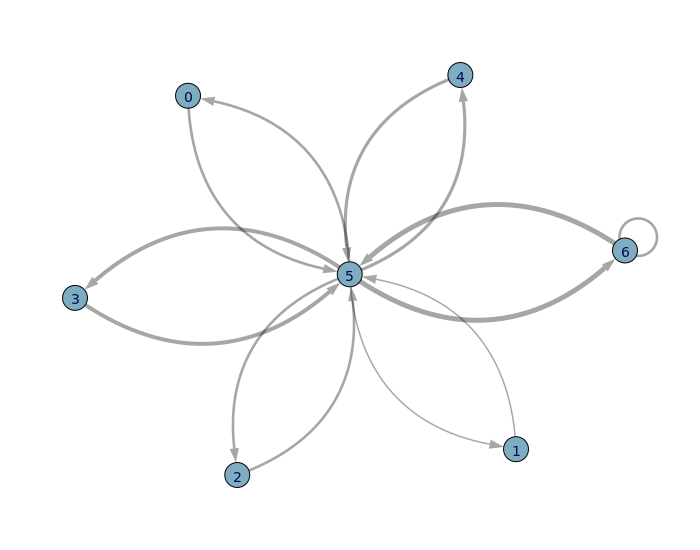

### 5

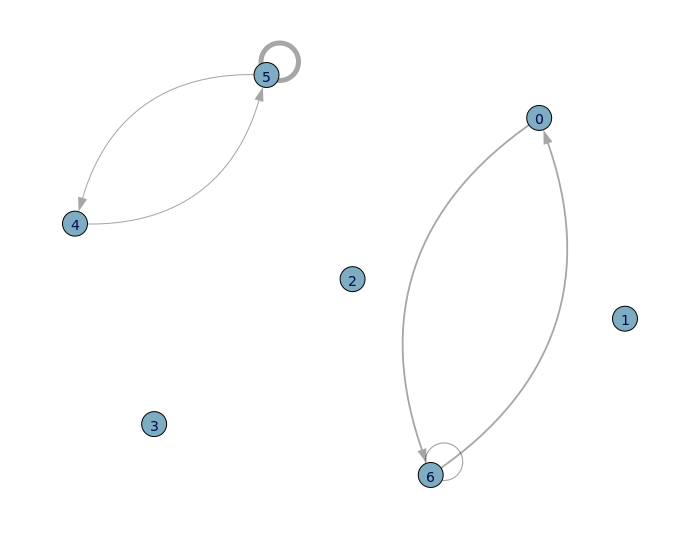

### 6

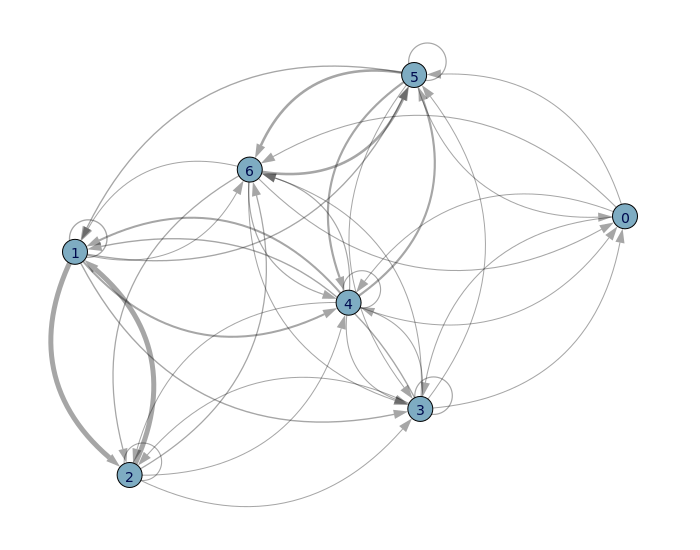

### 7

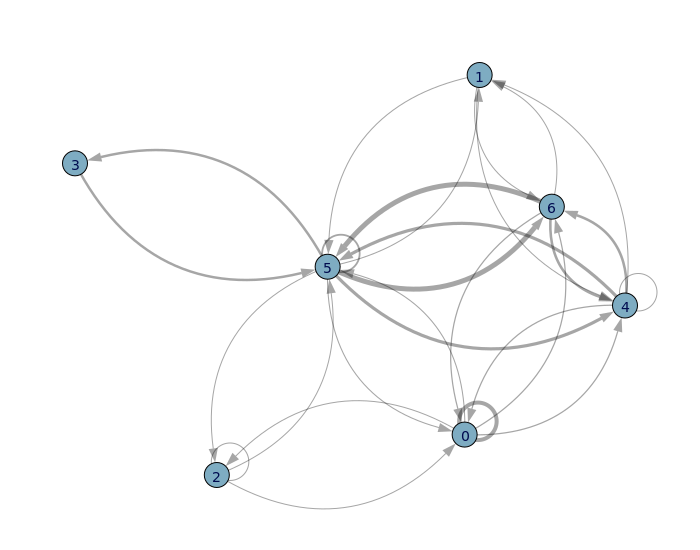

### 8

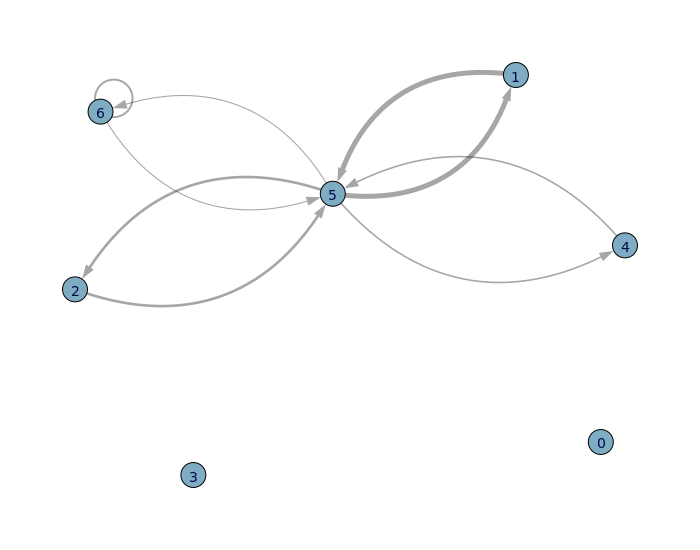

### 9

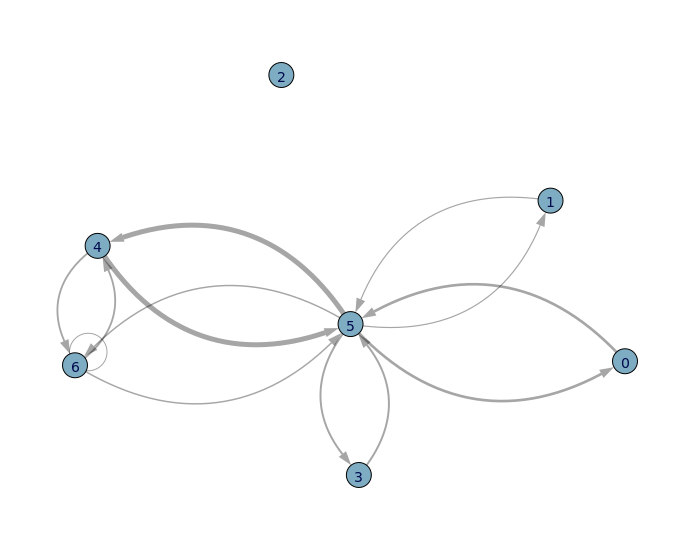

### 10

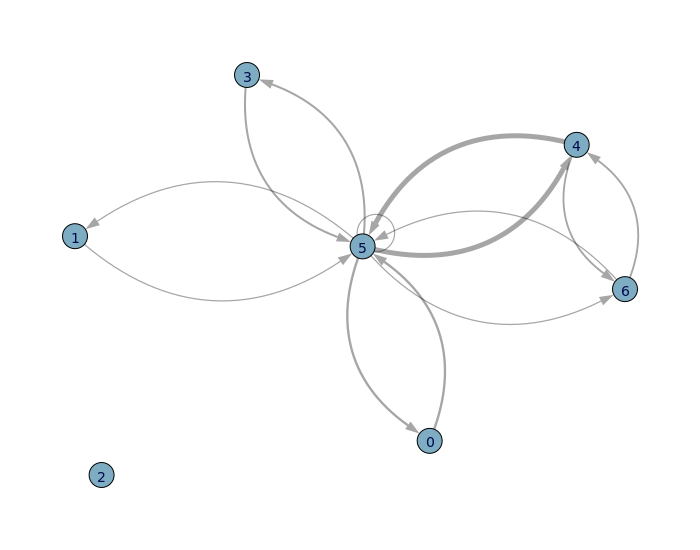

### 11

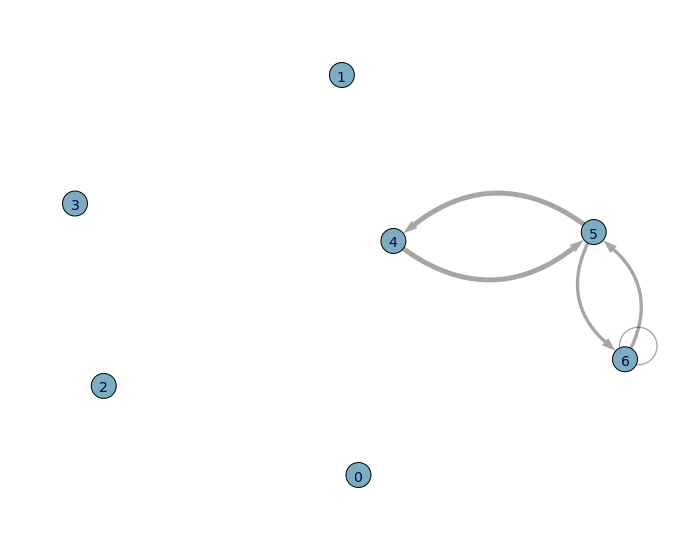

### 12

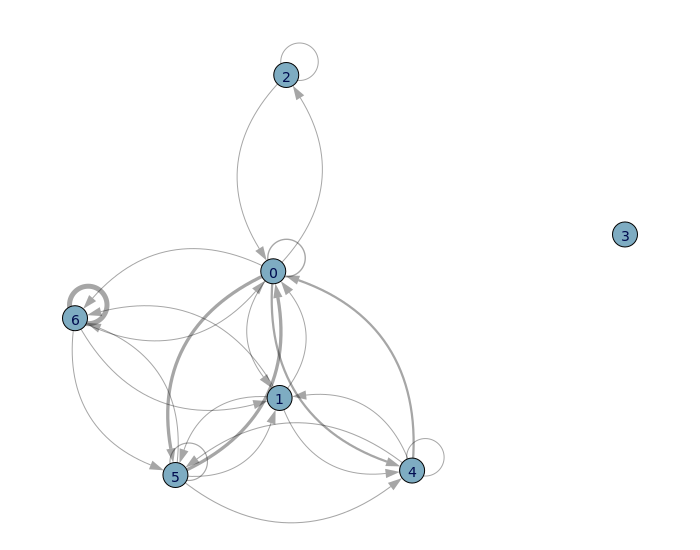

### 13

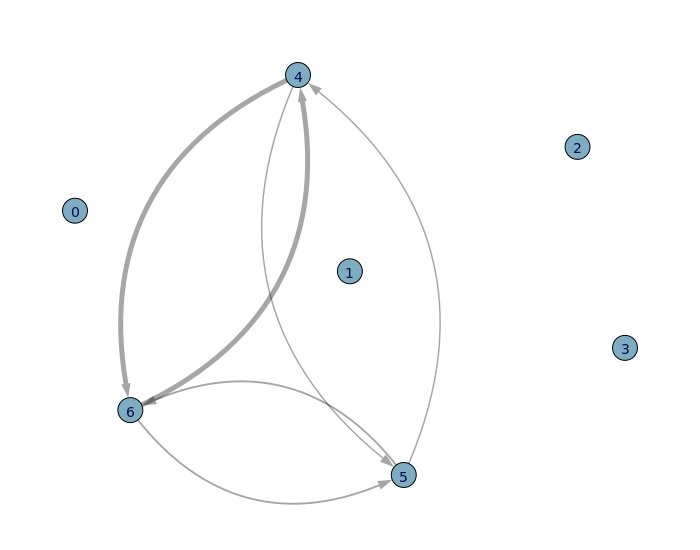

In [48]:
explVar = 0
for i in range(pca.explained_variance_ratio_.size):
    explVar += pca.explained_variance_ratio_[i]
    if explVar > 0.9:
        break
    mdisp(f"### {i}")
    adjmat = vec2squareMat(pca.components_[:,i]) 
    adjmat[adjmat < 1e-4] = 0.0
    tmp = nx.from_numpy_matrix(adjmat)
    draw = igdraw(tmp)
    disp(draw)

In [49]:
import ipywidgets as iw

In [50]:
@iw.interact(cut=(0, 7**2-1, 1), idx=(0, 12, 1))
def f(cut, idx):
    layout = [[3.9877742567859795, 0.10108983249875346],
              [1.9096174697926602, 1.1890965748231208],
              [2.397807521611018, -0.9264800307227699],
              [1.3709208650198719, -0.18028506977491185],
              [3.156617539889597, 1.0547733043844556],
              [3.0469455647068235, -0.041477634452122915],
              [3.6688653065045, -0.7492428253653193]]
    adjmat = vec2squareMat(pca.components_[:, idx])
    val = np.sort(pca.components_[:, 0])[::-1]
    au = adjmat.copy()
    au[au<val[cut]] = 0
    # print(au)
    g = nx.from_numpy_matrix(au, create_using=nx.DiGraph())
    dr = igdraw(g, layout=layout, nodeLabels=True)
    return dr

In [51]:
adjmat = vec2squareMat(pca.components_[:, 0])

# Apply clustering algorithms

In [52]:
from sklearn import cluster

In [53]:
kmeans = cluster.KMeans(max_iter=1000, n_jobs=16, n_clusters=8) 

In [54]:
clstData = standardizeData(pca.components_.T) 

In [55]:
kmeans.fit(clstData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=10, n_jobs=16, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
clst = kmeans.fit_predict(clstData)

In [57]:
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([1731,    1,    1,    2,    1,    1,    1,    3]))

DBSCAN could be interesting

In [58]:
dbscan = cluster.DBSCAN(n_jobs=16)
dbscan.fit(clstData)
clst = dbscan.fit_predict(clstData)

In [59]:
np.unique(clst, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([ 155, 1498,   41,    8,    9,    6,    8,    6,   10]))

In [60]:
clstData.shape

(1741, 49)

… and HDBSCAN as well

In [61]:
from hdbscan import HDBSCAN

In [62]:
hdbscan = HDBSCAN(min_cluster_size=40, p=1, core_dist_n_jobs=16) 
hdbscanClst_p1 = hdbscan.fit_predict(clstData)
np.unique(hdbscanClst_p1, return_counts=True)

(array([-1,  0,  1]), array([ 185, 1505,   51]))

In [63]:
hdbscan = HDBSCAN(min_cluster_size=40, p=2, core_dist_n_jobs=16) 
hdbscanClst_p2 = hdbscan.fit_predict(clstData)
np.unique(hdbscanClst_p2, return_counts=True)

(array([-1,  0,  1]), array([ 185, 1505,   51]))

Spectral clustering could be interesting

In [64]:
n = 600
specClust = cluster.SpectralClustering(n_jobs=16, n_clusters=4) 
specClust.fit(clstData[:n, :])
clst = specClust.fit_predict(clstData[:n, :])

In [65]:
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([491, 103,   3,   3]))

In [66]:
agglo = cluster.AgglomerativeClustering(n_clusters=4)
agglo.fit(clstData)
clst = agglo.fit_predict(clstData)
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3]), array([1738,    1,    1,    1]))